## Amazon Review Dataset - Identify Review helpfulness for the Category "Tools & Home Improvement"

<font color='blue'> 
<b>Subject:</b> Data 270 <br/>
<b>Group:</b> 5 <br/>
<b>Name:</b> Eshita Gupta <br/>
<b>Individual Category for Project:</b> Tools & Home Improvement <br/>
<b>SJSU ID: 016978741</b></font>

#### Importing Required Libraries

In [1]:
# Importing Base Libraries
import pandas as pd
import numpy as np
import re
import datetime
from datetime import datetime
import random
import string
import contractions
import emoji
import itertools
import pickle
from collections import Counter # For n-gram frequency

# Importing Plotting Libraries
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
import seaborn as sns
import squarify
from matplotlib.colors import LinearSegmentedColormap
import gc
from tabulate import tabulate
import shap

# Importing Text Classification Libraries
from wordcloud import WordCloud , ImageColorGenerator
from textblob import TextBlob # For sentiment analysis

# Importing NLTK Libraries
import nltk as nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize # For text tokenization
from nltk.corpus import stopwords # For stopword removal
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer # Stemming and Lemmatization
nltk.download('punkt')
nltk.download('stopwords')

# Importing Utililties for Modelling
from sklearn.feature_extraction.text import TfidfVectorizer # For cosine similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve 
from sklearn.metrics import roc_curve, f1_score, auc, roc_auc_score, precision_score, recall_score
from sklearn.feature_selection import chi2 as chi2_selector
from scipy.stats import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight

# Importing Modelling Libraries
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shitgupt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shitgupt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shitgupt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### <font color='blue'>Importing Dataset and Converting to Dataframe</blue>

In [2]:
# Reading in Appliances sample data
tools_df = pd.read_csv('Tool_and_Home_Improvement_data.csv')

/var/folders/07/qch9szx51kdgzhzp77njqrqw001f2_/T/ipykernel_51037/3494310002.py:2: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
# Creating copy for backup
tools_df_working = tools_df.copy()

In [4]:
# Data snapshot
tools_df_working.head()

overall  verified   reviewTime      reviewerID        asin  \
0        5      True  01 28, 2018   AL19QO4XLBQPU  0982085028   
1        5      True  11 30, 2017  A1I7CVB7X3T81E  0982085028   
2        5      True  09 12, 2017  A1AQXO4P5U674E  0982085028   
3        4      True  07 19, 2017   AIRV678P7C4NK  0982085028   
4        1      True  05 25, 2017  A22I5QDNTNECDW  0982085028   

                                         style   reviewerName  \
0  {'Style:': ' 1) IR30 POU (30A/3.4kW/110v)'}  J. Mollenkamp   
1   {'Style:': ' 3) IR260 POU (30A/6kW/220v)'}         warfam   
2                       {'Style:': ' Style64'}       gbieber2   
3                                          NaN  Justin Banner   
4   {'Style:': ' 3) IR260 POU (30A/6kW/220v)'}     daveparker   

                                          reviewText  \
0             returned, decided against this product   
1  Awesome heater for the electrical requirements...   
2  Keeps the mist of your wood trim and on you. B...   
3  So far I hooked it up and tested it , filled a...   
4  i installed this 10 months ago, instructions w...   

                               summary  unixReviewTime vote image  
0                           Five Stars      1517097600  NaN   NaN  
1                           Five Stars      1512000000  NaN   NaN  
2                           Five Stars      1505174400  NaN   NaN  
3  it is the perfect temp for a shower      1500422400  NaN   NaN  
4         worked well...for 10 months.      1495670400   16   NaN

In [5]:
tools_df_working.dtypes

overall            int64
verified            bool
reviewTime        object
reviewerID        object
asin              object
style             object
reviewerName      object
reviewText        object
summary           object
unixReviewTime     int64
vote              object
image             object
dtype: object

In [6]:
# Checking and removing duplicates

# Original dataset count
print("Before deduplication shape:")
print(tools_df_working.shape)

# Performing deduplication
tools_df_working_dedup = tools_df_working.drop_duplicates()

# Print the DataFrame after deduplication
print("\nAfter deduplication shape:")
print(tools_df_working_dedup.shape)

Before deduplication shape:
(2070831, 12)

After deduplication shape:
(1982666, 12)


In [7]:
# Calculating percentage of duplicates removed
original_count = tools_df_working.shape[0]
deduplicated_count = tools_df_working_dedup.shape[0]
percentage_removed = ((original_count - deduplicated_count) / original_count) * 100

print("\nPercentage of duplicates removed:", percentage_removed, "%")


Percentage of duplicates removed: 4.257469585881223 %


###  <font color='blue'>After deduplication, dataset shrinkage is negligible. </font>
#### After deduplication from overall data, less than <font color='red'>5%</font> of overall data was duplicate which is fine considering the amount of data for applicances category

In [8]:
# Function to count missing values (including NA, NaNs, and 0)
def count_missing(df):
    missing_counts = df.isna().sum()  # Count missing values (NaN)
    missing_counts = missing_counts.add(df.eq(0).sum(), axis=0)  # Count zeros
    return missing_counts

# Printing the counts of missing values
missing_value_counts = count_missing(tools_df_working_dedup.copy())
print(missing_value_counts)

overall                 0
verified           162483
reviewTime              0
reviewerID              0
asin                    0
style              959406
reviewerName          264
reviewText            610
summary               301
unixReviewTime          0
vote              1697705
image             1939789
dtype: int64


### <font color='purple'><b>Data overview and treatment required</b>

1) overall = star rating, keep as is
2) verified = is this verified purchase or not? convert blank to false and to be used for getting helpfulness dependent variable
3) reviewTime = this is in mm dd, yyyy format, need to convert to standard format and then subtract from end of 2018 to get review age
4) reviewerID = ID of the reviewer, keep as is
5) asin = Amazon Standard Identification Number, standard product ID number, keep as is
6) style = describes the SKU or variant, attempt to standardize
7) reviewName = name of the reviewer, keep as is
8) reviewText = actual review text; meta data to be extracted from raw data, text cleaning/mining to be performed and then converted to tfidf matrix
9) summary = review title, meta data to be extracted, similarity to reviewText to be calculated
10) vote = number of votes for helpfulness, convert blank to 0 and to be used for getting helpfulness dependent variable
11) image = URL of image if available, to be converted to flag of whether image is available or not</font>

In [9]:
# Data treatment
# reviewTime date standardization

# format string from the original date format
format_string = "%m %d, %Y"  # mm dd, yyyy

# Standardizing date format
tools_df_working_dedup["reviewTime_cleaned"] = pd.to_datetime(tools_df_working_dedup["reviewTime"], format=format_string)

# Checking to see if it worked
tools_df_working_dedup.head()

overall  verified   reviewTime      reviewerID        asin  \
0        5      True  01 28, 2018   AL19QO4XLBQPU  0982085028   
1        5      True  11 30, 2017  A1I7CVB7X3T81E  0982085028   
2        5      True  09 12, 2017  A1AQXO4P5U674E  0982085028   
3        4      True  07 19, 2017   AIRV678P7C4NK  0982085028   
4        1      True  05 25, 2017  A22I5QDNTNECDW  0982085028   

                                         style   reviewerName  \
0  {'Style:': ' 1) IR30 POU (30A/3.4kW/110v)'}  J. Mollenkamp   
1   {'Style:': ' 3) IR260 POU (30A/6kW/220v)'}         warfam   
2                       {'Style:': ' Style64'}       gbieber2   
3                                          NaN  Justin Banner   
4   {'Style:': ' 3) IR260 POU (30A/6kW/220v)'}     daveparker   

                                          reviewText  \
0             returned, decided against this product   
1  Awesome heater for the electrical requirements...   
2  Keeps the mist of your wood trim and on you. B...   
3  So far I hooked it up and tested it , filled a...   
4  i installed this 10 months ago, instructions w...   

                               summary  unixReviewTime vote image  \
0                           Five Stars      1517097600  NaN   NaN   
1                           Five Stars      1512000000  NaN   NaN   
2                           Five Stars      1505174400  NaN   NaN   
3  it is the perfect temp for a shower      1500422400  NaN   NaN   
4         worked well...for 10 months.      1495670400   16   NaN   

  reviewTime_cleaned  
0         2018-01-28  
1         2017-11-30  
2         2017-09-12  
3         2017-07-19  
4         2017-05-25

In [10]:
tools_df_working_dedup.shape

(1982666, 13)

#### <font color='blue'>After filtering the data for <b>2010-2018</b>, we have excluded only <b>0.011%</b> of data which is negligible</font>

In [11]:
# Extracting year, month, day from the review datetime
tools_df_working_dedup["review_year"] = pd.to_datetime(tools_df_working_dedup["reviewTime_cleaned"]).dt.year
tools_df_working_dedup["review_month"] = pd.to_datetime(tools_df_working_dedup["reviewTime_cleaned"]).dt.month
tools_df_working_dedup["review_day"] = pd.to_datetime(tools_df_working_dedup["reviewTime_cleaned"]).dt.day

# Filtering out data before 2010
tools_df_working_dedup_filter = tools_df_working_dedup[(tools_df_working_dedup['review_year'] >= 2010) &
                                           (tools_df_working_dedup['review_year'] <= 2018)]

In [12]:
# Calculating percentage of filtered records after filtering data for 2010-2018
original_count = len(tools_df_working_dedup)
filter_count = tools_df_working_dedup_filter.shape[0]
percentage_removed = ((original_count-filter_count)  / original_count)
print(percentage_removed)

0.011700911802593075


#### <font color='blue'> Data Treatment and Imputation </font>

In [13]:
# Data treatment
# Verified imputation
# There are a lot of missing values for which we will impute with False
# If there is missing data then it is false

# Imputing missing values with False in the verified column
tools_df_working_dedup_filter['verified_clean'] = tools_df_working_dedup_filter['verified'].fillna(False)

# Checking the imputation
print(tools_df_working_dedup_filter['verified_clean'].isnull().sum())  # Should be 0 after imputation

0


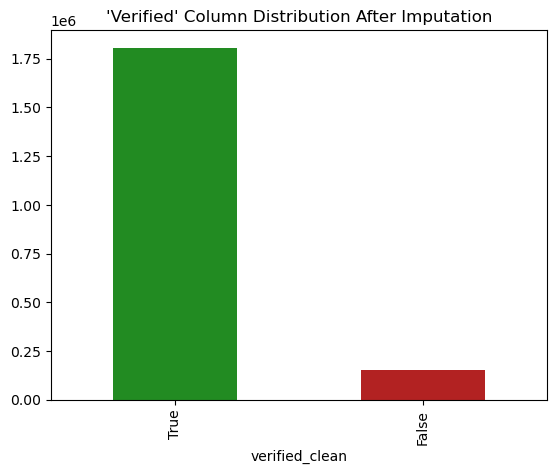

In [14]:
# Plotting the distribution of the 'verified_clean' column after imputation

# Counting the occurrences of each unique value in the 'verified_clean' column
value_counts = tools_df_working_dedup_filter['verified_clean'].value_counts()

# Defining colors for the bars
colors = ['forestgreen', 'firebrick']

# Creating a bar plot to visualize the distribution
value_counts.plot(kind='bar', color=colors)

# Adding title to the plot
plt.title("'Verified' Column Distribution After Imputation")

# Displaying the plot
plt.show()

In [15]:
# Data treatment
# Vote imputation
# There are a lot of missing values for which we will impute with 0
# If the votes are missing, then they are zero and hence we are imputing with zero

# Imputing missing values with 0
tools_df_working_dedup_filter["vote_clean"] = tools_df_working_dedup_filter["vote"].fillna(0)

# Checking the imputation
print(tools_df_working_dedup_filter['vote_clean'].isnull().sum())  # Should be 0 after imputation

0


In [16]:
# Data treatment
# reviewName imputation
# There are missing values which will be imputed with "Unknown"
# If the reviewer name is missing, we don't know who the user is and hence, we are imputing the missing values with "Unknown".
tools_df_working_dedup["reviewerName_clean"] = tools_df_working_dedup["reviewerName"].fillna("Unknown")

# Checking the imputation
print(tools_df_working_dedup['reviewerName_clean'].isnull().sum())  # Should be 0 after imputation.

0


In [17]:
# Data treatment
# reviewText imputation
# There are missing values in reviewText and hence, these records will be excluded. We are excluding because it is neglible

tools_df_working_dedup = tools_df_working_dedup.dropna(subset=["reviewText"])
# Checking the imputation
print(tools_df_working_dedup['reviewText'].isnull().sum())  # Should be 0 after imputation.

0


In [18]:
# Data treatment
# summary imputation
# There are missing values in summary which will be excluded because it is neglible
tools_df_working_dedup = tools_df_working_dedup.dropna(subset=["summary"])
# Checking the imputation
print(tools_df_working_dedup['summary'].isnull().sum())  # Should be 0 after imputation.

0


In [19]:
# Data treatment
# Image URL availability

# Defining a regular expression for URL validation
# Observed from the data that non-null values have https pattern
url_regex = r"https?://\S+"

# Creating a new column with flag based on URL presence
tools_df_working_dedup_filter['image_available'] = tools_df_working_dedup_filter['image'].apply(lambda x:
                                                                                            bool(re.match(url_regex, str(x))))

# Check
tools_df_working_dedup_filter.tail()

overall  verified   reviewTime      reviewerID        asin  \
2070826        4      True   03 7, 2017  A2Y0L6RLGE6AG0  B01HJCLMMQ   
2070827        5      True   03 2, 2017  A31CQSAL2PI371  B01HJCLMMQ   
2070828        5      True   01 7, 2017  A3PR3RT5QL5I3O  B01HJCLMMQ   
2070829        4      True  04 17, 2018   A1LQ5376UESSM  B01HJF90LS   
2070830        2      True   12 4, 2017  A1T9O7WJWI1XSR  B01HJHS73S   

                             style        reviewerName  \
2070826                        NaN  William R. Oldaker   
2070827                        NaN        Kenny L Nipp   
2070828                        NaN        J. Ro Morgan   
2070829  {'Color:': ' warm white'}               Simon   
2070830                        NaN       craig johnson   

                                                reviewText  \
2070826                                         I like it.   
2070827  Great task light. I travel extensively and con...   
2070828  Very bright, beautifully packaged, light weigh...   
2070829  Clever replacement for a mason jar top, a sola...   
2070830  Item still works, but the time lights stay lit...   

                                                   summary  unixReviewTime  \
2070826                                         Four Stars      1488844800   
2070827  You can set the light to various conditions to...      1488412800   
2070828                           I bought a second one...      1483747200   
2070829  Pretty - but nobody tells you the lights only ...      1523923200   
2070830                       1 year after purchase review      1512345600   

        vote image reviewTime_cleaned  review_year  review_month  review_day  \
2070826  NaN   NaN         2017-03-07         2017             3           7   
2070827  NaN   NaN         2017-03-02         2017             3           2   
2070828  NaN   NaN         2017-01-07         2017             1           7   
2070829  NaN   NaN         2018-04-17         2018             4          17   
2070830  NaN   NaN         2017-12-04         2017            12           4   

         verified_clean vote_clean  image_available  
2070826            True          0            False  
2070827            True          0            False  
2070828            True          0            False  
2070829            True          0            False  
2070830            True          0            False

In [20]:
tools_df_working_dedup_filter.dtypes
# vote_clean is a string, needs to be converted to numeric

tools_df_working_dedup_filter["vote_clean"] = pd.to_numeric(tools_df_working_dedup_filter["vote_clean"],
                                                                 errors='coerce')

In [21]:
#tools_df_working_dedup.dtypes
tools_df_working_dedup_filter.describe()

overall  unixReviewTime             reviewTime_cleaned  \
count  1.959467e+06    1.959467e+06                        1959467   
mean   4.409158e+00    1.451203e+09  2015-12-27 07:50:30.148708864   
min    1.000000e+00    1.262304e+09            2010-01-01 00:00:00   
25%    4.000000e+00    1.420934e+09            2015-01-11 00:00:00   
50%    5.000000e+00    1.457568e+09            2016-03-10 00:00:00   
75%    5.000000e+00    1.488154e+09            2017-02-27 00:00:00   
max    5.000000e+00    1.538611e+09            2018-10-04 00:00:00   
std    1.074832e+00    5.019403e+07                            NaN   

        review_year  review_month    review_day    vote_clean  
count  1.959467e+06  1.959467e+06  1.959467e+06  1.959449e+06  
mean   2.015500e+03  6.370940e+00  1.572818e+01  1.040968e+00  
min    2.010000e+03  1.000000e+00  1.000000e+00  0.000000e+00  
25%    2.015000e+03  3.000000e+00  8.000000e+00  0.000000e+00  
50%    2.016000e+03  6.000000e+00  1.600000e+01  0.000000e+00  
75%    2.017000e+03  1.000000e+01  2.300000e+01  0.000000e+00  
max    2.018000e+03  1.200000e+01  3.100000e+01  9.700000e+02  
std    1.626880e+00  3.555367e+00  8.809746e+00  8.472493e+00

In [22]:
tools_df_working_dedup_filter.head()

overall  verified   reviewTime      reviewerID        asin  \
0        5      True  01 28, 2018   AL19QO4XLBQPU  0982085028   
1        5      True  11 30, 2017  A1I7CVB7X3T81E  0982085028   
2        5      True  09 12, 2017  A1AQXO4P5U674E  0982085028   
3        4      True  07 19, 2017   AIRV678P7C4NK  0982085028   
4        1      True  05 25, 2017  A22I5QDNTNECDW  0982085028   

                                         style   reviewerName  \
0  {'Style:': ' 1) IR30 POU (30A/3.4kW/110v)'}  J. Mollenkamp   
1   {'Style:': ' 3) IR260 POU (30A/6kW/220v)'}         warfam   
2                       {'Style:': ' Style64'}       gbieber2   
3                                          NaN  Justin Banner   
4   {'Style:': ' 3) IR260 POU (30A/6kW/220v)'}     daveparker   

                                          reviewText  \
0             returned, decided against this product   
1  Awesome heater for the electrical requirements...   
2  Keeps the mist of your wood trim and on you. B...   
3  So far I hooked it up and tested it , filled a...   
4  i installed this 10 months ago, instructions w...   

                               summary  unixReviewTime vote image  \
0                           Five Stars      1517097600  NaN   NaN   
1                           Five Stars      1512000000  NaN   NaN   
2                           Five Stars      1505174400  NaN   NaN   
3  it is the perfect temp for a shower      1500422400  NaN   NaN   
4         worked well...for 10 months.      1495670400   16   NaN   

  reviewTime_cleaned  review_year  review_month  review_day  verified_clean  \
0         2018-01-28         2018             1          28            True   
1         2017-11-30         2017            11          30            True   
2         2017-09-12         2017             9          12            True   
3         2017-07-19         2017             7          19            True   
4         2017-05-25         2017             5          25            True   

   vote_clean  image_available  
0         0.0            False  
1         0.0            False  
2         0.0            False  
3         0.0            False  
4        16.0            False

In [23]:
tools_df_working_dedup_filter['vote_clean'].dtype

dtype('float64')

In [24]:
# Checking for non-numeric values after conversion
non_numeric_count = tools_df_working_dedup_filter["vote_clean"].isna().sum()
if non_numeric_count > 0:
    print(f"Warning: {non_numeric_count} non-numeric values in vote_clean after conversion")


In [25]:
tools_df_working_dedup_filter["vote_clean"].unique()

array([  0.,  16.,   5.,   2.,  20.,  11.,   3.,  18.,   7.,  23.,   4.,
        24.,  35.,  28.,  17.,  21.,  34.,   8.,  19.,  14.,  10.,   6.,
        30.,  22.,  45.,   9.,  15.,  13.,  75.,  12.,  38.,  25.,  27.,
        63.,  32.,  84.,  31.,  76.,  26.,  71.,  51., 137.,  29.,  37.,
        44., 124.,  64.,  95.,  33.,  57.,  47.,  90.,  50.,  41., 486.,
       171., 336.,  91.,  58.,  78.,  54., 153.,  nan, 438.,  43., 263.,
       125.,  88.,  39.,  55.,  42., 210., 174.,  97.,  77.,  46.,  80.,
        99.,  79.,  86., 119.,  49.,  89., 155., 297., 152., 216., 165.,
        40., 248., 179.,  53.,  60.,  52.,  85., 196., 122., 136.,  83.,
        66.,  65.,  96., 158.,  87., 188., 204.,  61., 275.,  36., 226.,
       191.,  48., 493.,  94.,  82., 224.,  56., 143., 133.,  62., 355.,
       100., 123., 146., 142.,  98.,  59., 451.,  81., 172., 138., 166.,
       238., 126.,  92., 114., 120., 327., 341., 112., 148., 115.,  67.,
       303., 339., 498., 154., 116., 111., 314., 17

In [26]:
print(tools_df_working_dedup_filter.columns)

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'reviewTime_cleaned', 'review_year', 'review_month',
       'review_day', 'verified_clean', 'vote_clean', 'image_available'],
      dtype='object')


In [27]:
# For some reason, nan isn't going away, dropping 4 rows
# There are only 4 values which are nan and it is convenient to drop these values.
tools_df_working_dedup_filter = tools_df_working_dedup_filter.dropna(subset=["vote_clean"])

In [28]:
tools_df_working_dedup_filter.shape

(1959449, 19)

In [29]:
tools_df_working_dedup_filter["vote_clean"].unique()

array([  0.,  16.,   5.,   2.,  20.,  11.,   3.,  18.,   7.,  23.,   4.,
        24.,  35.,  28.,  17.,  21.,  34.,   8.,  19.,  14.,  10.,   6.,
        30.,  22.,  45.,   9.,  15.,  13.,  75.,  12.,  38.,  25.,  27.,
        63.,  32.,  84.,  31.,  76.,  26.,  71.,  51., 137.,  29.,  37.,
        44., 124.,  64.,  95.,  33.,  57.,  47.,  90.,  50.,  41., 486.,
       171., 336.,  91.,  58.,  78.,  54., 153., 438.,  43., 263., 125.,
        88.,  39.,  55.,  42., 210., 174.,  97.,  77.,  46.,  80.,  99.,
        79.,  86., 119.,  49.,  89., 155., 297., 152., 216., 165.,  40.,
       248., 179.,  53.,  60.,  52.,  85., 196., 122., 136.,  83.,  66.,
        65.,  96., 158.,  87., 188., 204.,  61., 275.,  36., 226., 191.,
        48., 493.,  94.,  82., 224.,  56., 143., 133.,  62., 355., 100.,
       123., 146., 142.,  98.,  59., 451.,  81., 172., 138., 166., 238.,
       126.,  92., 114., 120., 327., 341., 112., 148., 115.,  67., 303.,
       339., 498., 154., 116., 111., 314., 175., 69

In [30]:
# Checking for NaN values in summary
summary_nan_count = tools_df_working_dedup_filter["summary"].isna().sum()
if summary_nan_count > 0:
    print(f"Warning: {summary_nan_count} nan values in summary after conversion")


#### <font color='blue'>There were NaN values in summary which were negligible hence they are dropped<font>

In [31]:
# NaN will be dropped in the summary
tools_df_working_dedup_filter = tools_df_working_dedup_filter.dropna(subset=["summary"])

In [32]:
# Checking for NaN values in # reviewText
reviewText_nan_count = tools_df_working_dedup_filter["reviewText"].isna().sum()
if reviewText_nan_count > 0:
    print(f"Warning: {reviewText_nan_count} nan values in review Text")


#### <font color='blue'>There were NaN values in review Text which is negligible hence they are dropped</font>

In [33]:
# NaN will be dropped in the reviewText
tools_df_working_dedup_filter = tools_df_working_dedup_filter.dropna(subset=["reviewText"])

In [34]:
# Checking for non-numeric values after conversion
summary_nan_count = tools_df_working_dedup_filter["summary"].isna().sum()
if summary_nan_count > 0:
    print(f"Warning: {summary_nan_count} nan values in summary")

In [35]:
# For some reason, nan isn't going away, dropping 2 rows
tools_df_working_dedup_filter = tools_df_working_dedup_filter.dropna(subset=["vote_clean"])

In [36]:
tools_df_working_dedup_filter.shape

(1958582, 19)

##### <font color='blue'>Showing Distribution of votes on Linear and Logarithmic Scale</font>

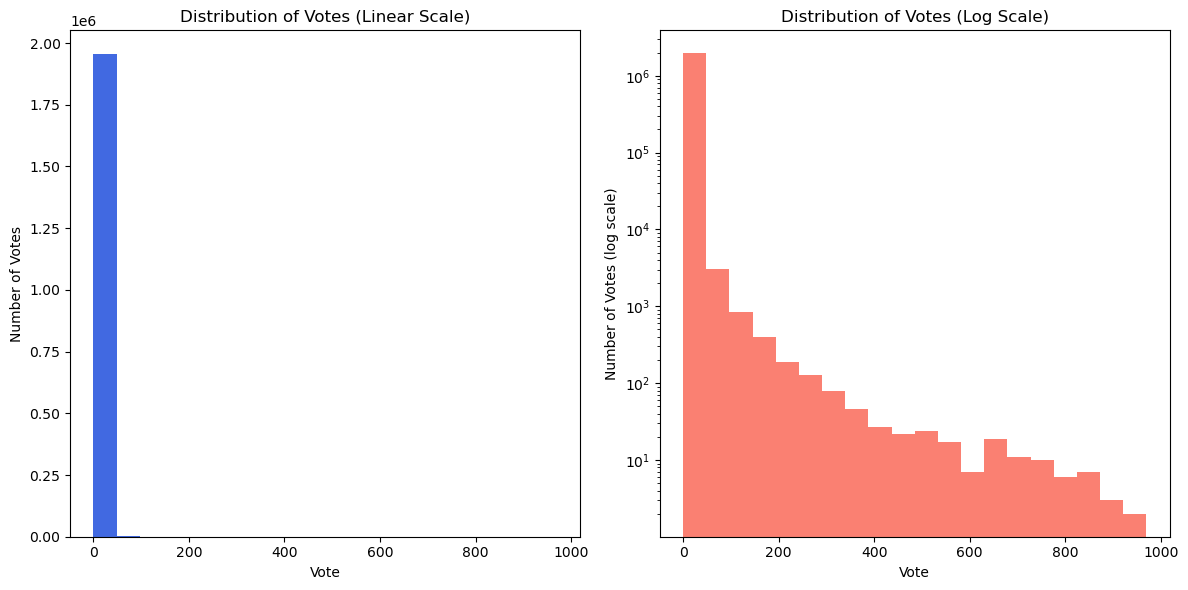

In [37]:
# Creating a figure and axis objects for subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1: Distribution of votes (linear scale)
axs[0].hist(tools_df_working_dedup_filter['vote_clean'], bins=20, color='royalblue')
axs[0].set_xlabel("Vote")
axs[0].set_ylabel("Number of Votes")
axs[0].set_title("Distribution of Votes (Linear Scale)")

# Subplot 2: Distribution of votes (log scale)
axs[1].hist(tools_df_working_dedup_filter['vote_clean'], bins=20, color='salmon', log=True)
axs[1].set_xlabel("Vote")
axs[1].set_ylabel("Number of Votes (log scale)")
axs[1].set_title("Distribution of Votes (Log Scale)")

# Adjust layout to prevent overlapping of labels
plt.tight_layout()

# Show the plot
plt.show()

In [38]:
# Cross tab of vote counts
# Cross tabulation of vote counts
print(tools_df_working_dedup_filter['vote_clean'].value_counts().sort_index(ascending=True))

vote_clean
0.0      1689798
2.0        95906
3.0        48547
4.0        28816
5.0        18827
          ...   
893.0          1
898.0          1
900.0          1
947.0          1
970.0          1
Name: count, Length: 473, dtype: int64


#### <font color='blue'>Creating the Target variable <b>helpfulness_binary</b></font>

In [39]:
# Creating our dependent variable 'helpfulness_binary' with the following conditions
# 1 if Votes > 0 and verified is True
# 0 otherwise
tools_df_working_dedup_filter['helpfulness_binary'] = tools_df_working_dedup_filter[['vote_clean', 'verified_clean']].apply(lambda x:
                                                        1 if x['vote_clean'] > 0
                                                        and x['verified_clean'] else 0,
                                                        axis=1)

# Checking counts
print(tools_df_working_dedup_filter['helpfulness_binary'].value_counts().sort_index(ascending=True))


helpfulness_binary
0    1726619
1     231963
Name: count, dtype: int64


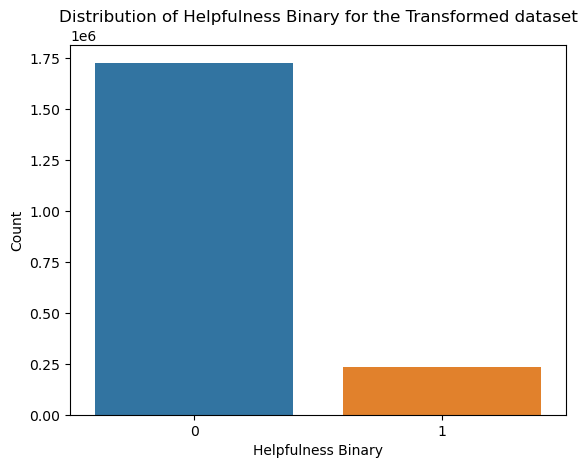

In [40]:
# Plotting the distribution of 'helpfulness_binary'
sns.countplot(x='helpfulness_binary', data=tools_df_working_dedup_filter)
plt.title('Distribution of Helpfulness Binary for the Transformed dataset')
plt.xlabel('Helpfulness Binary')
plt.ylabel('Count')
plt.show()

In [41]:
# Calculating the total number of entries
total_entries = len(tools_df_working_dedup_filter)

# Calculating the count 'helpfulness_binary'
helpfulness_counts = tools_df_working_dedup_filter['helpfulness_binary'].value_counts()

# Calculating the percentage 
percentage_1 = (helpfulness_counts[1] / total_entries) * 100
percentage_0 = (helpfulness_counts[0] / total_entries) * 100

# Printing the percentages
print("Percentage of Helpfulness", percentage_1)
print("Percentage of Not helpfulness", percentage_0)


Percentage of Helpfulness 11.843415287182257
Percentage of Not helpfulness 88.15658471281775


### <font color='blue'>Stratified sampling</font>
#### As our datasize is huge close to 2.7 million rows, its not ideal to perform modelling on the entire volume of data. So we will use a sample size of 50K and perform modelling.

In [42]:
tools_df_working_dedup_filter.isnull().sum()

overall                     0
verified                    0
reviewTime                  0
reviewerID                  0
asin                        0
style                  941850
reviewerName              256
reviewText                  0
summary                     0
unixReviewTime              0
vote                  1689798
image                 1916057
reviewTime_cleaned          0
review_year                 0
review_month                0
review_day                  0
verified_clean              0
vote_clean                  0
image_available             0
helpfulness_binary          0
dtype: int64

In [43]:
# Stratified sampling
def stratified_sampling(data, sample_size, feature_list):

    strata_counts = data.groupby(feature_list).size()

    # Calculating target sample sizes for each stratum (proportional to population)
    total_count = strata_counts.sum()
    strata_sample_sizes = (strata_counts / total_count * sample_size).round().astype(int)

    # Sample calculation of reviews from each stratum
    sampled_reviews = []
    for stratum, size in strata_sample_sizes.items():
        # Checking if sample size for the stratum is 0
        if size == 0:
            continue  # Skip sampling for this stratum

        stratum_reviews = data[data[feature_list].eq(stratum).all(axis=1)]
        # Adjusting sample size if it's larger than the number of items available in the stratum
        # taking max may lead to oversampling
        # min will be more accurate
        size = min(size, len(stratum_reviews))
        # Random sampling within the stratum
        # replace=False ensures that same datapoint isn't sampled twice
        sampled_stratum = stratum_reviews.sample(n=size, replace=False)
        sampled_reviews.append(sampled_stratum)

    # Concatenating sampled reviews
    if sampled_reviews:
        sampled_df = pd.concat(sampled_reviews)
    else:
        sampled_df = pd.DataFrame(columns=data.columns)  # Creating an empty DataFrame if no samples are selected

    return sampled_df

In [44]:
tools_df_working_dedup_filter.dtypes

overall                        int64
verified                        bool
reviewTime                    object
reviewerID                    object
asin                          object
style                         object
reviewerName                  object
reviewText                    object
summary                       object
unixReviewTime                 int64
vote                          object
image                         object
reviewTime_cleaned    datetime64[ns]
review_year                    int32
review_month                   int32
review_day                     int32
verified_clean                  bool
vote_clean                   float64
image_available                 bool
helpfulness_binary             int64
dtype: object

In [45]:
tools_df_working_dedup_filter.shape

(1958582, 20)

In [46]:
# Specifying the strata features
strata_feature_list = ["helpfulness_binary", # dependent variable as strata to ensure class balance remains
                       # month and year as strata to ensure sample is representative of seasonality and review age
                       "review_year",
                       "review_month",
                       # image availability strata to ensure sample is representative of overall population
                       "image_available" ]
                       # asin is computationally expensive and is not required
                       # asin as strata to ensure sample is representative of overall product-review distribution
                       #"asin"]

# Specifying total sample volume
final_data_sample_size = 50000

tools_df_working_dedup_filter_sample = stratified_sampling(tools_df_working_dedup_filter,
                                                              final_data_sample_size, strata_feature_list)

#### <font color='blue'> After Sampling our datasize is more manageable</font>

In [47]:
tools_df_working_dedup_filter_sample.shape

(49996, 20)

In [48]:
tools_df_working_dedup_filter_sample.isnull().sum()

overall                   0
verified                  0
reviewTime                0
reviewerID                0
asin                      0
style                 24085
reviewerName              9
reviewText                0
summary                   0
unixReviewTime            0
vote                  43141
image                 48898
reviewTime_cleaned        0
review_year               0
review_month              0
review_day                0
verified_clean            0
vote_clean                0
image_available           0
helpfulness_binary        0
dtype: int64

In [49]:
# Checking counts
print(tools_df_working_dedup_filter_sample['helpfulness_binary'].value_counts().sort_index(ascending=True))

helpfulness_binary
0    44075
1     5921
Name: count, dtype: int64


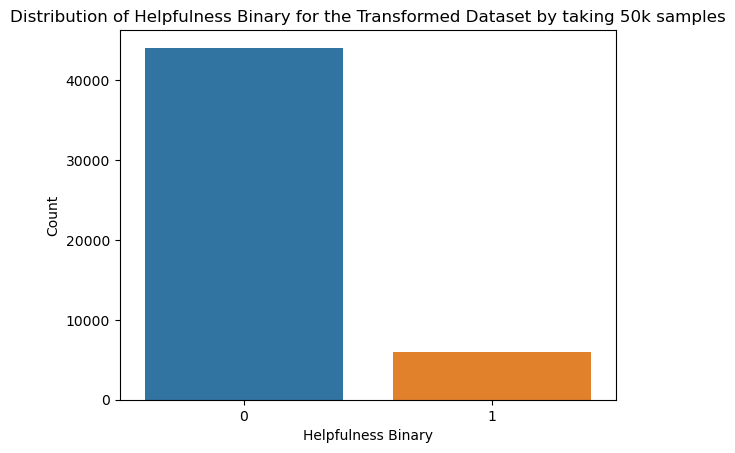

In [50]:
# Plot the distribution of 'helpfulness_binary'
sns.countplot(x='helpfulness_binary', data=tools_df_working_dedup_filter_sample)
plt.title('Distribution of Helpfulness Binary for the Transformed Dataset by taking 50k samples')
plt.xlabel('Helpfulness Binary')
plt.ylabel('Count')
plt.show()

### <font color='blue'>After stratified sampling checking if the distribution of helpfulness is same as the population</font>

In [51]:
# Calculating the total number of entries for sample data
total_entries = len(tools_df_working_dedup_filter_sample)

# Calculating the count'helpfulness_binary' for sample data
helpfulness_counts = tools_df_working_dedup_filter_sample['helpfulness_binary'].value_counts()

# Calculating the percentage of each category for sample data
percentage_1 = (helpfulness_counts[1] / total_entries) * 100
percentage_0 = (helpfulness_counts[0] / total_entries) * 100

# Printing the percentages for sample data
print("Percentage of Helpfulness", percentage_1)
print("Percentage of Not helpfulness", percentage_0)


Percentage of Helpfulness 11.842947435794864
Percentage of Not helpfulness 88.15705256420515


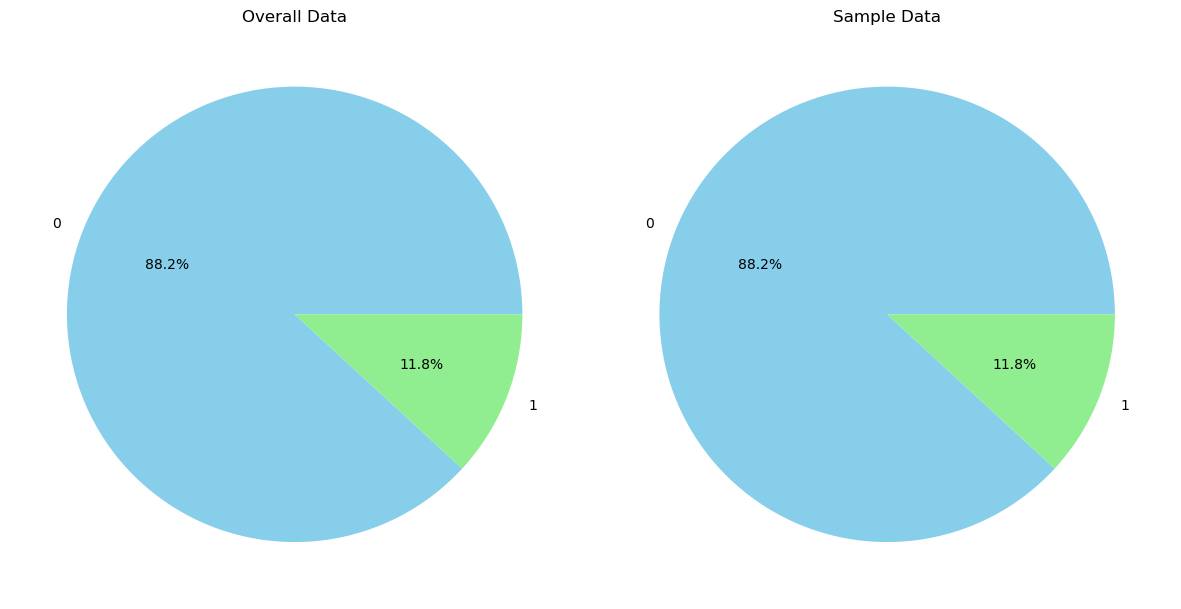

In [52]:
# Calculate counts for each category in the overall Data
overall_counts = tools_df_working_dedup_filter['helpfulness_binary'].value_counts()

# Calculate counts for each category in the sample Data
sample_counts = tools_df_working_dedup_filter_sample['helpfulness_binary'].value_counts()

# Pie Chart
plt.figure(figsize=(12, 6))

# Plot pie chart for the overall Data
plt.subplot(1, 2, 1)
plt.pie(overall_counts, labels=overall_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Overall Data')

# Plot pie chart for the sample Data
plt.subplot(1, 2, 2)
plt.pie(sample_counts, labels=sample_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Sample Data')

plt.tight_layout()
plt.show()

#### <font color='blue'>I can conclude sample data is same as overall population</font>

In [53]:
tools_df_working_dedup_filter_sample.dtypes

overall                        int64
verified                        bool
reviewTime                    object
reviewerID                    object
asin                          object
style                         object
reviewerName                  object
reviewText                    object
summary                       object
unixReviewTime                 int64
vote                          object
image                         object
reviewTime_cleaned    datetime64[ns]
review_year                    int32
review_month                   int32
review_day                     int32
verified_clean                  bool
vote_clean                   float64
image_available                 bool
helpfulness_binary             int64
dtype: object

#### <font color='blue'>Plotting Word distributions and counts of non-word characters in the review text before cleaning process. </font>

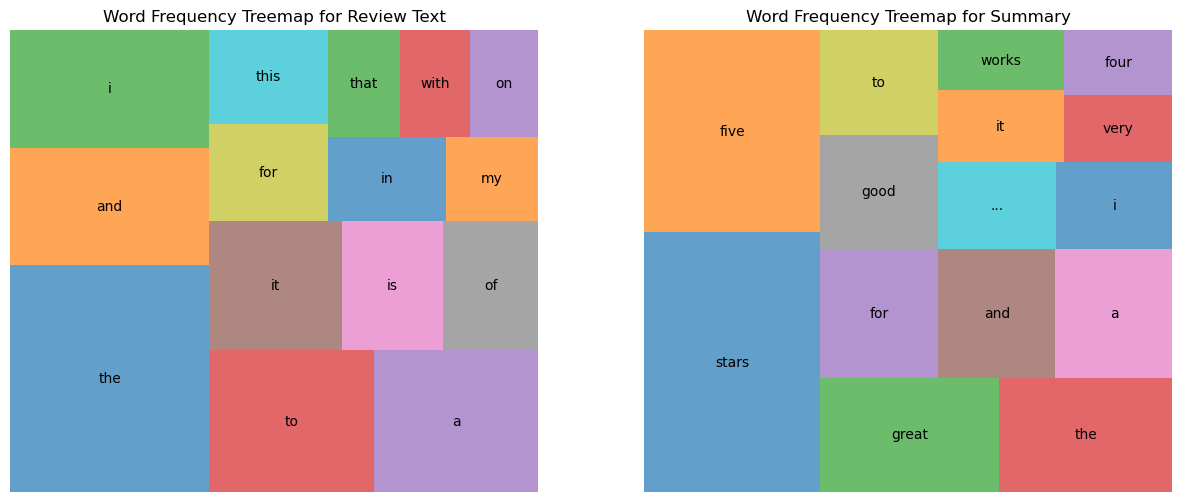

In [54]:
# Word Frequency Treemaps for Review Text and Summary Features

# Setting text and summary parameters
review_text = tools_df_working_dedup_filter_sample["reviewText"]
summary_text = tools_df_working_dedup_filter_sample["summary"]

# Tokenize text data for review text
review_words = ' '.join(review_text).lower().split()

# Calculate word frequencies for review text
review_word_freq = Counter(review_words)

# Tokenize text data for summary
summary_words = ' '.join(summary_text).lower().split()

# Calculate word frequencies for summary
summary_word_freq = Counter(summary_words)

# Get the top N most common words for review text
top_n = 15
most_common_review_words = review_word_freq.most_common(top_n)

# Extract words and frequencies for review text
review_labels = [word[0] for word in most_common_review_words]
review_sizes = [word[1] for word in most_common_review_words]

# Get the top N most common words for summary
most_common_summary_words = summary_word_freq.most_common(top_n)

# Extract words and frequencies for summary
summary_labels = [word[0] for word in most_common_summary_words]
summary_sizes = [word[1] for word in most_common_summary_words]

# Define custom colors for the treemap
custom_colors = sns.color_palette('tab10', n_colors=top_n)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Create treemap for review text
squarify.plot(sizes=review_sizes, label=review_labels, alpha=0.7, color=custom_colors, ax=axes[0])
axes[0].set_title('Word Frequency Treemap for Review Text')

# Create treemap for summary
squarify.plot(sizes=summary_sizes, label=summary_labels, alpha=0.7, color=custom_colors, ax=axes[1])
axes[1].set_title('Word Frequency Treemap for Summary')

# Turn off axis for both plots
for ax in axes:
    ax.axis('off')

# Show plots
plt.show()

<font color='red'>From the above chart, we can see there are lot of irrelevent words, which we call them as stop words</font>

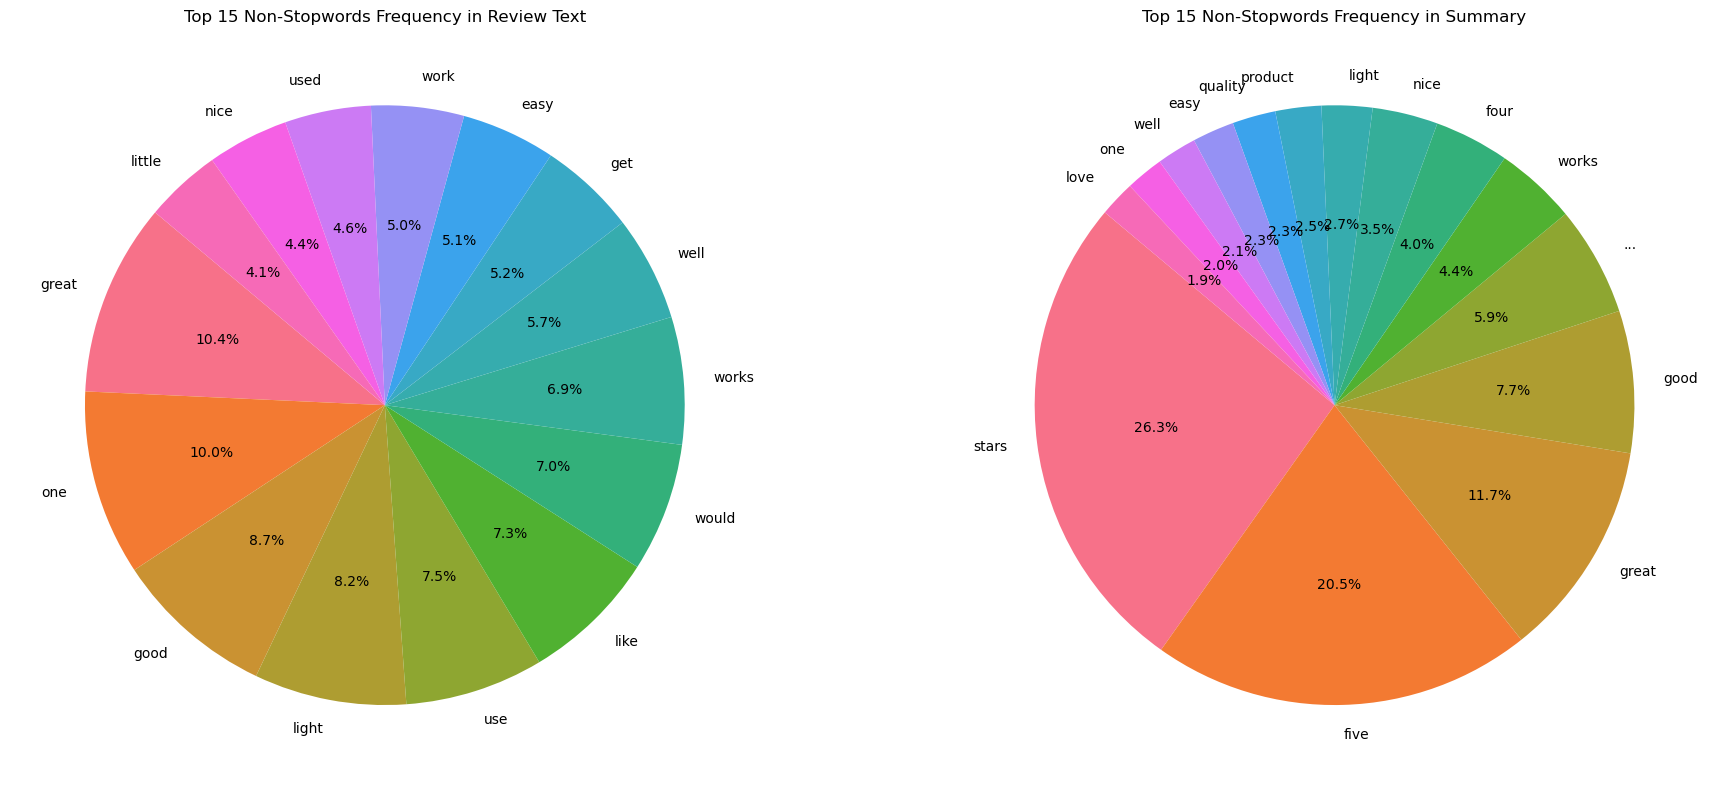

In [55]:
# Plotting the frequency of top 15 words 

# Setting text and summary parameters
review_text = tools_df_working_dedup_filter_sample["reviewText"]
summary_text = tools_df_working_dedup_filter_sample["summary"]

# Tokenize text data for review text
review_words = ' '.join(review_text).lower().split()

# Tokenize text data for summary
summary_words = ' '.join(summary_text).lower().split()

# Get NLTK stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from review text
review_words = [word for word in review_words if word not in stop_words]

# Remove stopwords from summary
summary_words = [word for word in summary_words if word not in stop_words]

# Calculate word frequencies for review text
review_word_freq = Counter(review_words)

# Calculate word frequencies for summary
summary_word_freq = Counter(summary_words)

# Get the top N most common words for review text
top_n = 15
most_common_review_words = review_word_freq.most_common(top_n)

# Get the top N most common words for summary
most_common_summary_words = summary_word_freq.most_common(top_n)

# Extract words and frequencies for review text
review_labels = [word[0] for word in most_common_review_words]
review_sizes = [word[1] for word in most_common_review_words]

# Extract words and frequencies for summary
summary_labels = [word[0] for word in most_common_summary_words]
summary_sizes = [word[1] for word in most_common_summary_words]

custom_palette = sns.color_palette('husl', n_colors=top_n)

# Create pie chart for review text
plt.figure(figsize=(20, 8
                    ))
plt.subplot(1, 2, 1)
plt.pie(review_sizes, labels=review_labels, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Top 15 Non-Stopwords Frequency in Review Text')

# Create pie chart for summary
plt.subplot(1, 2, 2)
plt.pie(summary_sizes, labels=summary_labels, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Top 15 Non-Stopwords Frequency in Summary')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

<font color='red'>Based on the above two visualisations., the highest count for words is for the stop words as compared to the non-stop words in both review text and summary. Therefore, it is important to remove the stop words, and later on we shall see visualisations post removal of stop words.</font>

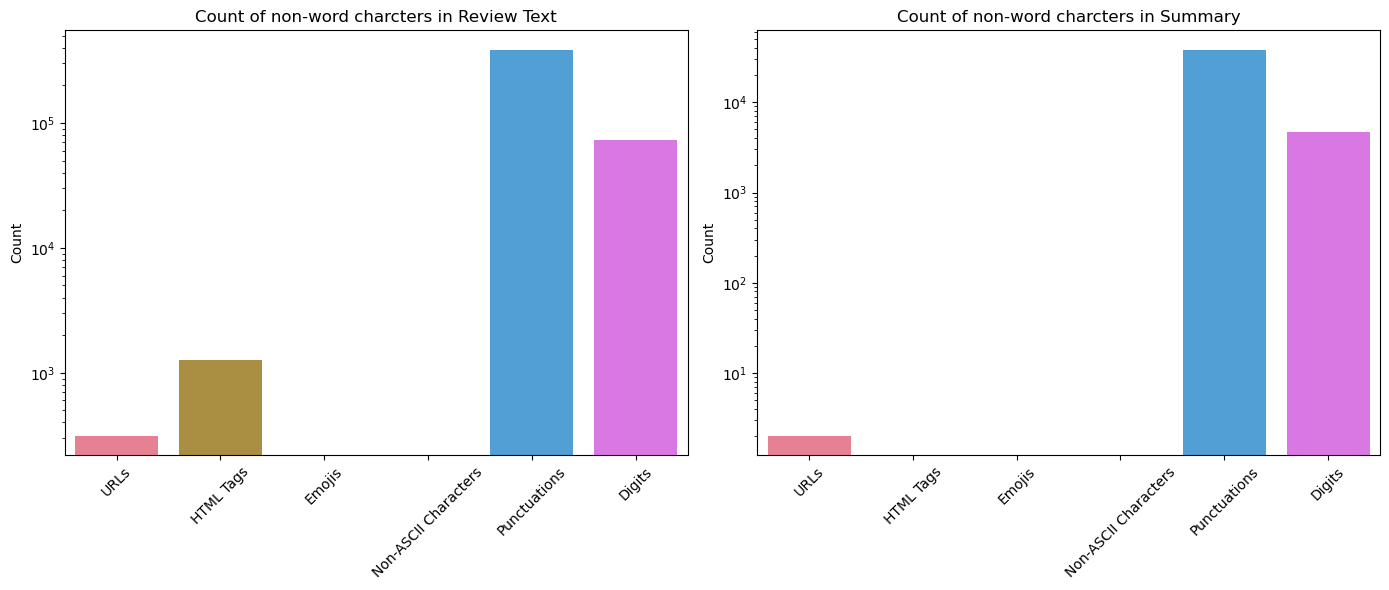

In [56]:
# Plotting the frequency of non word characters in the texts for Summary and Review Text

# Setting text and summary parameters
review_text = tools_df_working_dedup_filter_sample["reviewText"]
summary_text = tools_df_working_dedup_filter_sample["summary"]

# Define regex patterns
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
html_tag_pattern = r'<.*?>'
emoji_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0]+'
non_ascii_pattern = r'[^\x00-\x7F]+'
punctuation_pattern = r'[^\w\s]'
digit_pattern = r'\d'

# Function to count occurrences of patterns in text
def count_occurrences(text, pattern):
    return len(re.findall(pattern, text))

# Count occurrences of patterns in review text
review_counts = {
    "URLs": count_occurrences(' '.join(review_text), url_pattern),
    "HTML Tags": count_occurrences(' '.join(review_text), html_tag_pattern),
    "Emojis": count_occurrences(' '.join(review_text), emoji_pattern),
    "Non-ASCII Characters": count_occurrences(' '.join(review_text), non_ascii_pattern),
    "Punctuations": count_occurrences(' '.join(review_text), punctuation_pattern),
    "Digits": count_occurrences(' '.join(review_text), digit_pattern)
}

# Count occurrences of patterns in summary
summary_counts = {
    "URLs": count_occurrences(' '.join(summary_text), url_pattern),
    "HTML Tags": count_occurrences(' '.join(summary_text), html_tag_pattern),
    "Emojis": count_occurrences(' '.join(summary_text), emoji_pattern),
    "Non-ASCII Characters": count_occurrences(' '.join(summary_text), non_ascii_pattern),
    "Punctuations": count_occurrences(' '.join(summary_text), punctuation_pattern),
    "Digits": count_occurrences(' '.join(summary_text), digit_pattern)
}

# Convert counts to DataFrame for plotting
review_counts_df = pd.DataFrame.from_dict(review_counts, orient='index', columns=['Count'])
summary_counts_df = pd.DataFrame.from_dict(summary_counts, orient='index', columns=['Count'])


# Plot counts for review text
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=review_counts_df.index, y='Count', data=review_counts_df, palette='husl')
plt.title('Count of non-word charcters in Review Text')
plt.xticks(rotation=45)
plt.yscale('log')

# Plot counts for summary
plt.subplot(1, 2, 2)
sns.barplot(x=summary_counts_df.index, y='Count', data=summary_counts_df, palette='husl')
plt.title('Count of non-word charcters in Summary')
plt.xticks(rotation=45)
plt.yscale('log')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


<font color='red'>From the above visualization we see that a lot of non-word characters are also there in the review text and columns like emojis, numeric characters, punctuations etc. We don't need any of these as they are not useful for our modelling. We will clean them before feature engineering.</font>

## <font color='purple'><b>Feature engineering</b></font>

<font color='purple'>
#### <b>1) Review title (summary) metadata:</b>
1a) # words in title

1b) # length of original title

1c) Similarity of title and review text (using cosine similarity or related method)(This is optional as it is computational expensive)

1d) Title sentiment

1e) Unique word count

1f) Emoji & non-ASCII character count

1g) Term frequency/TFIDF of the cleaned title with prefix of title if summary is not similar to text (might be tricky to do)


#### <b>2) Review text (reviewText) metadata:</b>
2a) # words in review

2b) # length of original review

2c) Review sentiment

2d) Unique word count

2e) URL availability inside reviewtext

2f) Stop word count  

2g) Emoji & non-ASCII character count

#### <b>4) Active reviewer - does the reviewer ID have multiple reviews? 1 if yes, 0 otherwise</b>
Active reviewer can be removed 


#### <b>5) Age of review: (end of 2018 - review posted date) = review age in days</b>


#### <b>6) Review text cleaning:</b>
6a) convert reviewtext to lowercase, remove double spaces, punctuations, numbers

6c) Remove URLs, stopwords (standard and custom), non-ASCII characters, emojis and other non-printable characters

6d) Remove sparse words

6e) lemmatization

6f) n-grams: Check for top unigrams and bigrams - study distributions
</font>

In [57]:
# Function definitions

# Function for number of words in input text
def num_words(text):
    return len(word_tokenize(text))

# Function to get length of input text
def text_length(text):
    return len(text)

# Cosine similarity between 2 input texts: this may be computationally expensive
# Cosine similarity between title and review text is calculated using TF-IDF
def cosine_similarity(title, review):
    vectorizer = TfidfVectorizer()
    tf_idf_matrix = vectorizer.fit_transform([title, review])
    return (tf_idf_matrix * tf_idf_matrix.T).toarray()[0][1]

# Sentiment polarity
# <0 indicates negative sentiment
# 0 indicates netural
# >0 indicates positive sentiment
def text_sentiment(title):
    blob = TextBlob(title)
    return blob.sentiment.polarity

# Function to get count of unique words in the input text
def unique_word_count(text):
    return len(set(word_tokenize(text)))

# Function to get count of emojis and non-ASCII characters in input text
def emoji_and_non_ascii_count(text):
    count = 0
    for char in text:
        if (char in emoji.UNICODE_EMOJI or not char.isascii()):
            count += 1
    return count

# If UNICODE_EMOJI isn't getting installed, use this version of the function
# This uses a regex pattern to capture non-alphanumeric characters
def emoji_and_non_ascii_count_v2(text):
    emoji_pattern = r"[^a-zA-Z0-9\s+\.\!]"
    return len(re.findall(emoji_pattern, text))

# Function to count the number of URLs inside the input text
def url_count(text):
    url_pattern = r"http[s]?://\S+"  # Regular expression for URLs
    return len(re.findall(url_pattern, text))

# Function to count the number of English stopwords in the input text
def stopword_count(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return sum(word in stop_words for word in words)


In [58]:
# Creating features 1a - 1f

# 1a: Number of words in the title
tools_df_working_dedup_filter_sample['num_words_review_title'] = tools_df_working_dedup_filter_sample['summary'].apply(num_words)
# 1b. length of original title
tools_df_working_dedup_filter_sample['title_length'] = tools_df_working_dedup_filter_sample['summary'].apply(text_length)

# 1d: Sentiment polarity
tools_df_working_dedup_filter_sample['title_sentiment'] = tools_df_working_dedup_filter_sample['summary'].apply(text_sentiment)

# 1e: Unique word count
tools_df_working_dedup_filter_sample['unique_word_count_title'] = tools_df_working_dedup_filter_sample['summary'].apply(unique_word_count)

# 1f: Emoji & non-ASCII character count
#tools_df_working_dedup['emoji_non_ascii_count_title'] = tools_df_working_dedup['summary'].apply(emoji_and_non_ascii_count)

# 1f: Emoji & non-ASCII character count v2
tools_df_working_dedup_filter_sample['emoji_non_ascii_count_title'] = tools_df_working_dedup_filter_sample['summary'].apply(emoji_and_non_ascii_count_v2)


# Check
tools_df_working_dedup_filter_sample.shape

(49996, 25)

In [59]:
# Creating features 2a - 2g

# 2a: Number of words in the review
tools_df_working_dedup_filter_sample['num_words_review_text'] = tools_df_working_dedup_filter_sample['reviewText'].apply(num_words)

# 2b. length of original review
tools_df_working_dedup_filter_sample['review_length'] = tools_df_working_dedup_filter_sample['reviewText'].apply(text_length)

# 2c: Sentiment polarity of review
tools_df_working_dedup_filter_sample['review_sentiment'] = tools_df_working_dedup_filter_sample['reviewText'].apply(text_sentiment)

# 2d: Unique word count
tools_df_working_dedup_filter_sample['unique_word_count_review'] = tools_df_working_dedup_filter_sample['reviewText'].apply(unique_word_count)

# 2e: URL count inside reviewtext
tools_df_working_dedup_filter_sample['url_count_review'] = tools_df_working_dedup_filter_sample['reviewText'].apply(url_count)

# 2f: Stop word count
tools_df_working_dedup_filter_sample['stop_word_count_review'] = tools_df_working_dedup_filter_sample['reviewText'].apply(stopword_count)

# 2g: Emoji & non-ASCII character count
tools_df_working_dedup_filter_sample['emoji_non_ascii_count_title'] = tools_df_working_dedup_filter_sample['reviewText'].apply(emoji_and_non_ascii_count_v2)

# Check
print(tools_df_working_dedup_filter_sample.shape)

(49996, 31)


In [60]:
tools_df_working_dedup_filter_sample

overall  verified   reviewTime      reviewerID        asin  \
339092         5     False  01 28, 2010  A13ZVFDFZFTXFJ  B000NJJ1TY   
150265         5      True  01 26, 2010  A29CLPS7BD39RE  B00099DG8A   
357087         5     False  01 22, 2010  A1P2HZ2H4L1BBK  B000O3LUEI   
56548          1      True  01 17, 2010  A1EPP56A17R62Q  B00005202H   
31388          1     False  01 12, 2010  A32G4AR56VP4YN  B0000302X8   
...          ...       ...          ...             ...         ...   
1379827        1      True  06 29, 2018  A3HECKTTOF40B5  B00KVS8IVY   
1564148        5      True  07 11, 2018  A1O07QCN2GZYHF  B00WGOHVOQ   
1573986        3      True   07 5, 2018  A3NJ6T4ABWLJPX  B00X725XMI   
1780654        5      True  07 24, 2018  A19KQ0X1YNKASJ  B01DTE0WLK   
2069378        5      True  08 23, 2018  A15ANIO9E0B20I  B01GX2GKDY   

                                                     style  \
339092   {'Color Name:': ' Antique Brass', 'Package Typ...   
150265                                                 NaN   
357087             {'Style Name:': ' Multimeter Standard'}   
56548                                                  NaN   
31388                                                  NaN   
...                                                    ...   
1379827                               {'Size:': ' 1 Pack'}   
1564148               {'Style:': ' Garage Controller Kit'}   
1573986                                                NaN   
1780654                       {'Size Name:': ' 5Pk Angle'}   
2069378                  {'Color:': ' Brushed Nickel 13L'}   

               reviewerName  \
339092            Don Lewis   
150265     Thomas F. Goettl   
357087           Dr Markway   
56548                Tommie   
31388    Michael J. Casteel   
...                     ...   
1379827             Patriot   
1564148            Steve S.   
1573986         Tom Pittlik   
1780654     Amazon Customer   
2069378      richard eigner   

                                                reviewText  \
339092   The lock works extremely well.  It is one of t...   
150265   We used this unit in my moms house afer she pa...   
357087   If there was a "Master Electrician" I was it. ...   
56548    These are probably very good door sweeps but t...   
31388    I bought one of these based on the positive re...   
...                                                    ...   
1379827  Installed in household garage, which routinely...   
1564148  Used this to replace a Chamberlain MyQ that ha...   
1573986  Tamper proofing is not well implemented. If yo...   
1780654  Congratulations!!! The BEST paint brush I have...   
2069378                          Worth the money very nice   

                                                   summary  unixReviewTime  \
339092                       Great lock - buy it at Lowe's      1264636800   
150265                                   The perfect watch      1264464000   
357087                                  Master Electrician      1264118400   
56548                               Too short for my doors      1263686400   
31388                               Useless waste of money      1263254400   
...                                                    ...             ...   
1379827                                  NOT FOR GARAGE...      1530230400   
1564148                  Seems to work really well so far.      1531267200   
1573986  Tamper proofing is not well implemented. If yo...      1530748800   
1780654                             this brush works hard.      1532390400   
2069378                               Worth the money very      1534982400   

         ... title_length title_sentiment unique_word_count_title  \
339092   ...           29        0.800000                       8   
150265   ...           17        1.000000                       3   
357087   ...           18        0.000000                       2   
56548    ...           22        0.000000                       5   
31388    ..

In [61]:
tools_df_working_dedup_filter_sample.isnull().sum()

overall                            0
verified                           0
reviewTime                         0
reviewerID                         0
asin                               0
style                          24085
reviewerName                       9
reviewText                         0
summary                            0
unixReviewTime                     0
vote                           43141
image                          48898
reviewTime_cleaned                 0
review_year                        0
review_month                       0
review_day                         0
verified_clean                     0
vote_clean                         0
image_available                    0
helpfulness_binary                 0
num_words_review_title             0
title_length                       0
title_sentiment                    0
unique_word_count_title            0
emoji_non_ascii_count_title        0
num_words_review_text              0
review_length                      0
r

In [62]:
# 5) Age of review: (end of 2018 - review posted date) = review age in days

# Calculating the end date of 2018 as the reference date since the dataset is as of 2018
end_of_2018 = datetime(2018, 12, 31)

# Converting datetime64[ns] to pandas datetime
if pd.api.types.is_datetime64_dtype(tools_df_working_dedup_filter_sample['reviewTime_cleaned']):
    tools_df_working_dedup_filter_sample['reviewTime_cleaned'] = pd.to_datetime(tools_df_working_dedup_filter_sample['reviewTime_cleaned'])

# Calculating the age in days
tools_df_working_dedup_filter_sample['review_age_days'] = (end_of_2018 - tools_df_working_dedup_filter_sample['reviewTime_cleaned']).dt.days


In [63]:
# Check
tools_df_working_dedup_filter_sample.shape

(49996, 32)

In [64]:
# 6: Text cleaning

# Defining a master function that will do the following for a provided input text:
# 6a) Lowercase and remove double spaces
# 6b) Expand contractions
# 6c) Remove unwanted characters, numbers, punctuations

# 6a) Lowercase and remove double spaces
def remove_urls_html_tags(text):
    pattern = r"https?://\S+|www\.\S+|<.*?>"
    return re.sub(pattern, "", text, flags=re.MULTILINE)

# 6b) Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# 6c) Remove unwanted characters, numbers, punctuations
def remove_non_ascii_and_emojis(text):
    emoji_pattern = re.compile(
        r'['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', re.sub(r'[^\x00-\x7F]+', r'', text))

# Remove punctuations & Numbers
def remove_punctuations_and_digits(text):
    translation_table = str.maketrans('', '', string.punctuation + string.digits)
    return text.translate(translation_table)

# Resolving acronyms and abbreviations - add more as required
def expand_acronyms_and_abbreviations(text):
    acronyms_abbrs = {
        "tbh": "to be honest",
        "2mw": "tomorrow",
        "lol": "laugh out loud",
        "fyi": "for your information",
        "acct": "account",
        "adih": "another day in hell",
        "afaic": "as far as i am concerned",
        "afaict": "as far as i can tell",
        "afaik": "as far as i know",
        "afair": "as far as i remember",
        "afk": "away from keyboard",
        "gr8": "great",
        "omg": "oh my god",
        "omw": "on my way"
    }

    for acronym, full_form in acronyms_abbrs.items():
        text = text.replace(acronym, full_form)

    return text

# Custom stopwords (add to list here as required)
# Remove stopwords
def remove_stopwords(text):
    custom_stopwords = ["amazon"]
    stop_words = stopwords.words("english") + custom_stopwords
    return " ".join([word for word in text.split() if word not in stop_words])

def clean_text_master_function_v2(text):
    text = text.lower()
    text = text.replace("  ", " ")  # Remove double spaces
    text = remove_urls_html_tags(text)
    text = remove_non_ascii_and_emojis(text)
    text = remove_punctuations_and_digits(text)
    text = expand_contractions(text)
    text = expand_acronyms_and_abbreviations(text)
    text = remove_stopwords(text)
    return text


In [65]:
# Applying the cleaning function to the reviewText column
tools_df_working_dedup_filter_sample['review_text_clean'] = tools_df_working_dedup_filter_sample['reviewText'].apply(clean_text_master_function_v2)

In [66]:
tools_df_working_dedup_filter_sample['review_text_clean'].shape

(49996,)

In [67]:
tools_df_working_dedup_filter_sample.isnull().sum()

overall                            0
verified                           0
reviewTime                         0
reviewerID                         0
asin                               0
style                          24085
reviewerName                       9
reviewText                         0
summary                            0
unixReviewTime                     0
vote                           43141
image                          48898
reviewTime_cleaned                 0
review_year                        0
review_month                       0
review_day                         0
verified_clean                     0
vote_clean                         0
image_available                    0
helpfulness_binary                 0
num_words_review_title             0
title_length                       0
title_sentiment                    0
unique_word_count_title            0
emoji_non_ascii_count_title        0
num_words_review_text              0
review_length                      0
r

### <font color='blue'>Visualizing the data Post Cleaning and Stop word Removal</font>

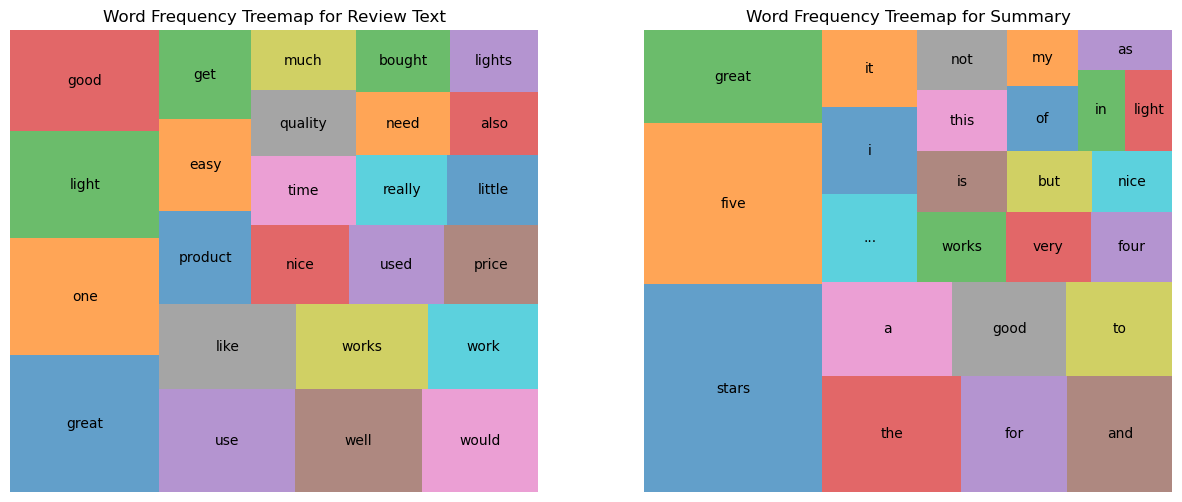

In [68]:
# Plotting Treemaps for Cleaned Review Text and Summary

# Setting text and summary parameters
review_text = tools_df_working_dedup_filter_sample["review_text_clean"]
summary_text = tools_df_working_dedup_filter_sample["summary"]

# Tokenize text data for review text
review_words = ' '.join(review_text).lower().split()

# Calculate word frequencies for review text
review_word_freq = Counter(review_words)

# Tokenize text data for summary
summary_words = ' '.join(summary_text).lower().split()

# Calculate word frequencies for summary
summary_word_freq = Counter(summary_words)

# Get the top N most common words for review text
top_n = 25
most_common_review_words = review_word_freq.most_common(top_n)

# Extract words and frequencies for review text
review_labels = [word[0] for word in most_common_review_words]
review_sizes = [word[1] for word in most_common_review_words]

# Get the top N most common words for summary
most_common_summary_words = summary_word_freq.most_common(top_n)

# Extract words and frequencies for summary
summary_labels = [word[0] for word in most_common_summary_words]
summary_sizes = [word[1] for word in most_common_summary_words]

# Define custom colors for the treemap
custom_colors = sns.color_palette('tab10', n_colors=top_n)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Create treemap for review text
squarify.plot(sizes=review_sizes, label=review_labels, alpha=0.7, color=custom_colors, ax=axes[0])
axes[0].set_title('Word Frequency Treemap for Review Text')

# Create treemap for summary
squarify.plot(sizes=summary_sizes, label=summary_labels, alpha=0.7, color=custom_colors, ax=axes[1])
axes[1].set_title('Word Frequency Treemap for Summary')

# Turn off axis for both plots
for ax in axes:
    ax.axis('off')

# Show plots
plt.show()

<font color='green'>We can observe from the above chart that the stop words have been removed</font>

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shitgupt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


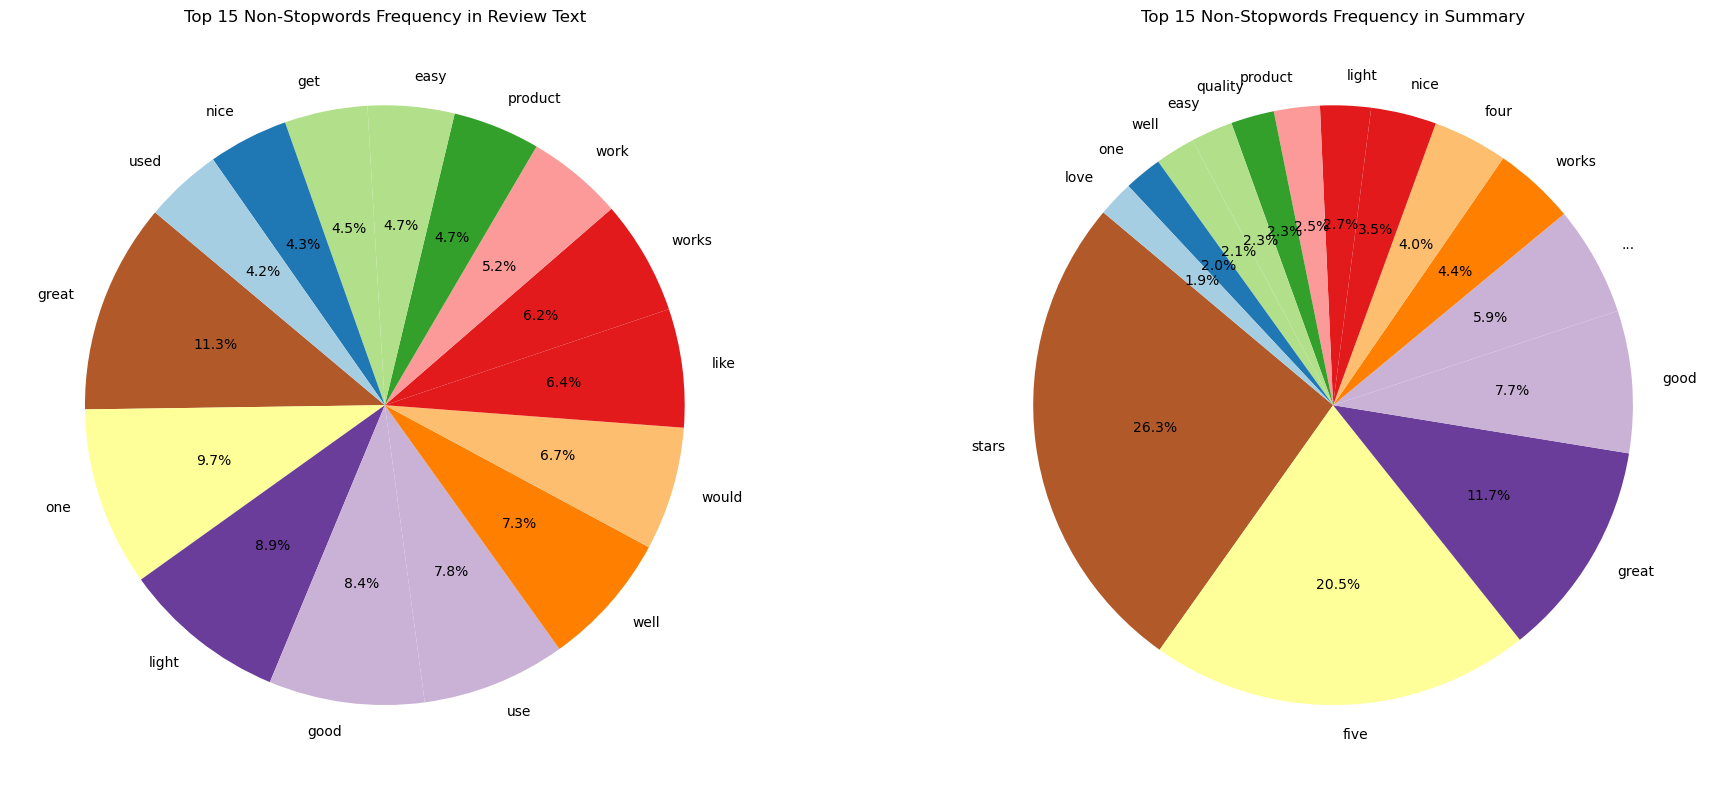

In [69]:
# Plotting word frequency for top 15 words

# Download NLTK stopwords
nltk.download('stopwords')

# Setting text and summary parameters
review_text = tools_df_working_dedup_filter_sample["review_text_clean"]
summary_text = tools_df_working_dedup_filter_sample["summary"]

# Tokenize text data for review text
review_words = ' '.join(review_text).lower().split()

# Tokenize text data for summary
summary_words = ' '.join(summary_text).lower().split()

# Get NLTK stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from review text
review_words = [word for word in review_words if word not in stop_words]

# Remove stopwords from summary
summary_words = [word for word in summary_words if word not in stop_words]

# Calculate word frequencies for review text
review_word_freq = Counter(review_words)

# Calculate word frequencies for summary
summary_word_freq = Counter(summary_words)

# Get the top N most common words for review text
top_n = 15
most_common_review_words = review_word_freq.most_common(top_n)

# Get the top N most common words for summary
most_common_summary_words = summary_word_freq.most_common(top_n)

# Extract words and frequencies for review text
review_labels = [word[0] for word in most_common_review_words]
review_sizes = [word[1] for word in most_common_review_words]

# Extract words and frequencies for summary
summary_labels = [word[0] for word in most_common_summary_words]
summary_sizes = [word[1] for word in most_common_summary_words]

custom_palette = sns.color_palette('Paired_r', n_colors=top_n)

# Create pie chart for review text
plt.figure(figsize=(20, 8
                    ))
plt.subplot(1, 2, 1)
plt.pie(review_sizes, labels=review_labels, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Top 15 Non-Stopwords Frequency in Review Text')

# Create pie chart for summary
plt.subplot(1, 2, 2)
plt.pie(summary_sizes, labels=summary_labels, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Top 15 Non-Stopwords Frequency in Summary')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

<font color='green'> The top 15 words are no longer stop words after cleaning</font>

/var/folders/07/qch9szx51kdgzhzp77njqrqw001f2_/T/ipykernel_51037/3774982062.py:48: UserWarning:

Data has no positive values, and therefore cannot be log-scaled.



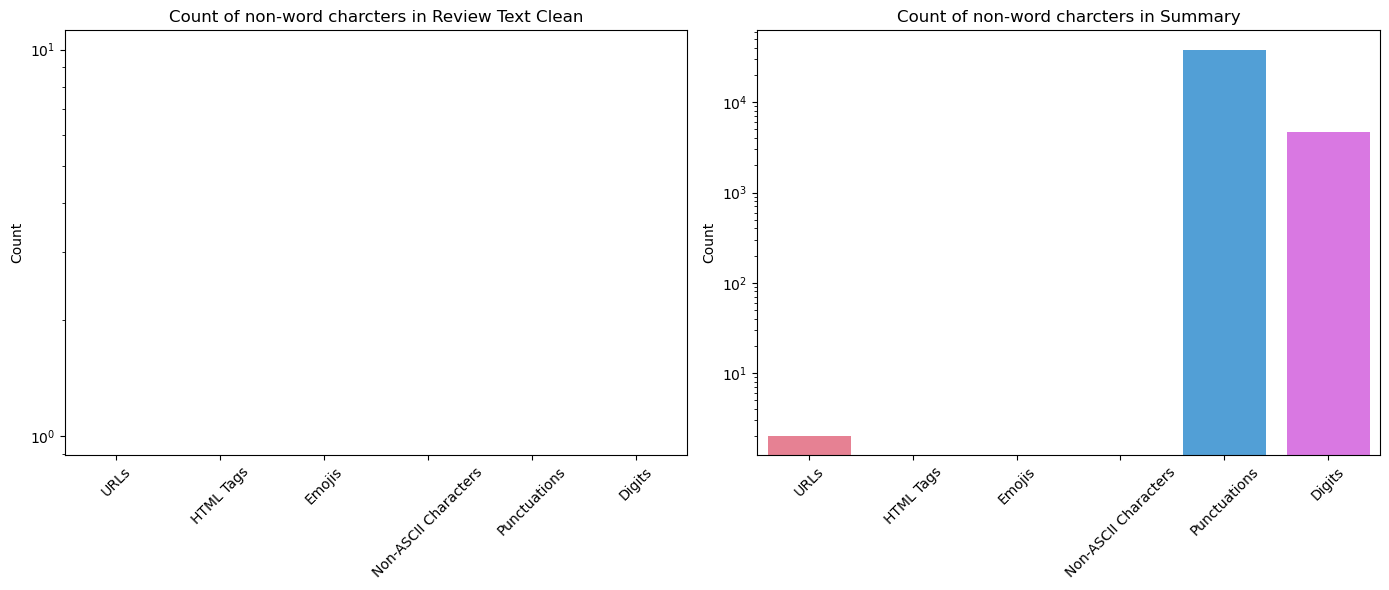

In [70]:
# Setting text and summary parameters
review_text = tools_df_working_dedup_filter_sample["review_text_clean"]
summary_text = tools_df_working_dedup_filter_sample["summary"]

# Define regex patterns
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
html_tag_pattern = r'<.*?>'
emoji_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0]+'
non_ascii_pattern = r'[^\x00-\x7F]+'
punctuation_pattern = r'[^\w\s]'
digit_pattern = r'\d'

# Function to count occurrences of patterns in text
def count_occurrences(text, pattern):
    return len(re.findall(pattern, text))

# Count occurrences of patterns in review text
review_counts = {
    "URLs": count_occurrences(' '.join(review_text), url_pattern),
    "HTML Tags": count_occurrences(' '.join(review_text), html_tag_pattern),
    "Emojis": count_occurrences(' '.join(review_text), emoji_pattern),
    "Non-ASCII Characters": count_occurrences(' '.join(review_text), non_ascii_pattern),
    "Punctuations": count_occurrences(' '.join(review_text), punctuation_pattern),
    "Digits": count_occurrences(' '.join(review_text), digit_pattern)
}

# Count occurrences of patterns in summary
summary_counts = {
    "URLs": count_occurrences(' '.join(summary_text), url_pattern),
    "HTML Tags": count_occurrences(' '.join(summary_text), html_tag_pattern),
    "Emojis": count_occurrences(' '.join(summary_text), emoji_pattern),
    "Non-ASCII Characters": count_occurrences(' '.join(summary_text), non_ascii_pattern),
    "Punctuations": count_occurrences(' '.join(summary_text), punctuation_pattern),
    "Digits": count_occurrences(' '.join(summary_text), digit_pattern)
}

# Convert counts to DataFrame for plotting
review_counts_df = pd.DataFrame.from_dict(review_counts, orient='index', columns=['Count'])
summary_counts_df = pd.DataFrame.from_dict(summary_counts, orient='index', columns=['Count'])


# Plot counts for review text
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=review_counts_df.index, y='Count', data=review_counts_df, palette='husl')
plt.title('Count of non-word charcters in Review Text Clean')
plt.xticks(rotation=45)
plt.yscale('log')

# Plot counts for summary
plt.subplot(1, 2, 2)
sns.barplot(x=summary_counts_df.index, y='Count', data=summary_counts_df, palette='husl')
plt.title('Count of non-word charcters in Summary')
plt.xticks(rotation=45)
plt.yscale('log')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

<font color='green'>As we can see from the above visualizations, post cleaning, the stop words are gone from the Cleaned Review text. We did not perform cleaning on Summary column as we don't need that to generate our features. The cleaned review text also does not have any URLs, html tags, digits, non-ascii characters or emojis. </font>

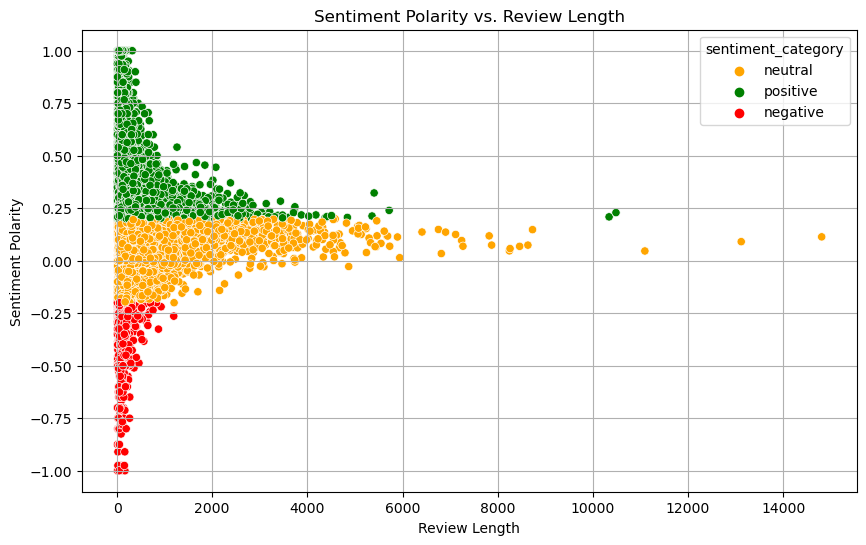

In [71]:
# Plotting a scatter plot of sentiment polarity vs. review length with color-coded polarity

review_data = tools_df_working_dedup_filter_sample  # Assuming you have a DataFrame containing review data

# Define thresholds for positive, negative, and neutral sentiment
positive_threshold = 0.2
negative_threshold = -0.2

# Function to categorize sentiment polarity based on thresholds
def categorize_sentiment(polarity):
    if polarity >= positive_threshold:
        return 'positive'
    elif polarity <= negative_threshold:
        return 'negative'
    else:
        return 'neutral'

# Categorize sentiment based on polarity thresholds
review_data['sentiment_category'] = review_data['review_sentiment'].apply(categorize_sentiment)

# Plot scatter plot of sentiment polarity vs. review length with color-coded polarity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=review_data, x='review_length', y='review_sentiment', hue='sentiment_category', palette={'positive': 'green', 'negative': 'red', 'neutral': 'orange'})
plt.title('Sentiment Polarity vs. Review Length')
plt.xlabel('Review Length')
plt.ylabel('Sentiment Polarity')
plt.grid(True)
plt.show()

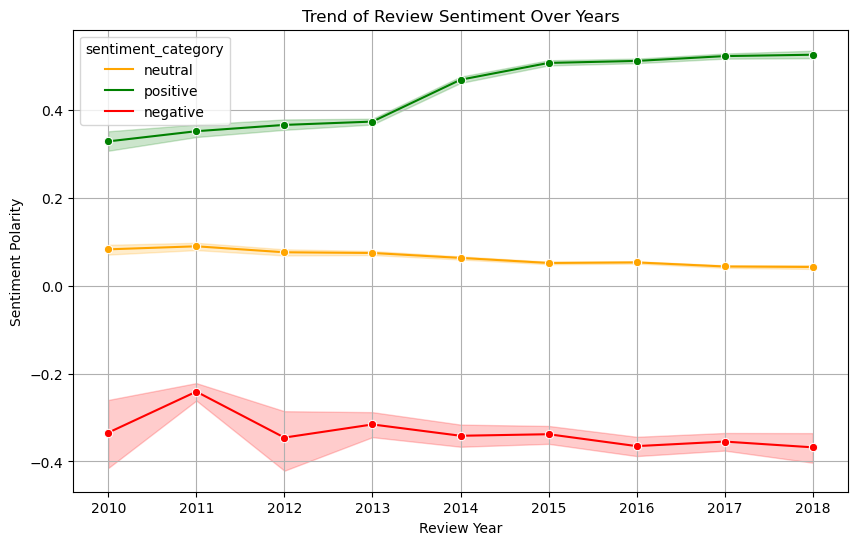

In [72]:
# Plotting a line plot of sentiment polarity over the years with color-coded sentiment categories

review_data = tools_df_working_dedup_filter_sample  # Assuming you have a DataFrame containing review data

# Function to get sentiment category based on polarity
def get_sentiment_category(polarity):
    if polarity <= -0.2:
        return 'negative'
    elif polarity >= 0.2:
        return 'positive'
    else:
        return 'neutral'
    
# Define custom color palette
custom_palette = {'positive': 'green', 'negative': 'red', 'neutral': 'orange'}

# Categorize sentiment polarity into positive, negative, and neutral
review_data['sentiment_category'] = review_data['review_sentiment'].apply(get_sentiment_category)

# Plot distinct lines for positive, negative, and neutral sentiment scores over the years
plt.figure(figsize=(10, 6))
sns.lineplot(data=review_data, x='review_year', y='review_sentiment', hue='sentiment_category', palette=custom_palette, marker='o')
plt.title('Trend of Review Sentiment Over Years')
plt.xlabel('Review Year')
plt.ylabel('Sentiment Polarity')
plt.grid(True)
plt.show()


### <font color='blue'> Performing Lemmatization on the Review text Column</font>

In [73]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)  # Tokenize text into words
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize each token
    return ' '.join(lemmatized_tokens)  # Join lemmatized tokens into a single string

In [74]:
# Apply stemming and lemmatization as new columns
tools_df_working_dedup_filter_sample['review_text_clean_lemmatized'] = tools_df_working_dedup_filter_sample['review_text_clean'].apply(lemmatize_text)

In [75]:
print(tools_df_working_dedup_filter_sample['review_text_clean_lemmatized'])

339092     lock work extremely well one one found relocks...
150265     used unit mom house afer passed away mom neigh...
357087     master electrician pretty braggy ran work owne...
56548      probably good door sweep short opening door go...
31388      bought one based positive review assume writte...
                                 ...                        
1379827    installed household garage routinely get degre...
1564148    used replace chamberlain myq nothing problem s...
1573986    tamper proofing well implemented need provide ...
1780654    congratulation best paint brush ever used appl...
2069378                                     worth money nice
Name: review_text_clean_lemmatized, Length: 49996, dtype: object


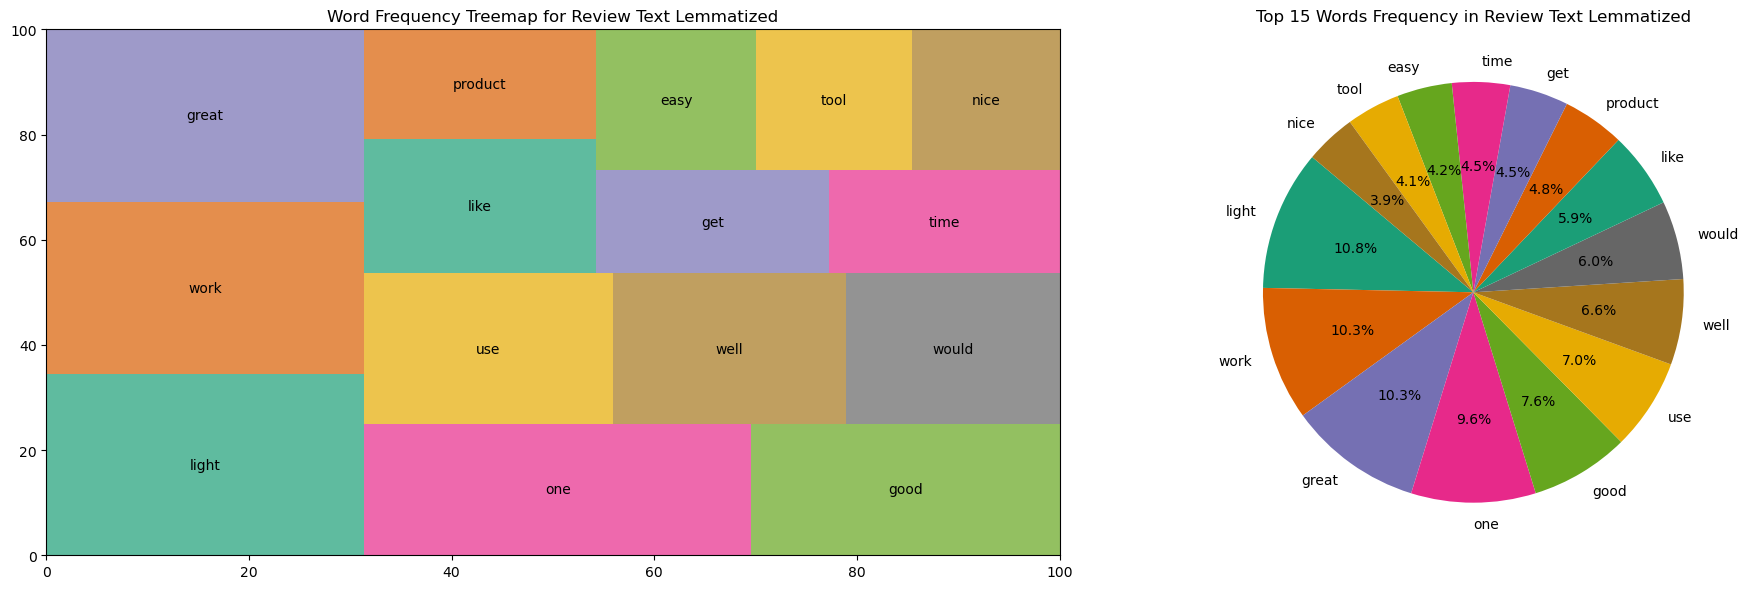

In [76]:
# Plotting Word Frequency Treemaps for Review Text Lemmatized

# Setting text parameter
review_text_lemmatized = tools_df_working_dedup_filter_sample["review_text_clean_lemmatized"]

# Tokenize text data for review text
review_words = ' '.join(review_text_lemmatized).lower().split()

# Get NLTK stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from review text
review_words = [word for word in review_words if word not in stop_words]

# Calculate word frequencies for review text
review_word_freq = Counter(review_words)

# Get the top N most common words for review text
top_n = 15
most_common_review_words = review_word_freq.most_common(top_n)

# Extract words and frequencies for review text
review_labels = [word[0] for word in most_common_review_words]
review_sizes = [word[1] for word in most_common_review_words]

custom_palette = sns.color_palette('Dark2', n_colors=top_n)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Create treemap for review text
squarify.plot(sizes=review_sizes, label=review_labels, alpha=0.7, color=custom_palette, ax=axes[0])
axes[0].set_title('Word Frequency Treemap for Review Text Lemmatized')

# Create pie chart for review text
axes[1].pie(review_sizes, labels=review_labels, autopct='%1.1f%%', startangle=140, colors=custom_palette)
axes[1].set_title('Top 15 Words Frequency in Review Text Lemmatized')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

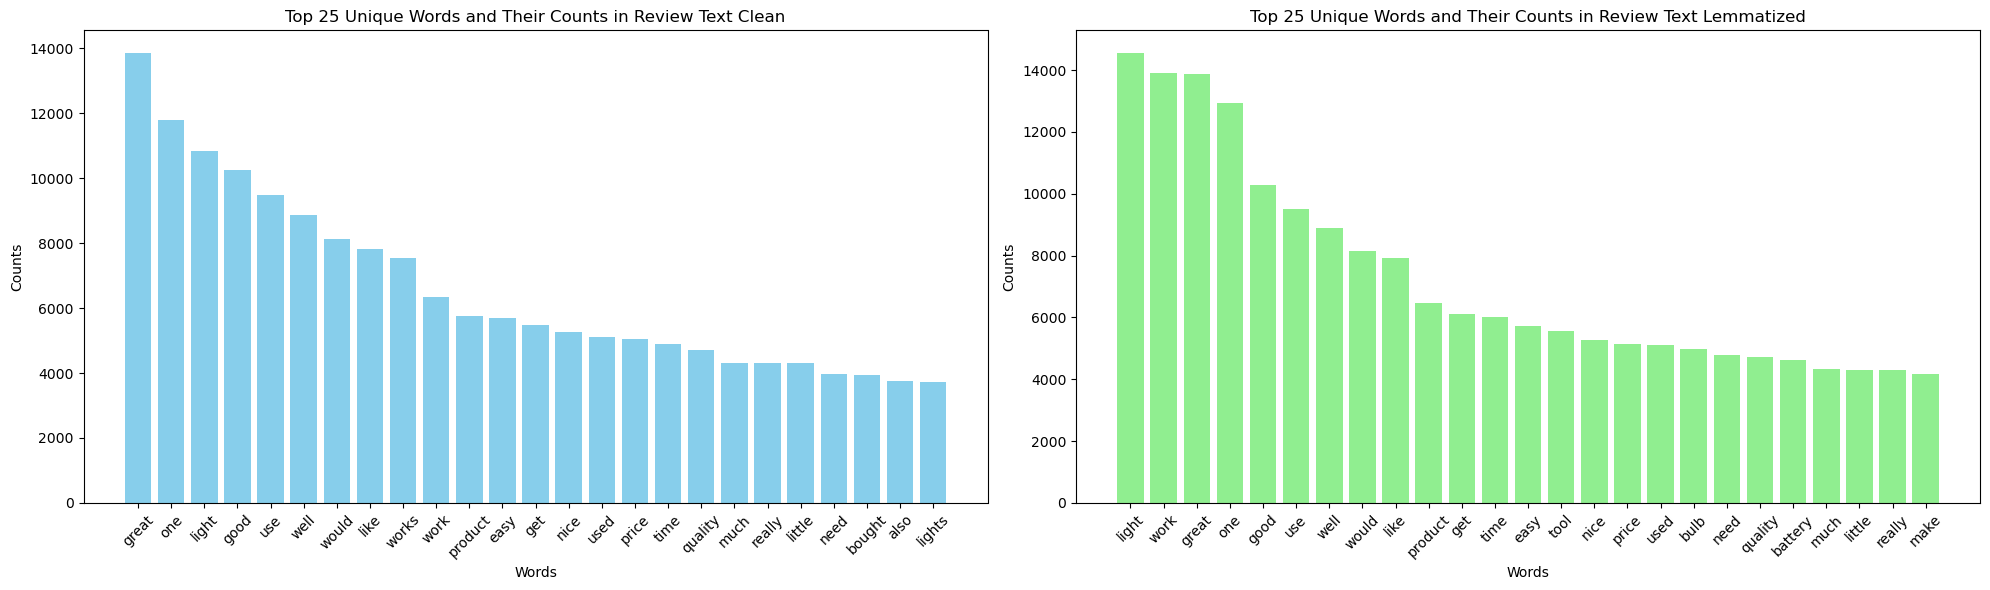

In [77]:
# Plotting word frequency for top 15 words in Review Text Clean and Review Text Lemmatized

# Setting text parameters
review_text_clean = tools_df_working_dedup_filter_sample["review_text_clean"]
review_text_lemmatized = tools_df_working_dedup_filter_sample["review_text_clean_lemmatized"]

# Tokenize text data for review text clean
review_clean_words = ' '.join(review_text_clean).lower().split()

# Tokenize text data for review text lemmatized
review_lemmatized_words = ' '.join(review_text_lemmatized).lower().split()

# Get NLTK stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from review text clean
review_clean_words = [word for word in review_clean_words if word not in stop_words]

# Remove stopwords from review text lemmatized
review_lemmatized_words = [word for word in review_lemmatized_words if word not in stop_words]

# Calculate word frequencies for review text clean
review_clean_word_freq = Counter(review_clean_words)

# Calculate word frequencies for review text lemmatized
review_lemmatized_word_freq = Counter(review_lemmatized_words)

# Create DataFrames for each word frequency counter
df_clean = pd.DataFrame(review_clean_word_freq.items(), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)
df_lemmatized = pd.DataFrame(review_lemmatized_word_freq.items(), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)

# Display side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot review text clean
axes[0].bar(df_clean['Word'][:25], df_clean['Count'][:25], color='skyblue')
axes[0].set_title('Top 25 Unique Words and Their Counts in Review Text Clean')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Counts')
axes[0].tick_params(axis='x', rotation=45)

# Plot review text lemmatized
axes[1].bar(df_lemmatized['Word'][:25], df_lemmatized['Count'][:25], color='lightgreen')
axes[1].set_title('Top 25 Unique Words and Their Counts in Review Text Lemmatized')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Counts')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


<font color='green'>Post lemmatization we don't see a lot of difference between the review text data, <b>so we will proceed with modelling used cleaned review text instead of lemmatized text.</b> Also, we have dropped the idea of stemming as it was introducing a lot of typos.<font>

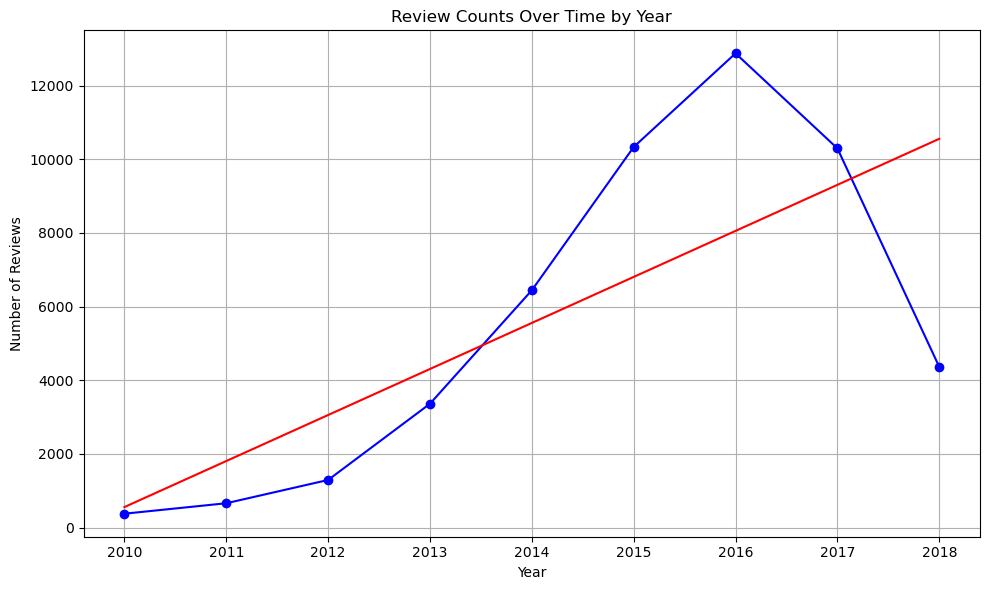

In [78]:
# Plotting a scatter plot of sentiment polarity vs. review length with color-coded polarity

# Group by year and count reviews
review_counts_by_year = tools_df_working_dedup_filter_sample.groupby('review_year').size()

# Plot the trend line
plt.figure(figsize=(10, 6))
review_counts_by_year.plot(marker='o', color='b', linestyle='-')
plt.title('Review Counts Over Time by Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(review_counts_by_year.index)  # Set x ticks to be the years
plt.tight_layout()

# Add trend line
z = np.polyfit(review_counts_by_year.index, review_counts_by_year.values, 1)
p = np.poly1d(z)
plt.plot(review_counts_by_year.index, p(review_counts_by_year.index), color='r')

plt.show()

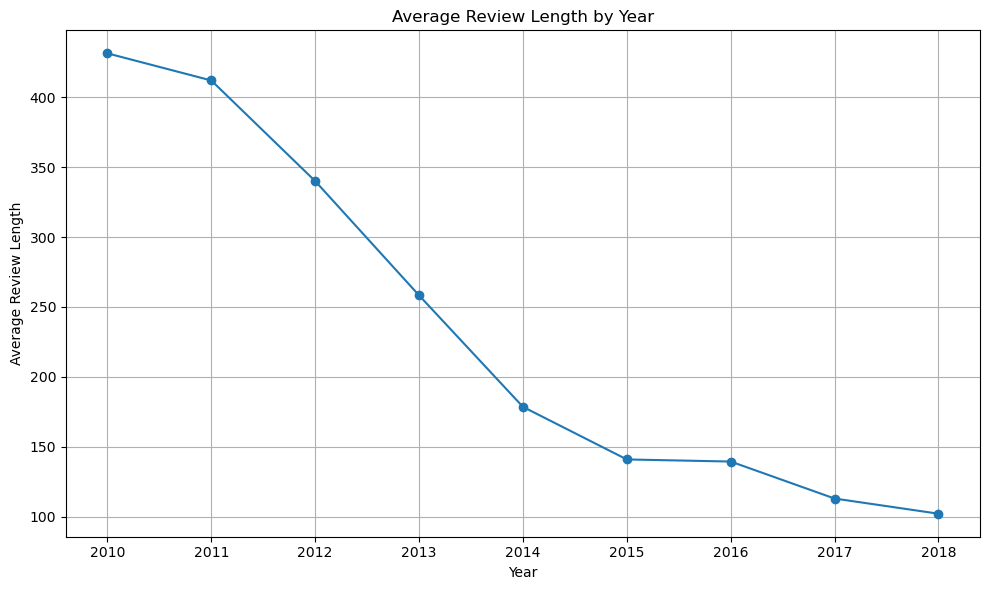

In [79]:
# Plotting the average review length by year

# Calculate review length for each review
tools_df_working_dedup_filter_sample['review_length'] = tools_df_working_dedup_filter_sample['review_text_clean'].apply(len)

# Group by year and calculate average review length
average_review_length_by_year = tools_df_working_dedup_filter_sample.groupby('review_year')['review_length'].mean()

# Plot the average review length by year
plt.figure(figsize=(10, 6))
plt.plot(average_review_length_by_year.index, average_review_length_by_year.values, marker='o', linestyle='-')
plt.title('Average Review Length by Year')
plt.xlabel('Year')
plt.ylabel('Average Review Length')
plt.grid(True)
plt.xticks(average_review_length_by_year.index)  # Set x ticks to be the years
plt.tight_layout()
plt.show()


In [80]:
print(tools_df_working_dedup_filter_sample['review_text_clean_lemmatized'].head())

339092    lock work extremely well one one found relocks...
150265    used unit mom house afer passed away mom neigh...
357087    master electrician pretty braggy ran work owne...
56548     probably good door sweep short opening door go...
31388     bought one based positive review assume writte...
Name: review_text_clean_lemmatized, dtype: object


In [81]:
tools_df_working_dedup_filter_sample.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'reviewTime_cleaned', 'review_year', 'review_month',
       'review_day', 'verified_clean', 'vote_clean', 'image_available',
       'helpfulness_binary', 'num_words_review_title', 'title_length',
       'title_sentiment', 'unique_word_count_title',
       'emoji_non_ascii_count_title', 'num_words_review_text', 'review_length',
       'review_sentiment', 'unique_word_count_review', 'url_count_review',
       'stop_word_count_review', 'review_age_days', 'review_text_clean',
       'sentiment_category', 'review_text_clean_lemmatized'],
      dtype='object')

In [82]:
tools_df_working_dedup_filter_sample['review_text_clean'].head()

339092    lock works extremely well one ones found reloc...
150265    used unit moms house afer passed away moms nei...
357087    master electrician pretty braggy ran work owne...
56548     probably good door sweeps short opening doors ...
31388     bought one based positive reviews assume writt...
Name: review_text_clean, dtype: object

In [83]:
tools_df_working_dedup_filter_sample.isnull().sum()

overall                             0
verified                            0
reviewTime                          0
reviewerID                          0
asin                                0
style                           24085
reviewerName                        9
reviewText                          0
summary                             0
unixReviewTime                      0
vote                            43141
image                           48898
reviewTime_cleaned                  0
review_year                         0
review_month                        0
review_day                          0
verified_clean                      0
vote_clean                          0
image_available                     0
helpfulness_binary                  0
num_words_review_title              0
title_length                        0
title_sentiment                     0
unique_word_count_title             0
emoji_non_ascii_count_title         0
num_words_review_text               0
review_lengt

<font color='red'> Deleting unnecessary dataframes to release some memory</font>

In [84]:
del tools_df
del tools_df_working
del tools_df_working_dedup
del tools_df_working_dedup_filter

In [85]:
rows_with_null = tools_df_working_dedup_filter_sample[tools_df_working_dedup_filter_sample['review_text_clean'].isnull()]
columns_to_print = ['reviewerID','review_text_clean']
print(rows_with_null[columns_to_print])

Empty DataFrame
Columns: [reviewerID, review_text_clean]
Index: []


### <font color='blue'> Plotting N-Grams</font>

In [86]:
'''
This function compares the distribution of top n-grams (unigrams, bigrams, trigrams) for two groups in a DataFrame.

Args:
  df: The DataFrame containing the text data and a column for the comparison group ('helpfulness_binary').
  helpfulness_values: A list of the two values to compare (e.g., [1, 0] for helpfulness).
  n: The n-gram value (1 for unigrams, 2 for bigrams).
  top_n: Number of top n-grams to visualize (default: 20)
'''

def plot_top_ngrams(df, column, target_column, ngram_range=(1, 1), top_n=20):
    # Filter the dataset based on the values of target_column
    subsets = {}
    if ngram_range == (3,3):
        for value in df[target_column].unique():
            if value == 0:
                subsets[value] = df[df[target_column] == value].sample(frac=0.3)    
            else:
                subsets[value] = df[df[target_column] == value]   
    else:    
        for value in df[target_column].unique():
            subsets[value] = df[df[target_column] == value]
        
    # Create a gradient color scheme
    cmap = LinearSegmentedColormap.from_list('custom_gradient', ['#FF5733', '#FFD700', '#4CAF50'])

    # Create the figure outside the loop
    plt.figure(figsize=(10, 6))

    for i, (value, subset) in enumerate(subsets.items()):
        # Create the TF-IDF vectorizer with specified ngram_range
        vectorizer = TfidfVectorizer(ngram_range=ngram_range)

        # Fit the vectorizer to the data and transform the texts into TF-IDF matrices
        tfidf_matrix = vectorizer.fit_transform(subset[column])

        # Get the feature names (ngrams)
        feature_names = vectorizer.get_feature_names_out()

        # Calculate the average TF-IDF score for each ngram across texts
        avg_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]

        # Combine feature names and average TF-IDF scores into a dictionary
        ngram_tfidf_dict = dict(zip(feature_names, avg_tfidf_scores))

        # Sort the ngrams based on their TF-IDF scores in descending order
        sorted_ngrams = sorted(ngram_tfidf_dict.items(), key=lambda x: x[1], reverse=True)

        # Extract top ngrams and their corresponding TF-IDF scores
        top_ngrams = sorted_ngrams[:top_n]
        ngrams, tfidf_scores = zip(*top_ngrams)
        
        # Define colors for bars based on target value
        colors = ['red' if value == 0 else 'green' for _ in range(len(ngrams))]

        # Plot the top ngrams and their TF-IDF scores
        bars = plt.bar(np.arange(len(ngrams)) + i * 0.35, tfidf_scores, color=colors, alpha=0.5, width=0.35)
        plt.xticks(np.arange(len(ngrams)) + 0.35, ngrams, rotation=90)
        plt.xlabel('Ngrams')
        plt.ylabel('TF-IDF Score')
        plt.title(f'Top {top_n} {"-".join(map(str, ngram_range))}grams for {target_column} based on TF-IDF')
        
        # Apply gradient color scheme to bars
        '''for bar in bars:
            bar.set_cmap(cmap)'''
        
    plt.legend([f'{target_column}={value}' for value in subsets.keys()])
    plt.show()
    
    # Clean up memory
    del vectorizer
    del tfidf_matrix
    del feature_names
    del avg_tfidf_scores
    del ngram_tfidf_dict
    del sorted_ngrams
    del top_ngrams
    del ngrams
    del tfidf_scores
    del bars
    gc.collect()  # Perform garbage collection

<font color='blue'> Unigrams </font>

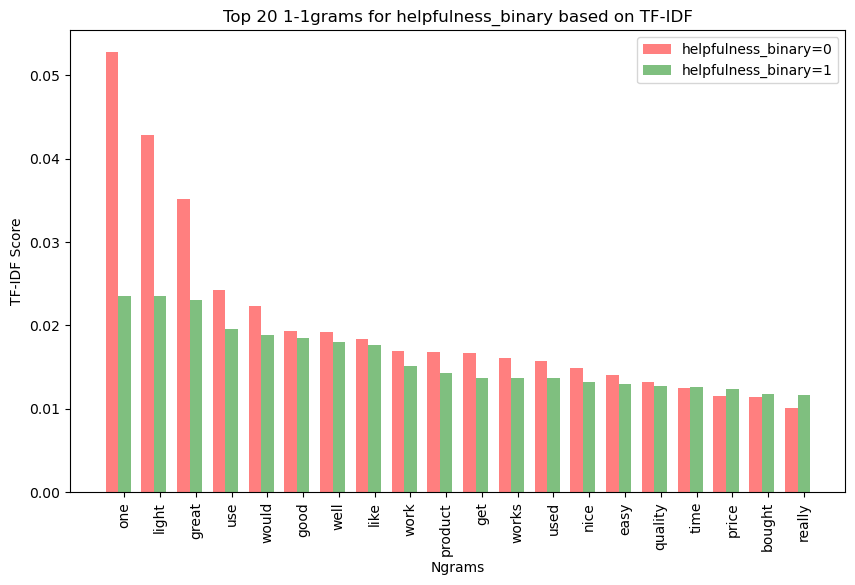

In [87]:
plot_top_ngrams(tools_df_working_dedup_filter_sample, 'review_text_clean', 'helpfulness_binary', ngram_range=(1, 1))

<font color='blue'>Bigrams</font>

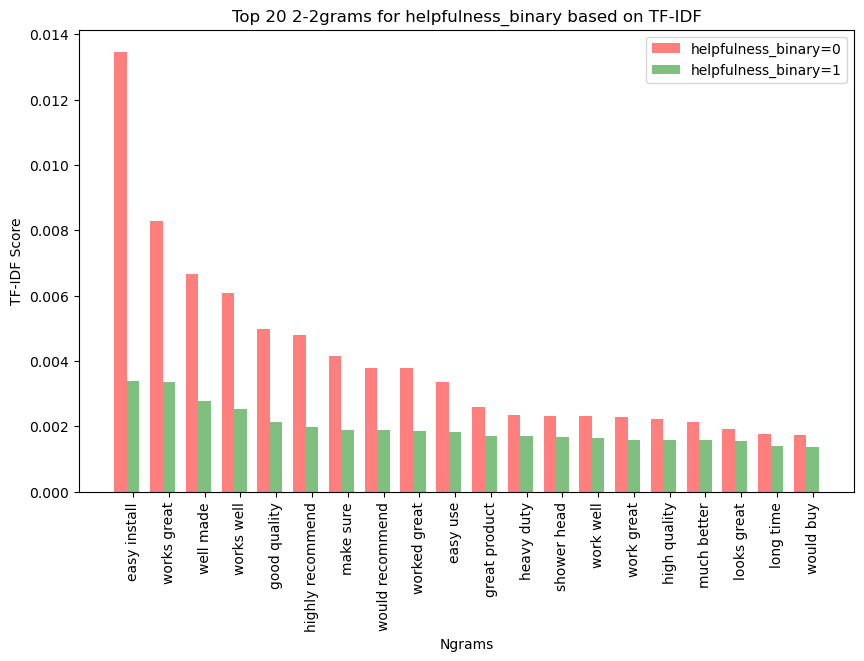

In [88]:
plot_top_ngrams(tools_df_working_dedup_filter_sample, 'review_text_clean', 'helpfulness_binary', ngram_range=(2, 2))

<font color='blue'>Trigrams</font>

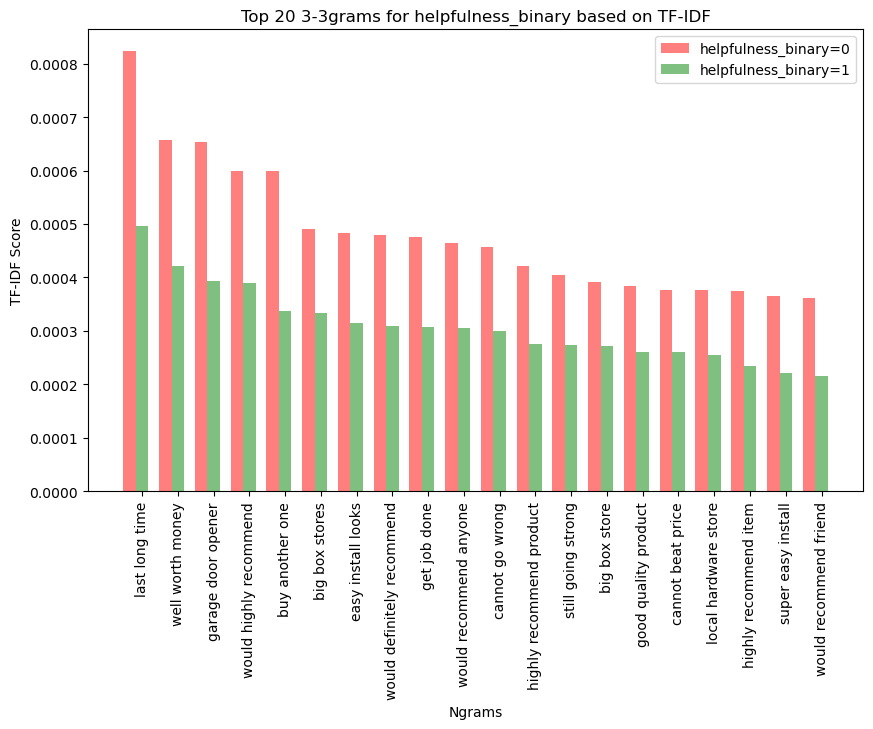

In [89]:
plot_top_ngrams(tools_df_working_dedup_filter_sample, 'review_text_clean', 'helpfulness_binary', ngram_range=(3, 3))

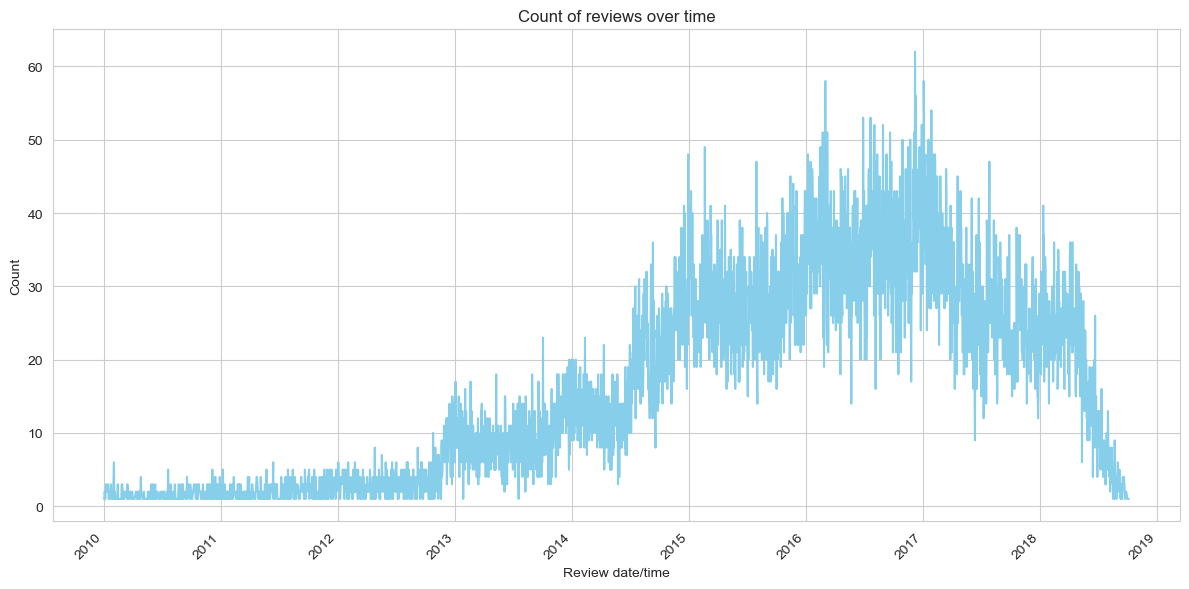

In [90]:
# Trend chart - count of reviews over time
# This can be done on the dataset before sampling as well, change the df name accordingly

# Setting the style for seaborn plots
sns.set_style("whitegrid")

# Converting reviewTime_cleaned to datetime if it's not already in datetime format
tools_df_working_dedup_filter_sample['reviewTime_cleaned'] = pd.to_datetime(tools_df_working_dedup_filter_sample['reviewTime_cleaned'])

# Aggregating the data by date to reduce the number of data points in the chart
review_count_over_time = tools_df_working_dedup_filter_sample.groupby('reviewTime_cleaned').size().reset_index(name='count')

# Plotting count of reviews over time (trend) using a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(x='reviewTime_cleaned', y='count', data=review_count_over_time, color='skyblue')
plt.title('Count of reviews over time')
plt.xlabel('Review date/time')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

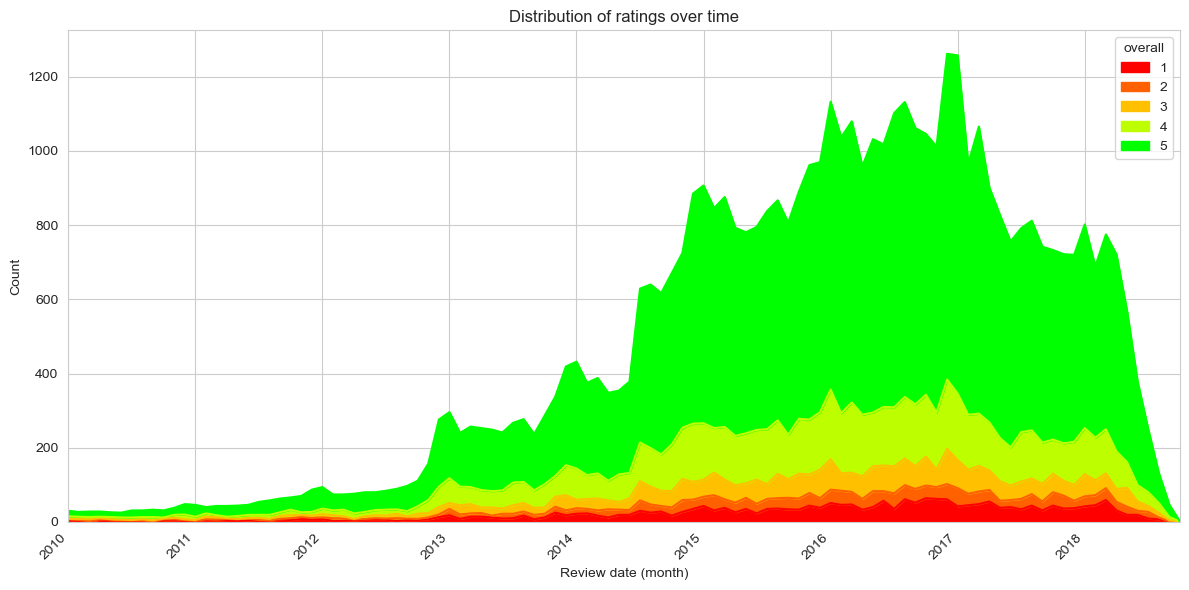

In [91]:
# Defining the custom colormap for ratings from red to green
colors = [(1, 0, 0), (1, 0.5, 0), (1, 1, 0), (0, 1, 0)]
cmap = LinearSegmentedColormap.from_list("RedToGreen", colors)

# Aggregating the data by month and rating
ratings_over_time_agg = tools_df_working_dedup_filter_sample.groupby([tools_df_working_dedup_filter_sample['reviewTime_cleaned'].dt.to_period('M'), 'overall']).size().unstack().fillna(0)

# Plotting stacked bar chart for the distribution of ratings over time
plt.figure(figsize=(12, 6))
ratings_over_time_agg.plot(kind='area', stacked=True, cmap=cmap, figsize=(12, 6))
plt.title('Distribution of ratings over time')
plt.xlabel('Review date (month)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

/Users/shitgupt/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6827: RuntimeWarning:

invalid value encountered in multiply



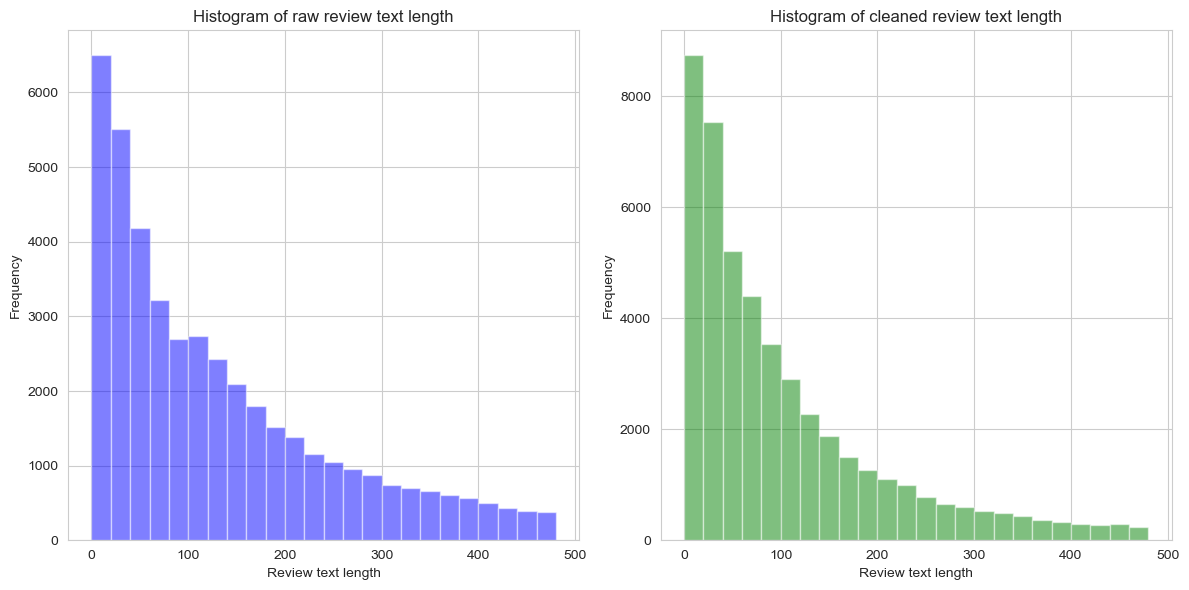

In [92]:
# Pre and post histogram for comparing length of review text before and after cleaning is done
# We can notice the concentration of the lower review text length increases after cleaning 
# i.e. relatively lower review text length become even lower 
# This indicates that there are a lot of characters getting removed due to our cleaning steps 
# This is because of the removal of stopwords, URLs, emojis, etc.
# X and Y axes of both charts are kept in sync to make the change visible

# Calculating the length of the text in the raw and cleaned review text columns
reviewtext_raw_lengths = tools_df_working_dedup_filter_sample['reviewText'].apply(len)
reviewtext_cleaned_lengths = tools_df_working_dedup_filter_sample['review_text_clean'].apply(len)

# Defining custom bins
# Bins from 0 to 500 with step size 20
custom_bins_reviewtext_len = np.arange(0, 500, 20)
# Appending infinity to include values above 500
custom_bins_reviewtext_len = np.append(custom_bins_reviewtext_len, np.inf)

# Defining subplots with same x & y axes ranges (to make the charts comparable) 
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# Plotting histogram for raw review text lengths
axes[0].hist(reviewtext_raw_lengths, bins=custom_bins_reviewtext_len, alpha=0.5, color='blue')
axes[0].set_title('Histogram of raw review text length')
axes[0].set_xlabel('Review text length')
axes[0].set_ylabel('Frequency')

# Plotting histogram for cleaned review text lengths
axes[1].hist(reviewtext_cleaned_lengths, bins=custom_bins_reviewtext_len, alpha=0.5, color='green')
axes[1].set_title('Histogram of cleaned review text length')
axes[1].set_xlabel('Review text length')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

/Users/shitgupt/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6827: RuntimeWarning:

invalid value encountered in multiply



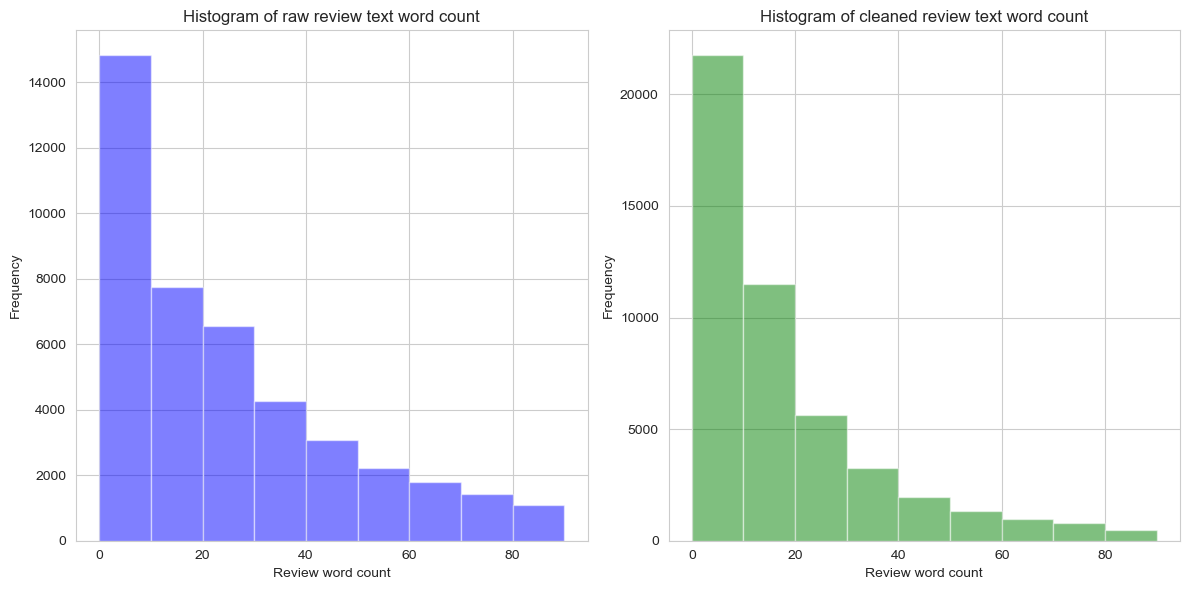

In [93]:
# Pre and post histogram for comparing word count of review text before and after cleaning is done
# We can notice the concentration of the lower review word count increases after cleaning 
# This indicates that there are a lot of words  getting removed due to our cleaning steps 
# This is because of the removal of stopwords, URLs, emojis, etc.
# X and Y axes of both charts are kept in sync to make the change visible

# Calculating the word count of the text in the raw and cleaned review columns
reviewtext_raw_wordlengths = tools_df_working_dedup_filter_sample['reviewText'].str.split().apply(len)
reviewtext_cleaned_wordlengths = tools_df_working_dedup_filter_sample['review_text_clean'].str.split().apply(len)

# Defining custom bins
# Bins from 0 to 100 with step size 10
custom_bins_review_words = np.arange(0, 100, 10)  
# Appending infinity to include values above 100
custom_bins_review_words = np.append(custom_bins_review_words, np.inf)  

# Defining subplots with same x & y axes ranges (to make the charts comparable) 
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# Plotting histogram for raw word counts in review text
axes[0].hist(reviewtext_raw_wordlengths, bins=custom_bins_review_words, alpha=0.5, color='blue')
axes[0].set_title('Histogram of raw review text word count')
axes[0].set_xlabel('Review word count')
axes[0].set_ylabel('Frequency')

# Plotting histogram for cleaned word counts in review text
axes[1].hist(reviewtext_cleaned_wordlengths, bins=custom_bins_review_words, alpha=0.5, color='green')
axes[1].set_title('Histogram of cleaned review text word count')
axes[1].set_xlabel('Review word count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [94]:
# Function to do a t-test for a given metadata feature 
# When we compare the values of a feature between helpful and non helpful reviews, we want to know if the difference is statistically significant
# This can be done using a t-test
# If the p-value <0.05, we can say that the null hypothesis of no difference betweent the means can be rejected
# What this means is that there is a statistically significant difference between the feature's value between helpful and non-helpful reviews

from scipy.stats import ttest_ind

def t_test_metadata(df, metadata_column, helpfulness_column):
    # Separating data into helpful and non-helpful reviews for comparison
    helpful_reviews = df[df[helpfulness_column] == 1][metadata_column]
    non_helpful_reviews = df[df[helpfulness_column] == 0][metadata_column]
    
    # Performing t-test
    t_statistic, p_value = ttest_ind(helpful_reviews, non_helpful_reviews)
    
    return p_value

In [95]:
# Using the t-test function
metadata_column = 'title_length'  
helpfulness_column = 'helpfulness_binary'  

p_value = t_test_metadata(tools_df_working_dedup_filter_sample, metadata_column, helpfulness_column)
if p_value < 0.05:
    print(f"There is a statistically significant difference between helpful and non-helpful reviews for the {metadata_column} feature since the p-value of the difference is {p_value:.4f}")
else:
    print(f"There is no statistically significant difference between helpful and non-helpful reviews for the {metadata_column} feature since the p-value of the difference is {p_value:.4f}")

There is a statistically significant difference between helpful and non-helpful reviews for the title_length feature since the p-value of the difference is 0.0000


# <font color='purple'>Modeling</font>

#### <font color='purple'>Steps:
1) Choose ONLY metadata features for correlation (there will be 5k tfidf features, not feasible to check correlation)
2) Define high correlation threshold, can be >=0.85 for high positive correlation and <=-0.85 for high negative correlation
3) Check correlation matrix and exclude highly correlated unimportant features
4) Visualize correlation matrix again with final list and ensure that no 2 features are outside correlation thresholds
5) Create TFIDF matrix and convert to dataframe
6) Modeling dataframes - X will contain all features i.e. TFIDF features and finalized metadata features, y will contain the target variable i.e. helpfulness_binary
7) Split of modeling datasets into train (80%) and test (20%)
8) Training the supervised ML models; 2 sets of models will be trained - base models and tuned models
9) Base models will run with default parameters while tuned models will be run after identifying optimal parameters obtained from hyperparameter tuning
10) Compare the base and tuned models' performance
11) Compare the models
12) Feature importance of the models
13) Model explainability (extension of feature importance) and identifying drivers of helpfulness for insights
    - For tree-based models (Random Forest / XGBoost) - feature importance of review terms</font>

### <font color='blue'>Modeling dataset creation</font>

In [96]:
# Specifying the metadata features for checking correlation
other_meta_features = [
                  'image_available',
                  'title_length',
                  'num_words_review_title', #'title_review_similarity', # commented if not calculated
                  'title_sentiment',
                  'unique_word_count_title',
                  'emoji_non_ascii_count_title',
                  'review_length',
                  'review_sentiment',
                  'num_words_review_text',
                  'url_count_review',
                  'unique_word_count_review',
                  'stop_word_count_review',
                  'review_age_days'
                 ]

# Getting only metadata feature columns for correlation checks
metadata_features_corr_check = tools_df_working_dedup_filter_sample[other_meta_features]

In [97]:
# Metadata features for correlation check
metadata_features_corr_check.columns

Index(['image_available', 'title_length', 'num_words_review_title',
       'title_sentiment', 'unique_word_count_title',
       'emoji_non_ascii_count_title', 'review_length', 'review_sentiment',
       'num_words_review_text', 'url_count_review', 'unique_word_count_review',
       'stop_word_count_review', 'review_age_days'],
      dtype='object')

In [98]:
metadata_features_corr_check.shape

(49996, 13)

### <font color='blue'> Plotting Co-relation Matrix </font>

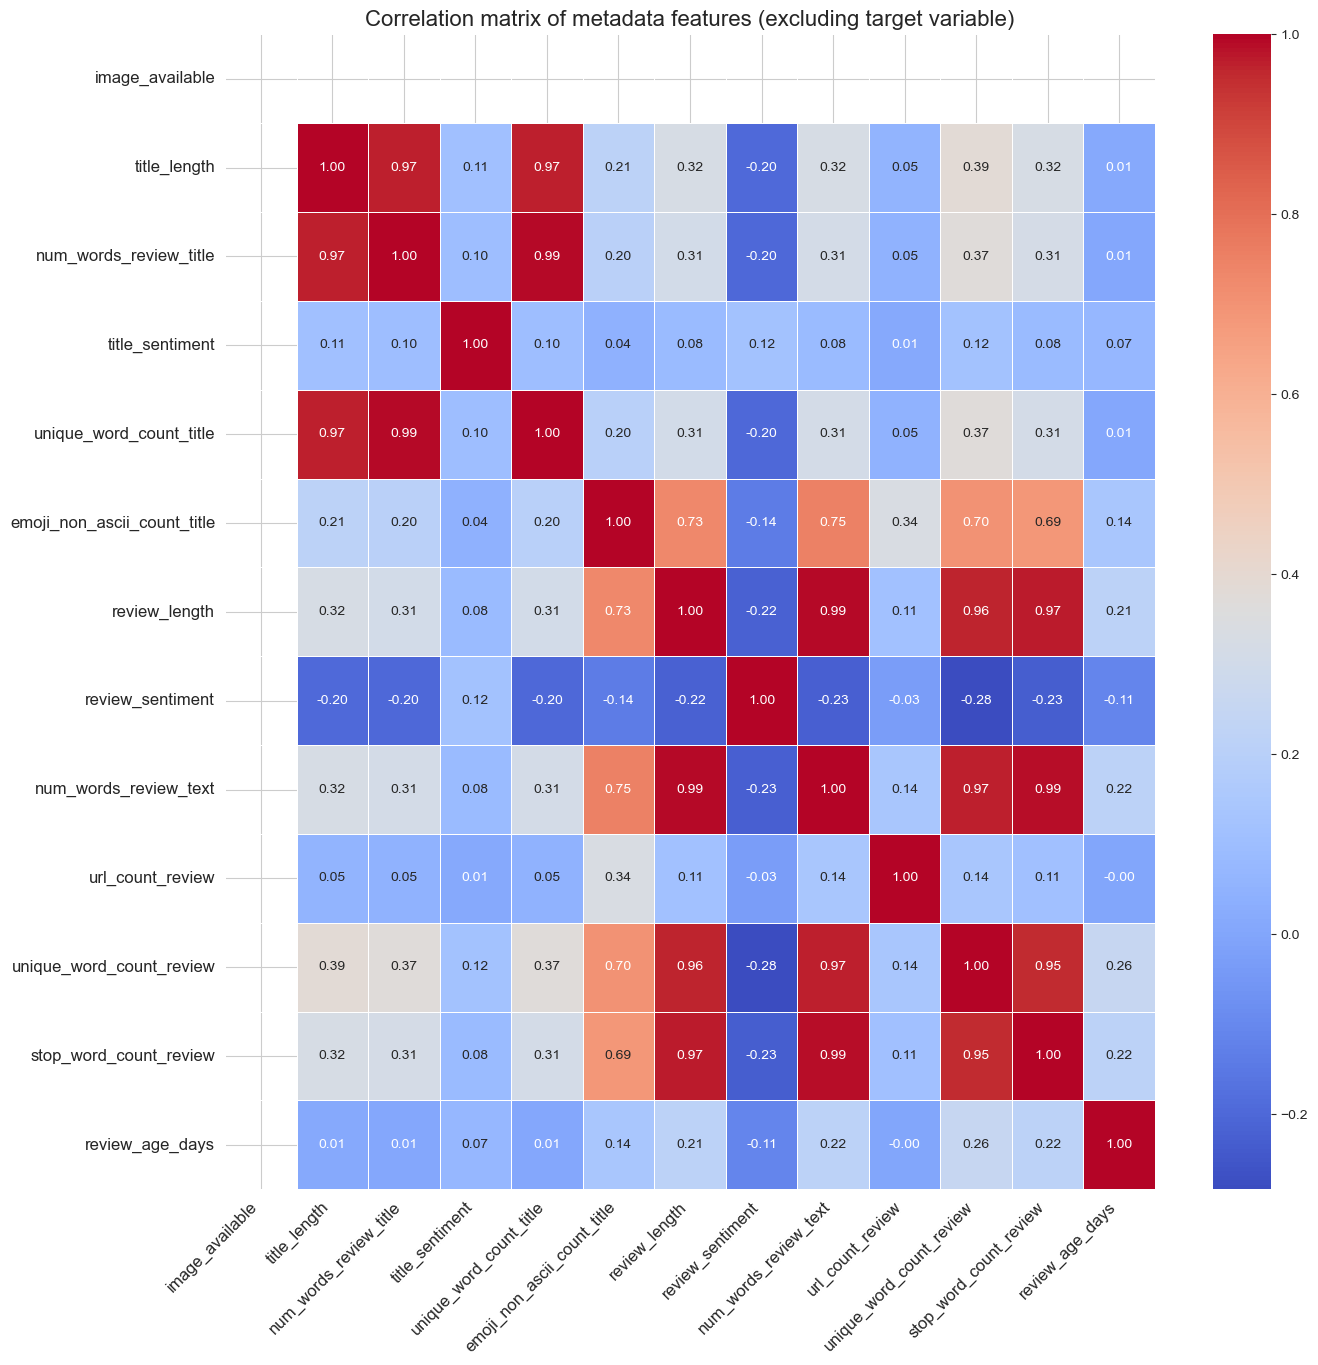

In [99]:
# Getting only metadata feature columns to check correlation
correlation_matrix_corr_check = metadata_features_corr_check.corr()

# Visualize correlation matrix using heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix_corr_check, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0, fontsize=12)  # Keep y-axis labels horizontal for better readability
plt.title('Correlation matrix of metadata features (excluding target variable)', fontsize=16)  # Increase title fontsize
plt.show()

In [100]:
# Need to study the above matrix and remove correlated metadata features
correlation_matrix_corr_check

image_available  title_length  \
image_available                          NaN           NaN   
title_length                             NaN      1.000000   
num_words_review_title                   NaN      0.966186   
title_sentiment                          NaN      0.112663   
unique_word_count_title                  NaN      0.967493   
emoji_non_ascii_count_title              NaN      0.213226   
review_length                            NaN      0.324075   
review_sentiment                         NaN     -0.195396   
num_words_review_text                    NaN      0.324084   
url_count_review                         NaN      0.054685   
unique_word_count_review                 NaN      0.385884   
stop_word_count_review                   NaN      0.324365   
review_age_days                          NaN      0.013919   

                             num_words_review_title  title_sentiment  \
image_available                                 NaN              NaN   
title_length                               0.966186         0.112663   
num_words_review_title                     1.000000         0.100735   
title_sentiment                            0.100735         1.000000   
unique_word_count_title                    0.992484         0.101844   
emoji_non_ascii_count_title                0.204071         0.044254   
review_length                              0.307037         0.084476   
review_sentiment                          -0.198674         0.120604   
num_words_review_text                      0.312705         0.084115   
url_count_review                           0.050008         0.014016   
unique_word_count_review                   0.373008         0.120544   
stop_word_count_review                     0.314259         0.082969   
review_age_days                            0.005838         0.070980   

                             unique_word_count_title  \
image_available                                  NaN   
title_length                                0.967493   
num_words_review_title                      0.992484   
title_sentiment                             0.101844   
unique_word_count_title                     1.000000   
emoji_non_ascii_count_title                 0.202812   
review_length                               0.305651   
review_sentiment                           -0.201213   
num_words_review_text                       0.310877   
url_count_review                            0.049675   
unique_word_count_review                    0.372289   
stop_word_count_review                      0.312878   
review_age_days                             0.006305   

                             emoji_non_ascii_count_title  review_length  \
image_available                                      NaN            NaN   
title_length                                    0.213226       0.324075   
num_words_review_title                          0.204071       0.307037   
title_sentiment                                 0.044254       0.084476   
unique_word_count_title                         0.202812       0.305651   
emoji_non_ascii_count_title                     1.000000       0.733530   
review_length                                   0.733530       1.000000   
review_sentiment                               -0.138314      -0.220190   
num_words_review_text                           0.754347       0.992068   
url_count_review                                0.335083       0.113118   
unique_word_count_review                        0.703974       0.960044   
stop_word_count_review                          0.685250       0.973303   
review_age_days                                 0.142462       0.214035   

                             review_sentiment  num_words_review_text  \
image_available                           NaN                    NaN   
title_length                        -0.195396               0.324084   
num_words_review_title              -0.198674               0.312705   
title_sentiment            

<font color='green'>After analysing correlation matrix, there are a lot of correlated feature. Deciding the cut-off as more than 0.85. Any feature that is more than 0.85 is highly postively correlated. Any feature that is less than -0.85 is highly negatively correlated.</font>

In [101]:
# Removing highly correlated features
# Uncorrelated metadata features are identified through manual judgement i.e. heuristic approach

# Droping the columns from the dataframe
corr_columns_to_drop = ["review_length", "stop_word_count_review",
                        "unique_word_count_title","num_words_review_title","num_words_review_text",
                        # Removing image_available since it's binary/boolen and isn't relevant for correlation checks
                        "image_available"]
metadata_features_corr_check.drop(columns=corr_columns_to_drop, inplace=True)

In [102]:
metadata_features_corr_check.shape

(49996, 7)

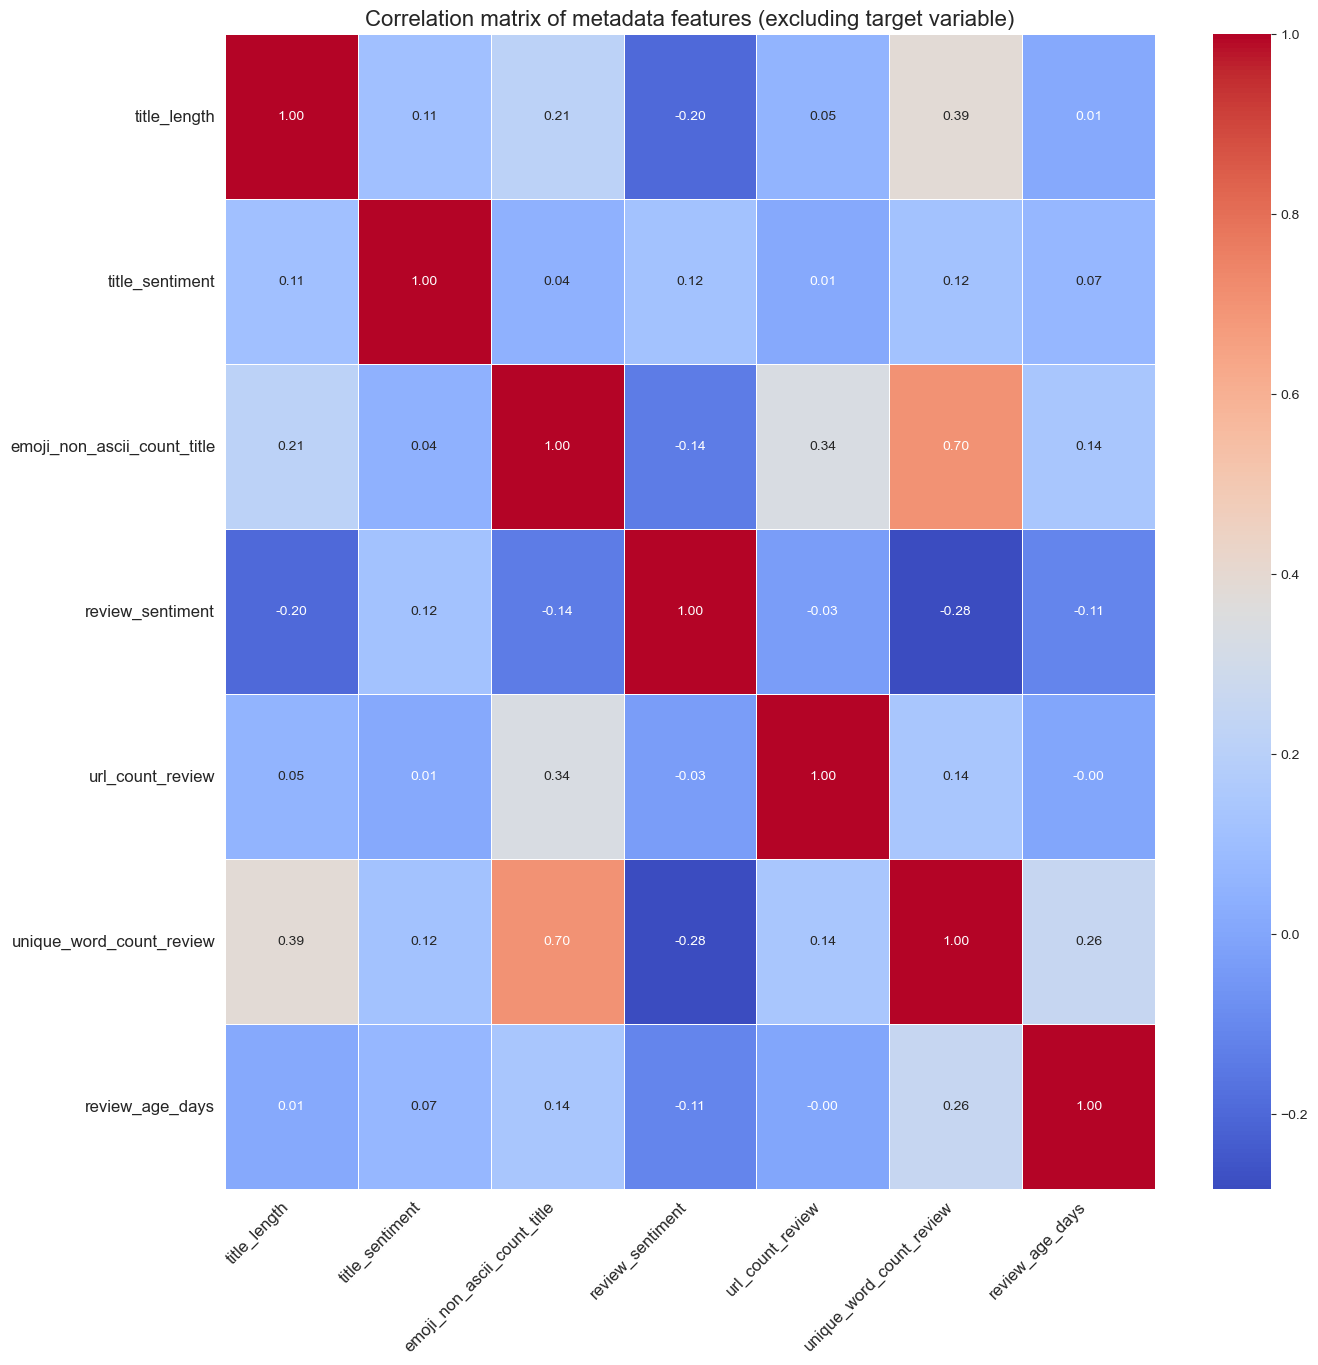

In [103]:
# Getting only uncorrelated metadata feature columns to check correlation
metadata_features_final = metadata_features_corr_check.copy()
correlation_matrix_final = metadata_features_final.corr()

# Visualize correlation matrix using heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix_final, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotating x-axis labels for better readability
plt.yticks(rotation=0, fontsize=12)  # Keeping y-axis labels horizontal for better readability
plt.title('Correlation matrix of metadata features (excluding target variable)', fontsize=16)  # Increasing title fontsize
plt.show()

<font color='green'>After removing highly corelated features above matrix is the final correlation matrix.</font>

In [104]:
# Creating final modeling dataset

# Defining the columns to be taken in modeling dataset
target_column = 'helpfulness_binary'  # Helpfulness is binary (1 or 0)

# Defining final metadata features after ensuring that no independent metadata features are highly correlated
# List of columns comes from metadata_features_final.columns
final_meta_features = ['title_length', 'title_sentiment', 'emoji_non_ascii_count_title', 'review_sentiment',
                       'url_count_review', 'unique_word_count_review','review_age_days',
                       # including image_available since it was dropped in correlation matrix
                       'image_available']

# Getting only metadata feature columns
modeling_df_meta_final = tools_df_working_dedup_filter_sample[final_meta_features]

In [105]:
tools_df_working_dedup_filter_sample.shape

(49996, 35)

In [106]:
tools_df_working_dedup_filter_sample.to_csv('Tools_Modeling_2.csv', index=False)

In [107]:
modeling_df_meta_final.shape

(49996, 8)

In [108]:
# get the data types of each column
data_types = tools_df_working_dedup_filter_sample.dtypes

# create a dictionary to group columns by data type
columns_by_type = {}

for column, dtype in data_types.items():
    if dtype not in columns_by_type:
        columns_by_type[dtype] = [column]
    else:
        columns_by_type[dtype].append(column)

# print the data types and their corresponding columns
for dtype, columns in columns_by_type.items():
    print(f'Data Type: {dtype}')
    print(f'Columns: {columns}')
    print('---')

Data Type: int64
Columns: ['overall', 'unixReviewTime', 'helpfulness_binary', 'num_words_review_title', 'title_length', 'unique_word_count_title', 'emoji_non_ascii_count_title', 'num_words_review_text', 'review_length', 'unique_word_count_review', 'url_count_review', 'stop_word_count_review', 'review_age_days']
---
Data Type: bool
Columns: ['verified', 'verified_clean', 'image_available']
---
Data Type: object
Columns: ['reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName', 'reviewText', 'summary', 'vote', 'image', 'review_text_clean', 'sentiment_category', 'review_text_clean_lemmatized']
---
Data Type: datetime64[ns]
Columns: ['reviewTime_cleaned']
---
Data Type: int32
Columns: ['review_year', 'review_month', 'review_day']
---
Data Type: float64
Columns: ['vote_clean', 'title_sentiment', 'review_sentiment']
---


<font color='green'>Outlier Detection for Integer or Float Features</font>

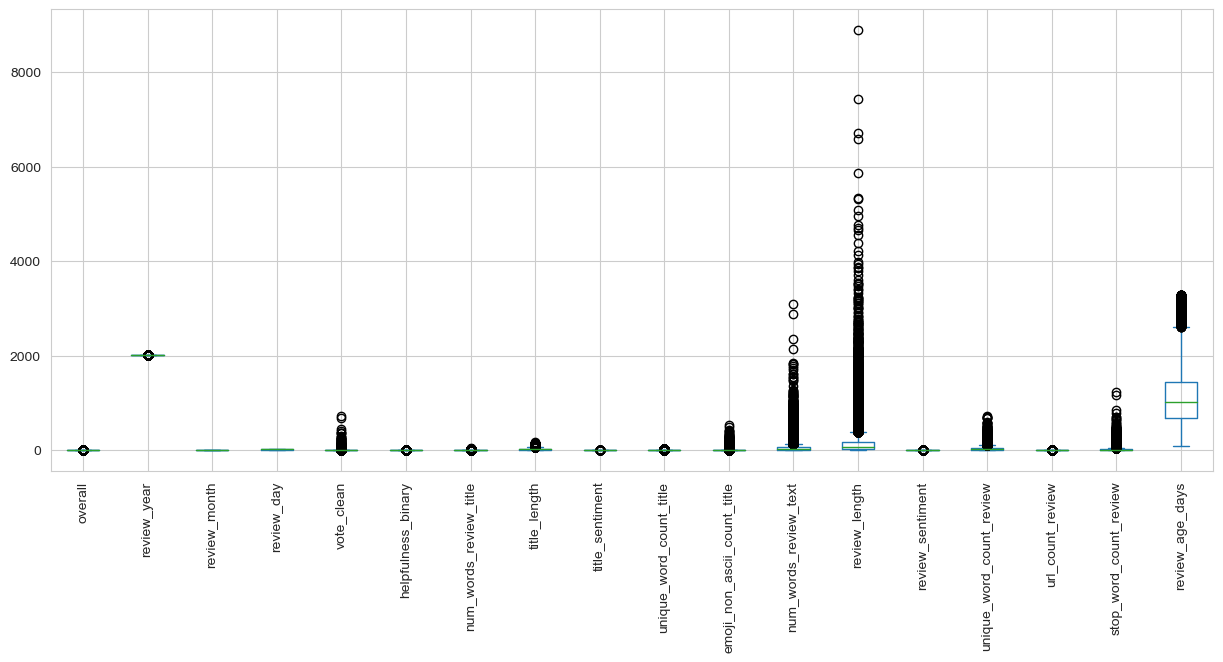

In [109]:
# Select only integer columns, excluding 'unixReviewTime'
numerical_cols = tools_df_working_dedup_filter_sample.select_dtypes(include=[int, float]).drop('unixReviewTime', axis=1)

# Plot box plots for integer columns
numerical_cols.plot(kind='box', subplots=False, figsize=(15, 6), rot=90)

# Show the plot
plt.show()

Scaling the outliers

In [110]:
# Import Robust Scaler
from sklearn.preprocessing import RobustScaler

# List of columns to scale
columns_to_scale = ['vote_clean','emoji_non_ascii_count_title', 'num_words_review_text','review_length', 'unique_word_count_review', 'stop_word_count_review']

# Create a StandardScaler instance
scaler = RobustScaler()

# Scale the specified columns
scaled_data = scaler.fit_transform(tools_df_working_dedup_filter_sample[columns_to_scale])

# Create new columns for scaled data
for i, col in enumerate(columns_to_scale):
    scaled_col = col
    tools_df_working_dedup_filter_sample[scaled_col] = scaled_data[:, i]

tools_df_working_dedup_filter_sample.head()

overall  verified   reviewTime      reviewerID        asin  \
339092        5     False  01 28, 2010  A13ZVFDFZFTXFJ  B000NJJ1TY   
150265        5      True  01 26, 2010  A29CLPS7BD39RE  B00099DG8A   
357087        5     False  01 22, 2010  A1P2HZ2H4L1BBK  B000O3LUEI   
56548         1      True  01 17, 2010  A1EPP56A17R62Q  B00005202H   
31388         1     False  01 12, 2010  A32G4AR56VP4YN  B0000302X8   

                                                    style        reviewerName  \
339092  {'Color Name:': ' Antique Brass', 'Package Typ...           Don Lewis   
150265                                                NaN    Thomas F. Goettl   
357087            {'Style Name:': ' Multimeter Standard'}          Dr Markway   
56548                                                 NaN              Tommie   
31388                                                 NaN  Michael J. Casteel   

                                               reviewText  \
339092  The lock works extremely well.  It is one of t...   
150265  We used this unit in my moms house afer she pa...   
357087  If there was a "Master Electrician" I was it. ...   
56548   These are probably very good door sweeps but t...   
31388   I bought one of these based on the positive re...   

                              summary  unixReviewTime  ...  \
339092  Great lock - buy it at Lowe's      1264636800  ...   
150265              The perfect watch      1264464000  ...   
357087             Master Electrician      1264118400  ...   
56548          Too short for my doors      1263686400  ...   
31388          Useless waste of money      1263254400  ...   

       num_words_review_text review_length review_sentiment  \
339092              1.096154      1.048611         0.097619   
150265              0.461538      0.395833         1.000000   
357087              4.134615      4.437500         0.263718   
56548               0.442308      0.243056         0.272000   
31388               1.134615      0.972222        -0.052841   

        unique_word_count_review  url_count_review  stop_word_count_review  \
339092                  1.205128                 0                1.000000   
150265                  0.538462                 0                0.571429   
357087                  3.461538                 0                3.857143   
56548                   0.461538                 0                0.666667   
31388                   1.025641                 0                1.333333   

        review_age_days                                  review_text_clean  \
339092             3259  lock works extremely well one ones found reloc...   
150265             3261  used unit moms house afer passed away moms nei...   
357087             3265  master electrician pretty braggy ran work owne...   
56548              3270  probably good door sweeps short opening doors ...   
31388              3275  bought one based positive reviews assume writt...   

        sentiment_category                       review_text_clean_lemmatized  
339092             neutral  lock work extremely well one one found relocks...  
150265            positive  used unit mom house afer passed away mom neigh...  
357087            positive  master electrician pretty braggy ran work owne...  
56548             positive  probably good door sweep short opening door go...  
31388              neutral  bought one based positive review assume writte...  

[5 rows x 35 columns]

<font color='green'> We see outliers with features like "number of word, "review length" etc, however, we do not want to scale them as these are import.</font>

### <font color='purple'>Start Modelling and generate features</font>

In [111]:
# Creating TFIDF matrix of cleaned review text and storing in a df
# Custom tokenizer function
def custom_tokenizer(text):
    # Splitting text into words using a simple whitespace tokenizer
    words = text.split()
    return words

# Tokenizing text using custom tokenizer
tokenized_text = tools_df_working_dedup_filter_sample['review_text_clean'].apply(custom_tokenizer).apply(' '.join)

# Creating TF-IDF vectorizer instance with custom tokenizer and top 1000 features
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(tokenized_text)

# Converting TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

/Users/shitgupt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [112]:
tfidf_df.shape

(49996, 1000)

In [113]:
# Combining TF-IDF features with other features

# Restting index on both TFIDF dataframe and metadata feature dataframe
tfidf_df.reset_index(drop=True, inplace=True)
modeling_df_meta_final.reset_index(drop=True, inplace=True)

# Splitting into X and y for modeling
# X will have the TFIDF df and the final metadata features
X = pd.concat([tfidf_df, modeling_df_meta_final], axis=1)

# y will have the target variable
y = tools_df_working_dedup_filter_sample['helpfulness_binary']

In [114]:
# convert to csv
X.to_csv('Tools_Modeling.csv', index=False)

In [115]:
# Checking size - this should be the same as the stratified sample output df size
X.shape

(49996, 1008)

### <font color='purple'> Before Modelling, splitting the dataset into Training, Test and Validation Sets </font>
We used <b>70, 15, 15</b> ratio for Training, Validation and Test Sets

In [116]:
# X contains your features and y contains your target variable
# Replace X and y with actual feature and target data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

# Split remaining 85% into 70% training and 15% validation
test_val_ratio = 0.15 / 0.85  # Ratio of validation/test split from the remaining 85%
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=test_val_ratio, random_state=123)

In [117]:

# Displaying the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34996, 1008)
X_val shape: (7500, 1008)
X_test shape: (7500, 1008)
y_train shape: (34996,)
y_val shape: (7500,)
y_test shape: (7500,)


In [118]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

In [119]:
X_train.head(2)

aa  aaa  ability  able  absolutely   ac  accurate  across  actually  \
19282  0.0  0.0      0.0   0.0         0.0  0.0       0.0     0.0       0.0   
37607  0.0  0.0      0.0   0.0         0.0  0.0       0.0     0.0       0.0   

       adapter  ...  yes  yet  title_length  title_sentiment  \
19282      0.0  ...  0.0  0.0            56              0.0   
37607      0.0  ...  0.0  0.0            32              0.7   

       emoji_non_ascii_count_title  review_sentiment  url_count_review  \
19282                            0          0.366667                 0   
37607                            0          0.550000                 0   

       unique_word_count_review  review_age_days  image_available  
19282                        23             1086            False  
37607                        13              467            False  

[2 rows x 1008 columns]

In [120]:
X_val.head(2)

aa  aaa  ability  able  absolutely   ac  accurate  across  actually  \
788  0.0  0.0      0.0   0.0         0.0  0.0       0.0     0.0       0.0   
817  0.0  0.0      0.0   0.0         0.0  0.0       0.0     0.0       0.0   

     adapter  ...  yes  yet  title_length  title_sentiment  \
788      0.0  ...  0.0  0.0            21              0.0   
817      0.0  ...  0.0  0.0            36              0.9   

     emoji_non_ascii_count_title  review_sentiment  url_count_review  \
788                            4         -0.247222                 0   
817                            7          0.250000                 0   

     unique_word_count_review  review_age_days  image_available  
788                        45             2437            False  
817                        57             2451            False  

[2 rows x 1008 columns]

In [121]:
X_test.head(2)

aa  aaa  ability  able  absolutely   ac  accurate  across  actually  \
1659   0.0  0.0      0.0   0.0         0.0  0.0       0.0     0.0       0.0   
11477  0.0  0.0      0.0   0.0         0.0  0.0       0.0     0.0       0.0   

       adapter  ...  yes  yet  title_length  title_sentiment  \
1659       0.0  ...  0.0  0.0            29              0.3   
11477      0.0  ...  0.0  0.0            10              0.0   

       emoji_non_ascii_count_title  review_sentiment  url_count_review  \
1659                             1          0.366667                 0   
11477                            0          0.261111                 0   

       unique_word_count_review  review_age_days  image_available  
1659                         30             2188            False  
11477                        12             1384            False  

[2 rows x 1008 columns]

## <font color='purple'>Modeling - Supervised ML models to predict helpfulness</font>

<font color='red'> As our data is imbalanced, we do not want our models to only focus on majority class. So we are using sample weights so that we can assign weights to each individual class. This will help our models to focus on the minority class which is our actual requirement</font>

In [122]:
# Calculate class weights
sample_weights_train = compute_sample_weight(class_weight='balanced', y=y_train)
sample_weights_val = compute_sample_weight(class_weight='balanced', y=y_val)

### <font color='blue'>Modeling - Logistic Regression</font>

Training the Base Model

In [123]:
# Train the model with class weights
lr_classifier = LogisticRegression(random_state=123, solver='liblinear', max_iter=1000, multi_class='ovr')
lr_classifier.fit(X_train, y_train, sample_weight=sample_weights_train)
lr_test_predictions = lr_classifier.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_test_predictions)
print("Logistic Regression base model accuracy:", lr_accuracy)
print("Logistic Regression base model classification report:")
print(classification_report(y_test, lr_test_predictions))

Logistic Regression base model accuracy: 0.7277333333333333
Logistic Regression base model classification report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83      6625
           1       0.25      0.68      0.37       875

    accuracy                           0.73      7500
   macro avg       0.60      0.71      0.60      7500
weighted avg       0.87      0.73      0.77      7500



In [124]:
with open('lr_base_classifier_tools.pkl', 'wb') as f:
    pickle.dump(lr_classifier, f)

Performing Hyperparameter tuning

In [128]:
# Logistic Regression - Hyperparameter Tuning
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization parameter
    'penalty': ['l1', 'l2']  # Penalty term
}

base_model = LogisticRegression(random_state=123, solver='liblinear', max_iter=1000, multi_class='ovr')

# Define a custom scoring function for ROC AUC
def roc_auc_scorer(estimator, X, y):
    y_pred = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_pred, average='weighted')

lr_grid_search = GridSearchCV(base_model, param_grid=lr_param_grid, cv=3, scoring=roc_auc_scorer)

# Hyperparameter tuning on validation dataset
lr_grid_search.fit(X_val, y_val, sample_weight=sample_weights_val)

lr_best_params = lr_grid_search.best_params_
lr_best_model = lr_grid_search.best_estimator_

print("Logistic Regression Best Parameters:", lr_best_params)

lr_grid_search.cv_results_
df = pd.DataFrame(lr_grid_search.cv_results_)
display(df)

Logistic Regression Best Parameters: {'C': 0.01, 'penalty': 'l2'}


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.189271      0.053723         0.037778        0.001227   0.001   
1       0.163543      0.014767         0.029852        0.000265   0.001   
2       0.150548      0.008692         0.036559        0.000151    0.01   
3       0.151813      0.015989         0.027260        0.000419    0.01   
4       0.145657      0.006931         0.036705        0.000174     0.1   
5       0.162989      0.017551         0.028291        0.000771     0.1   
6       0.167037      0.014824         0.035602        0.001235       1   
7       0.201558      0.025279         0.031224        0.004178       1   
8       0.290743      0.016749         0.037003        0.000468      10   
9       0.211616      0.014279         0.028122        0.001124      10   

  param_penalty                         params  split0_test_score  \
0            l1  {'C': 0.001, 'penalty': 'l1'}           0.727316   
1            l2  {'C': 0.001, 'penalty': 'l2'}           0.766455   
2            l1   {'C': 0.01, 'penalty': 'l1'}           0.801600   
3            l2   {'C': 0.01, 'penalty': 'l2'}           0.795535   
4            l1    {'C': 0.1, 'penalty': 'l1'}           0.790970   
5            l2    {'C': 0.1, 'penalty': 'l2'}           0.789524   
6            l1      {'C': 1, 'penalty': 'l1'}           0.749373   
7            l2      {'C': 1, 'penalty': 'l2'}           0.757770   
8            l1     {'C': 10, 'penalty': 'l1'}           0.649767   
9            l2     {'C': 10, 'penalty': 'l2'}           0.697454   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.736059           0.735277         0.732884        0.003950   
1           0.783605           0.783873         0.777978        0.008148   
2           0.808852           0.790781         0.800411        0.007426   
3           0.810253           0.795832         0.800540        0.006869   
4           0.806704           0.789071         0.795582        0.007903   
5           0.804274           0.787640         0.793813        0.007437   
6           0.759194           0.754099         0.754222        0.004011   
7           0.774938           0.757554         0.763421        0.008145   
8           0.652051           0.638663         0.646827        0.005848   
9           0.714700           0.688567         0.700240        0.010849   

   rank_test_score  
0                8  
1                5  
2                2  
3                1  
4                3  
5                4  
6                7  
7                6  
8               10  
9                9

In [129]:
df[['param_C','param_penalty','mean_test_score']]

param_C param_penalty  mean_test_score
0   0.001            l1         0.732884
1   0.001            l2         0.777978
2    0.01            l1         0.800411
3    0.01            l2         0.800540
4     0.1            l1         0.795582
5     0.1            l2         0.793813
6       1            l1         0.754222
7       1            l2         0.763421
8      10            l1         0.646827
9      10            l2         0.700240

In [130]:
lr_grid_search.best_score_

0.8005401912676553

Training the final model based on the tuned parameters

In [131]:
# Create the best model using the entire training set
classes = np.unique(y_train)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

best_model = LogisticRegression(**lr_best_params, random_state=123, solver='liblinear', max_iter=1000, multi_class='ovr')
best_model.fit(X_train, y_train, sample_weight=sample_weights_train)

LogisticRegression(C=0.01, max_iter=1000, multi_class='ovr', random_state=123,
                   solver='liblinear')

Applying the best model on the test dataset

In [132]:
y_test_pred = best_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy (Best Model):", test_accuracy)

print("Logistic Regression tuned model classification report:")
print(classification_report(y_test, y_test_pred))

Test Accuracy (Best Model): 0.742
Logistic Regression tuned model classification report:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      6625
           1       0.27      0.70      0.39       875

    accuracy                           0.74      7500
   macro avg       0.61      0.73      0.61      7500
weighted avg       0.87      0.74      0.78      7500



In [133]:
with open('lr_tuned_classifier_tools.pkl', 'wb') as f:
    pickle.dump(best_model, f)

### <font color='blue'>Modeling - Random Forest</font>

Training the base model

In [134]:
# Train Random Forest with sample weights
rf_classifier = RandomForestClassifier(n_estimators=500, random_state=123, max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2)
rf_classifier.fit(X_train, y_train, sample_weight=sample_weights_train)

# Evaluate on test set
rf_test_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_test_predictions)
print("Random Forest base model accuracy:", rf_accuracy)
print("Random Forest base model classification report:")
print(classification_report(y_test, rf_test_predictions))

Random Forest base model accuracy: 0.7134666666666667
Random Forest base model classification report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.81      6625
           1       0.26      0.76      0.38       875

    accuracy                           0.71      7500
   macro avg       0.61      0.73      0.60      7500
weighted avg       0.88      0.71      0.76      7500



In [135]:
with open('rf_base_classifier_tools.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

Perform Hyperparameter Tuning

In [136]:
# Random Forest Classifier - Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_base_model = RandomForestClassifier(random_state=123)

# Define a custom scoring function for ROC AUC
def roc_auc_scorer(estimator, X, y):
    y_pred = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_pred)

rf_grid_search = GridSearchCV(rf_base_model, param_grid=rf_param_grid, cv=3, scoring=roc_auc_scorer)

rf_grid_search.fit(X_val, y_val, sample_weight=sample_weights_val)

rf_best_params = rf_grid_search.best_params_
print("Random Forest Best Parameters:", rf_best_params)

rf_grid_search.cv_results_
df_grid = pd.DataFrame(rf_grid_search.cv_results_)
display(df_grid)

Random Forest Best Parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         1.182391      0.052538         0.044707        0.003798   
1         2.287226      0.013707         0.070999        0.002678   
2         4.672920      0.183204         0.120891        0.009204   
3         1.157498      0.019354         0.045373        0.004769   
4         2.215565      0.058983         0.067761        0.004234   
..             ...           ...              ...             ...   
103       1.294667      0.006351         0.037515        0.000517   
104       2.546213      0.037800         0.062227        0.000400   
105       0.663526      0.005272         0.025244        0.000755   
106       1.273607      0.013546         0.037490        0.000287   
107       2.525336      0.024585         0.062691        0.000964   

    param_max_depth param_min_samples_leaf param_min_samples_split  \
0              None                      1                       2   
1              None                      1                       2   
2              None                      1                       2   
3              None                      1                       5   
4              None                      1                       5   
..              ...                    ...                     ...   
103              30                      4                       5   
104              30                      4                       5   
105              30                      4                      10   
106              30                      4                      10   
107              30                      4                      10   

    param_n_estimators                                             params  \
0                   50  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   
1                  100  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   
2                  200  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   
3                   50  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   
4                  100  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   
..                 ...                                                ...   
103                100  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
104                200  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
105                 50  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
106                100  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
107                200  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   

     split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0             0.784098           0.787399           0.777806         0.783101   
1             0.793774           0.794059           0.785314         0.791049   
2             0.795853           0.798867           0.788836         0.794519   
3             0.789254           0.794179           0.781734         0.788389   
4             0.793926           0.801998           0.782601         0.792842   
..                 ...                ...                ...              ...   
103           0.794801           0.800989           0.790104         0.795298   
104           0.801414           0.803217           0.791520         0.798717   
105           0.784435           0.790790           0.784709         0.786645   
106           0.793425           0.797744           0.787780         0.792983   
107           0.798410           0.802677           0.790344         0.797144   

     std_test_score  rank_test_score  
0          0.003979              107  
1          0.004057               72  
2          0.004203               31  
3          0.005117               92  
4          0.007956               46  
..              ...              ...  
103        0.004457               21  
104        0.005142                1  
105        0.002933              103  
106        0.004080               45  
107     

In [175]:
df_grid[['param_max_depth','param_min_samples_leaf','param_min_samples_split','param_n_estimators','params','mean_test_score']]

param_max_depth param_min_samples_leaf param_min_samples_split  \
0              None                      1                       2   
1              None                      1                       2   
2              None                      1                       2   
3              None                      1                       5   
4              None                      1                       5   
..              ...                    ...                     ...   
103              30                      4                       5   
104              30                      4                       5   
105              30                      4                      10   
106              30                      4                      10   
107              30                      4                      10   

    param_n_estimators                                             params  \
0                   50  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   
1                  100  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   
2                  200  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   
3                   50  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   
4                  100  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   
..                 ...                                                ...   
103                100  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
104                200  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
105                 50  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
106                100  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
107                200  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   

     mean_test_score  
0           0.783101  
1           0.791049  
2           0.794519  
3           0.788389  
4           0.792842  
..               ...  
103         0.795298  
104         0.798717  
105         0.786645  
106         0.792983  
107         0.797144  

[108 rows x 6 columns]

In [138]:
rf_grid_search.best_score_

0.7987169160400773

Training the final model using the tuned parameters

In [139]:
rf_best_model = RandomForestClassifier(**rf_best_params, random_state=123)
rf_best_model.fit(X_train, y_train, sample_weight = sample_weights_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=4, n_estimators=200,
                       random_state=123)

Applying the final model on the test Datasets

In [140]:
y_rf_test_pred = rf_best_model.predict(X_test)

rf_test_accuracy = accuracy_score(y_test, y_rf_test_pred)
print("Test Accuracy (Random Forest Best Model):", rf_test_accuracy)

print("Random Forest tuned model classification report:")
print(classification_report(y_test, y_rf_test_pred, zero_division=0))

Test Accuracy (Random Forest Best Model): 0.7821333333333333
Random Forest tuned model classification report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      6625
           1       0.29      0.59      0.39       875

    accuracy                           0.78      7500
   macro avg       0.61      0.70      0.63      7500
weighted avg       0.86      0.78      0.81      7500



In [141]:
with open('rf_tuned_classifier_tools.pkl', 'wb') as f:
    pickle.dump(rf_best_model, f)

## <font color='blue'>XGBoost Modelling</font>

Training the base model

In [142]:
# Calculate class weights

xgb_classifier = xgb.XGBClassifier(random_state=123)
xgb_classifier.fit(X_train, y_train, sample_weight=sample_weights_train)
xgb_test_predictions = xgb_classifier.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_test_predictions)
print("XGBoost base model accuracy:", xgb_accuracy)
print("XGBoost base model classification report:")
print(classification_report(y_test, xgb_test_predictions))

XGBoost base model accuracy: 0.7545333333333333
XGBoost base model classification report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      6625
           1       0.27      0.66      0.38       875

    accuracy                           0.75      7500
   macro avg       0.61      0.71      0.62      7500
weighted avg       0.87      0.75      0.79      7500



In [143]:
with open('xgb_base_classifier_tools.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)

Performing Hyperparameter Tuning

In [144]:
# XGBoost - Hyperparameter Tuning

xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

base_model = xgb.XGBClassifier(random_state=123)

# Define a custom scoring function for ROC AUC
def roc_auc_scorer(estimator, X, y):
    y_pred = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_pred)

xgb_grid_search = GridSearchCV(base_model, param_grid=xgb_param_grid, cv=3, scoring=roc_auc_scorer)

# Hyperparameter tuning on validation dataset
xgb_grid_search.fit(X_val, y_val, sample_weight = sample_weights_val)

xgb_best_params = xgb_grid_search.best_params_
xgb_best_model = xgb_grid_search.best_estimator_

print("XGBoost Best Parameters:", xgb_best_params)
xgb_grid_search.cv_results_
df_xgb = pd.DataFrame(xgb_grid_search.cv_results_)
display(df_xgb)

XGBoost Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.171458      0.046235         0.287057        0.007730   
1        1.723179      0.036551         0.287240        0.001744   
2        3.001264      0.226330         0.303193        0.006989   
3        1.591192      0.081049         0.278210        0.003237   
4        2.297755      0.043579         0.283652        0.019805   
5        3.842699      0.105974         0.271318        0.009256   
6        1.934349      0.047726         0.275024        0.011878   
7        3.005255      0.027160         0.260096        0.002552   
8        5.005890      0.073249         0.254460        0.001605   
9        1.076774      0.045784         0.266412        0.022512   
10       1.518503      0.162490         0.283198        0.034732   
11       2.209606      0.176237         0.257468        0.007993   
12       1.301931      0.063641         0.257314        0.006183   
13       1.728874      0.015715         0.263020        0.021058   
14       2.663797      0.100496         0.246019        0.000853   
15       1.488194      0.082273         0.243799        0.002186   
16       2.054980      0.027651         0.249050        0.000738   
17       3.208179      0.038746         0.249992        0.002265   
18       0.991992      0.053340         0.254530        0.006419   
19       1.302759      0.010899         0.245676        0.001815   
20       1.978815      0.026064         0.248144        0.005521   
21       1.117765      0.014431         0.255983        0.021428   
22       1.566504      0.028912         0.246924        0.004129   
23       2.637041      0.162952         0.247081        0.003815   
24       1.335401      0.015063         0.246474        0.002610   
25       2.032650      0.052176         0.255559        0.007031   
26       3.521719      0.067181         0.270014        0.006463   

   param_learning_rate param_max_depth param_n_estimators  \
0                 0.01               3                 50   
1                 0.01               3                100   
2                 0.01               3                200   
3                 0.01               5                 50   
4                 0.01               5                100   
5                 0.01               5                200   
6                 0.01               7                 50   
7                 0.01               7                100   
8                 0.01               7                200   
9                  0.1               3                 50   
10                 0.1               3                100   
11                 0.1               3                200   
12                 0.1               5                 50   
13                 0.1               5                100   
14                 0.1               5                200   
15                 0.1               7                 50   
16                 0.1               7                100   
17                 0.1               7                200   
18                 0.2               3                 50   
19                 0.2               3                100   
20                 0.2               3                200   
21                 0.2               5                 50   
22                 0.2               5                100   
23                 0.2               5                200   
24                 0.2               7                 50   
25                 0.2               7                100   
26                 0.2               7                200   

                                               params  split0_test_score  \
0   {'learning_rate': 0.01, 'max_depth': 3, 'n_est...           0.807216   
1   {'learning_rate': 0.01, 'max_depth': 3, 'n_est...           0.811406   
2   {'learning_rate': 0.01, 'max_depth': 3, 'n_est...           0.809503   
3   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...           0.807681   
4   {'lear

In [146]:
df_xgb[['param_learning_rate','param_max_depth', 'param_n_estimators','params','mean_test_score']]

param_learning_rate param_max_depth param_n_estimators  \
0                 0.01               3                 50   
1                 0.01               3                100   
2                 0.01               3                200   
3                 0.01               5                 50   
4                 0.01               5                100   
5                 0.01               5                200   
6                 0.01               7                 50   
7                 0.01               7                100   
8                 0.01               7                200   
9                  0.1               3                 50   
10                 0.1               3                100   
11                 0.1               3                200   
12                 0.1               5                 50   
13                 0.1               5                100   
14                 0.1               5                200   
15                 0.1               7                 50   
16                 0.1               7                100   
17                 0.1               7                200   
18                 0.2               3                 50   
19                 0.2               3                100   
20                 0.2               3                200   
21                 0.2               5                 50   
22                 0.2               5                100   
23                 0.2               5                200   
24                 0.2               7                 50   
25                 0.2               7                100   
26                 0.2               7                200   

                                               params  mean_test_score  
0   {'learning_rate': 0.01, 'max_depth': 3, 'n_est...         0.802951  
1   {'learning_rate': 0.01, 'max_depth': 3, 'n_est...         0.806920  
2   {'learning_rate': 0.01, 'max_depth': 3, 'n_est...         0.807662  
3   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...         0.798290  
4   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...         0.802250  
5   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...         0.803453  
6   {'learning_rate': 0.01, 'max_depth': 7, 'n_est...         0.790224  
7   {'learning_rate': 0.01, 'max_depth': 7, 'n_est...         0.798468  
8   {'learning_rate': 0.01, 'max_depth': 7, 'n_est...         0.798799  
9   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...         0.803775  
10  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...         0.800570  
11  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...         0.791905  
12  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...         0.796289  
13  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...         0.790815  
14  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...         0.779512  
15  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...         0.793411  
16  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...         0.785206  
17  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...         0.772743  
18  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...         0.797930  
19  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...         0.789449  
20  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...         0.777477  
21  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...         0.786569  
22  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...         0.775134  
23  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...         0.761960  
24  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...         0.777243  
25  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...         0.764753  
26  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...         0.755146

In [147]:
xgb_grid_search.best_score_

0.8076616041387817

Training the final model using tuned parameters

In [148]:
# Create the best model using the entire training set

xgb_best_model = xgb.XGBClassifier(**xgb_best_params, random_state=123)
xgb_best_model.fit(X_train, y_train, sample_weight=sample_weights_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

Applying the final model on the test datasets

In [149]:
y_xgb_test_pred = xgb_best_model.predict(X_test)

xgb_test_accuracy = accuracy_score(y_test, y_xgb_test_pred)
print("Test Accuracy (XGBoost Best Model):", xgb_test_accuracy)

print("XGBoost tuned model classification report:")
print(classification_report(y_test, y_xgb_test_pred, zero_division=0))

Test Accuracy (XGBoost Best Model): 0.6948
XGBoost tuned model classification report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      6625
           1       0.25      0.81      0.38       875

    accuracy                           0.69      7500
   macro avg       0.61      0.74      0.59      7500
weighted avg       0.88      0.69      0.75      7500



In [150]:
with open('xgb_tuned_classifier_tools.pkl', 'wb') as f:
    pickle.dump(xgb_best_model, f)

## <font color='blue'>SVM Modelling</font>

Training the base model

In [151]:
svm_classifier = LinearSVC(random_state=123, dual=False, max_iter=5000)
svm_classifier.fit(X_train, y_train, sample_weight=sample_weights_train)
svm_test_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_test_predictions)
print("SVM base model accuracy:", svm_accuracy)
print("SVM base model classification report:")
print(classification_report(y_test, svm_test_predictions, zero_division=0))

SVM base model accuracy: 0.7205333333333334
SVM base model classification report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      6625
           1       0.25      0.68      0.36       875

    accuracy                           0.72      7500
   macro avg       0.60      0.70      0.59      7500
weighted avg       0.86      0.72      0.77      7500



In [152]:
with open('svm_base_classifier_tools.pkl', 'wb') as f:
    pickle.dump(svm_classifier, f)

Performing Hyperparameter Tuning

In [153]:
# SVM - Hyperparameter Tuning

svm_param_grid = {
    'C': [10, 100, 500, 1000, 10000],
    'max_iter': [5000, 10000],
    'loss': ['squared_hinge'],
    'penalty': ['l2', 'l1'],
    'dual': [False]
}

base_model = LinearSVC(random_state=123)

# Define a custom scoring function for ROC AUC
def roc_auc_scorer(estimator, X, y):
    y_score = estimator.decision_function(X)
    return roc_auc_score(y, y_score)

svm_grid_search = GridSearchCV(base_model, param_grid=svm_param_grid, cv=3, scoring=roc_auc_scorer)

# Hyperparameter tuning on training dataset with cross-validation
svm_grid_search.fit(X_val, y_val, sample_weight=sample_weights_val)

svm_best_params = svm_grid_search.best_params_

print("SVM Best Parameters:", svm_best_params)
svm_grid_search.cv_results_
df_svm = pd.DataFrame(svm_grid_search.cv_results_)
display(df_svm)

SVM Best Parameters: {'C': 10, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 5000, 'penalty': 'l2'}


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.218306      0.008091         0.034389        0.005059      10   
1        0.917185      0.141312         0.032611        0.001029      10   
2        0.191498      0.016068         0.025027        0.000523      10   
3        0.892450      0.103513         0.032149        0.000277      10   
4        0.219625      0.053195         0.025167        0.000836     100   
5        1.214713      0.187425         0.033205        0.001217     100   
6        0.217976      0.054814         0.024697        0.000489     100   
7        1.217522      0.195312         0.032815        0.000470     100   
8        0.209627      0.012446         0.026315        0.001438     500   
9        1.289207      0.160666         0.031833        0.001004     500   
10       0.221407      0.007214         0.024659        0.000119     500   
11       1.260401      0.153180         0.031197        0.000294     500   
12       0.198163      0.019148         0.024439        0.000406    1000   
13       1.217780      0.178658         0.031592        0.001075    1000   
14       0.204774      0.018873         0.025043        0.000794    1000   
15       1.213884      0.164816         0.032382        0.000064    1000   
16       0.210677      0.006990         0.024623        0.000091   10000   
17       1.273974      0.162383         0.032555        0.000908   10000   
18       0.216594      0.006209         0.024600        0.000499   10000   
19       1.258875      0.213876         0.031388        0.000761   10000   

   param_dual     param_loss param_max_iter param_penalty  \
0       False  squared_hinge           5000            l2   
1       False  squared_hinge           5000            l1   
2       False  squared_hinge          10000            l2   
3       False  squared_hinge          10000            l1   
4       False  squared_hinge           5000            l2   
5       False  squared_hinge           5000            l1   
6       False  squared_hinge          10000            l2   
7       False  squared_hinge          10000            l1   
8       False  squared_hinge           5000            l2   
9       False  squared_hinge           5000            l1   
10      False  squared_hinge          10000            l2   
11      False  squared_hinge          10000            l1   
12      False  squared_hinge           5000            l2   
13      False  squared_hinge           5000            l1   
14      False  squared_hinge          10000            l2   
15      False  squared_hinge          10000            l1   
16      False  squared_hinge           5000            l2   
17      False  squared_hinge           5000            l1   
18      False  squared_hinge          10000            l2   
19      False  squared_hinge          10000            l1   

                                               params  split0_test_score  \
0   {'C': 10, 'dual': False, 'loss': 'squared_hing...           0.643825   
1   {'C': 10, 'dual': False, 'loss': 'squared_hing...           0.619882   
2   {'C': 10, 'dual': False, 'loss': 'squared_hing...           0.643825   
3   {'C': 10, 'dual': False, 'loss': 'squared_hing...           0.619882   
4   {'C': 100, 'dual': False, 'loss': 'squared_hin...           0.632022   
5   {'C': 100, 'dual': False, 'loss': 'squared_hin...           0.610595   
6   {'C': 100, 'dual': False, 'loss': 'squared_hin...           0.632022   
7   {'C': 100, 'dual': False, 'loss': 'squared_hin...           0.610595   
8   {'C': 500, 'dual': False, 'loss': 'squared_hin...           0.637460   
9   {'C': 500, 'dual': False, 'loss': 'squared_hin...           0.609667   
10  {'C': 500, 'dual': False, 'loss': 'squared_hin...           0.637460   
11  {'C': 500, 'dual': False, 'loss': 'squared_hin...           0.609667   
12  {'C': 1000, 'dual': False, 'loss': 'squared_hi...           0.648711   
13  {'C': 1000, 'dual': False, 'loss': 'squared_hi...        

In [174]:
df_svm[['param_C', 'param_dual', 'param_loss','param_max_iter','param_penalty','mean_test_score']]

param_C param_dual     param_loss param_max_iter param_penalty  \
0       10      False  squared_hinge           5000            l2   
1       10      False  squared_hinge           5000            l1   
2       10      False  squared_hinge          10000            l2   
3       10      False  squared_hinge          10000            l1   
4      100      False  squared_hinge           5000            l2   
5      100      False  squared_hinge           5000            l1   
6      100      False  squared_hinge          10000            l2   
7      100      False  squared_hinge          10000            l1   
8      500      False  squared_hinge           5000            l2   
9      500      False  squared_hinge           5000            l1   
10     500      False  squared_hinge          10000            l2   
11     500      False  squared_hinge          10000            l1   
12    1000      False  squared_hinge           5000            l2   
13    1000      False  squared_hinge           5000            l1   
14    1000      False  squared_hinge          10000            l2   
15    1000      False  squared_hinge          10000            l1   
16   10000      False  squared_hinge           5000            l2   
17   10000      False  squared_hinge           5000            l1   
18   10000      False  squared_hinge          10000            l2   
19   10000      False  squared_hinge          10000            l1   

    mean_test_score  
0          0.641148  
1          0.617283  
2          0.641148  
3          0.617283  
4          0.635084  
5          0.606739  
6          0.635084  
7          0.606739  
8          0.630147  
9          0.605714  
10         0.630147  
11         0.605714  
12         0.633250  
13         0.605597  
14         0.633250  
15         0.605597  
16         0.624673  
17         0.605459  
18         0.624673  
19         0.605459

In [155]:
svm_grid_search.best_score_

0.6411484530742114

Training the final model based on tuned parameters

In [156]:
# Create the best model using the entire training set
svm_best_model = LinearSVC(**svm_best_params, random_state=123)
svm_best_model.fit(X_train, y_train, sample_weight=sample_weights_train)

LinearSVC(C=10, dual=False, max_iter=5000, random_state=123)

Applying the final model on the test dataset

In [157]:
y_svm_test_pred = svm_best_model.predict(X_test)

svm_test_accuracy = accuracy_score(y_test, y_svm_test_pred)
print("Test Accuracy (SVM Best Model):", svm_test_accuracy)

print("SVM tuned model classification report:")
print(classification_report(y_test, y_svm_test_pred))

Test Accuracy (SVM Best Model): 0.7201333333333333
SVM tuned model classification report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      6625
           1       0.25      0.67      0.36       875

    accuracy                           0.72      7500
   macro avg       0.59      0.70      0.59      7500
weighted avg       0.86      0.72      0.77      7500



In [158]:
with open('svm_tuned_classifier_tools.pkl', 'wb') as f:
    pickle.dump(svm_best_model, f)

## <font color='blue'>Model Comparisons</font>

Preparing metric tables for base and tuned models

In [159]:
# Function to evaluate and compare models
def evaluate_models(models, X_test, y_test):
    table_data = []

    for model_name, model in models.items():

        # Predictions
        y_pred = model.predict(X_test)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred)

        # F1-Score
        f1 = f1_score(y_test, y_pred)

        # Area under ROC curve
        roc_auc = auc(fpr, tpr)

        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Precision
        precision = precision_score(y_test, y_pred, zero_division=1)

        # Recall
        recall = recall_score(y_test, y_pred)

        #print()

        # TPR and FPR
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        tpr = tpr[1]
        fpr = fpr[1]

        table_data.append([model_name, accuracy, precision, recall, f1, roc_auc, tpr, fpr])

    table_headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC', 'TPR', 'FPR']
    print(tabulate(table_data, table_headers))

# Defining the models to compare
tuned_models = {
    "Random Forest": rf_best_model,
    "Logistic Regression": lr_best_model,
    "SVM": svm_best_model,
    "XGBoost": xgb_best_model
}


base_models = {
    "Random Forest": rf_classifier,
    "Logistic Regression": lr_classifier,
    "SVM": svm_classifier,
    "XGBoost": xgb_classifier
}


# Evaluation and comparison of models
print("Comparing Metrics and ROC Curves for Base Models")
print("===================================================")
evaluate_models(base_models, X_test, y_test)
print("Comparing Metrics and ROC Curves for Tuned Models")
print("===================================================")
evaluate_models(tuned_models, X_test, y_test)


Comparing Metrics and ROC Curves for Base Models
Model                  Accuracy    Precision    Recall    F1-Score       AUC       TPR       FPR
-------------------  ----------  -----------  --------  ----------  --------  --------  --------
Random Forest          0.713467     0.255376  0.76        0.382294  0.73366   0.76      0.292679
Logistic Regression    0.727733     0.252859  0.682286    0.368974  0.708011  0.682286  0.266264
SVM                    0.720533     0.246786  0.68        0.362142  0.702943  0.68      0.274113
XGBoost                0.754533     0.271955  0.658286    0.384898  0.712765  0.658286  0.232755
Comparing Metrics and ROC Curves for Tuned Models
Model                  Accuracy    Precision    Recall    F1-Score       AUC       TPR       FPR
-------------------  ----------  -----------  --------  ----------  --------  --------  --------
Random Forest          0.782133     0.288815  0.593143    0.388473  0.700119  0.593143  0.192906
Logistic Regression    0.732

Plotting the ROC Curves and Confusion Matrix

Comparing Metrics and ROC Curves for Base Models
Model                  Accuracy    Precision    Recall    F1-Score       AUC       TPR       FPR
-------------------  ----------  -----------  --------  ----------  --------  --------  --------
Random Forest          0.713467     0.255376  0.76        0.382294  0.73366   0.76      0.292679
Logistic Regression    0.727733     0.252859  0.682286    0.368974  0.708011  0.682286  0.266264
SVM                    0.720533     0.246786  0.68        0.362142  0.702943  0.68      0.274113
XGBoost                0.754533     0.271955  0.658286    0.384898  0.712765  0.658286  0.232755


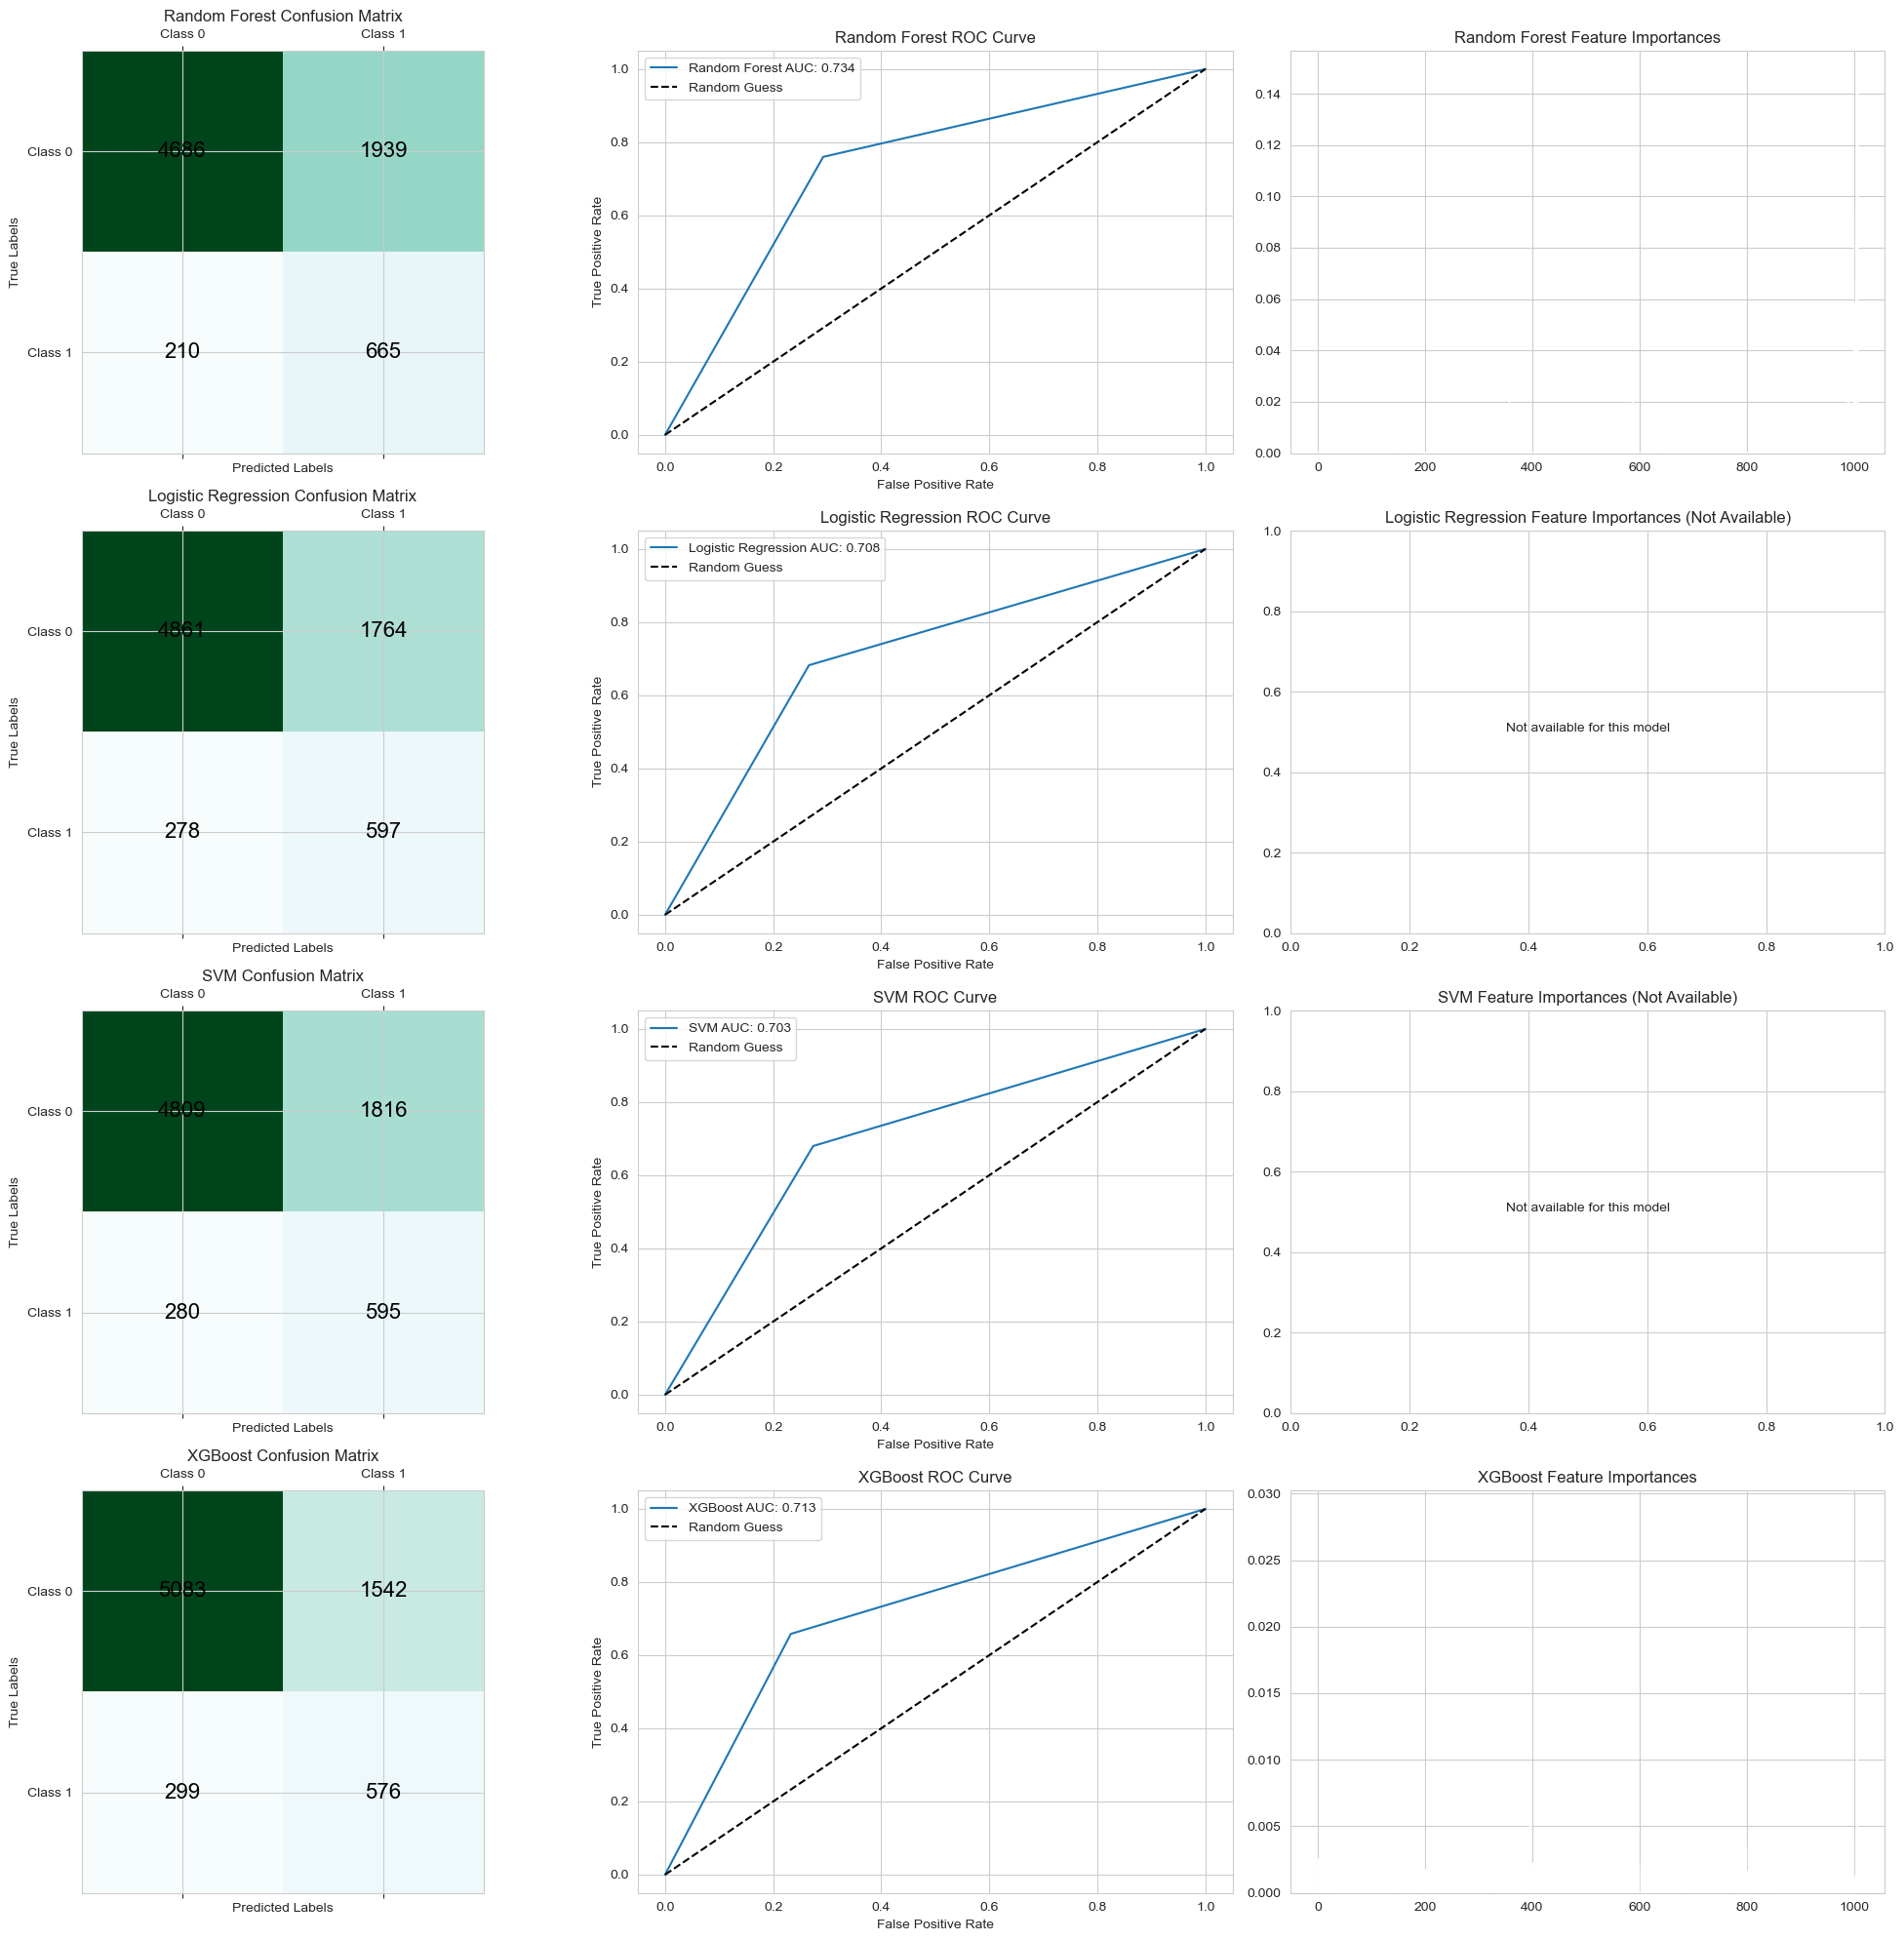

Comparing Metrics and ROC Curves for Tuned Models
Model                  Accuracy    Precision    Recall    F1-Score       AUC       TPR       FPR
-------------------  ----------  -----------  --------  ----------  --------  --------  --------
Random Forest          0.782133     0.288815  0.593143    0.388473  0.700119  0.593143  0.192906
Logistic Regression    0.7328       0.262115  0.710857    0.383005  0.723278  0.710857  0.264302
SVM                    0.720133     0.245212  0.673143    0.359475  0.699741  0.673143  0.27366
XGBoost                0.6948       0.250177  0.809143    0.382186  0.74442   0.809143  0.320302


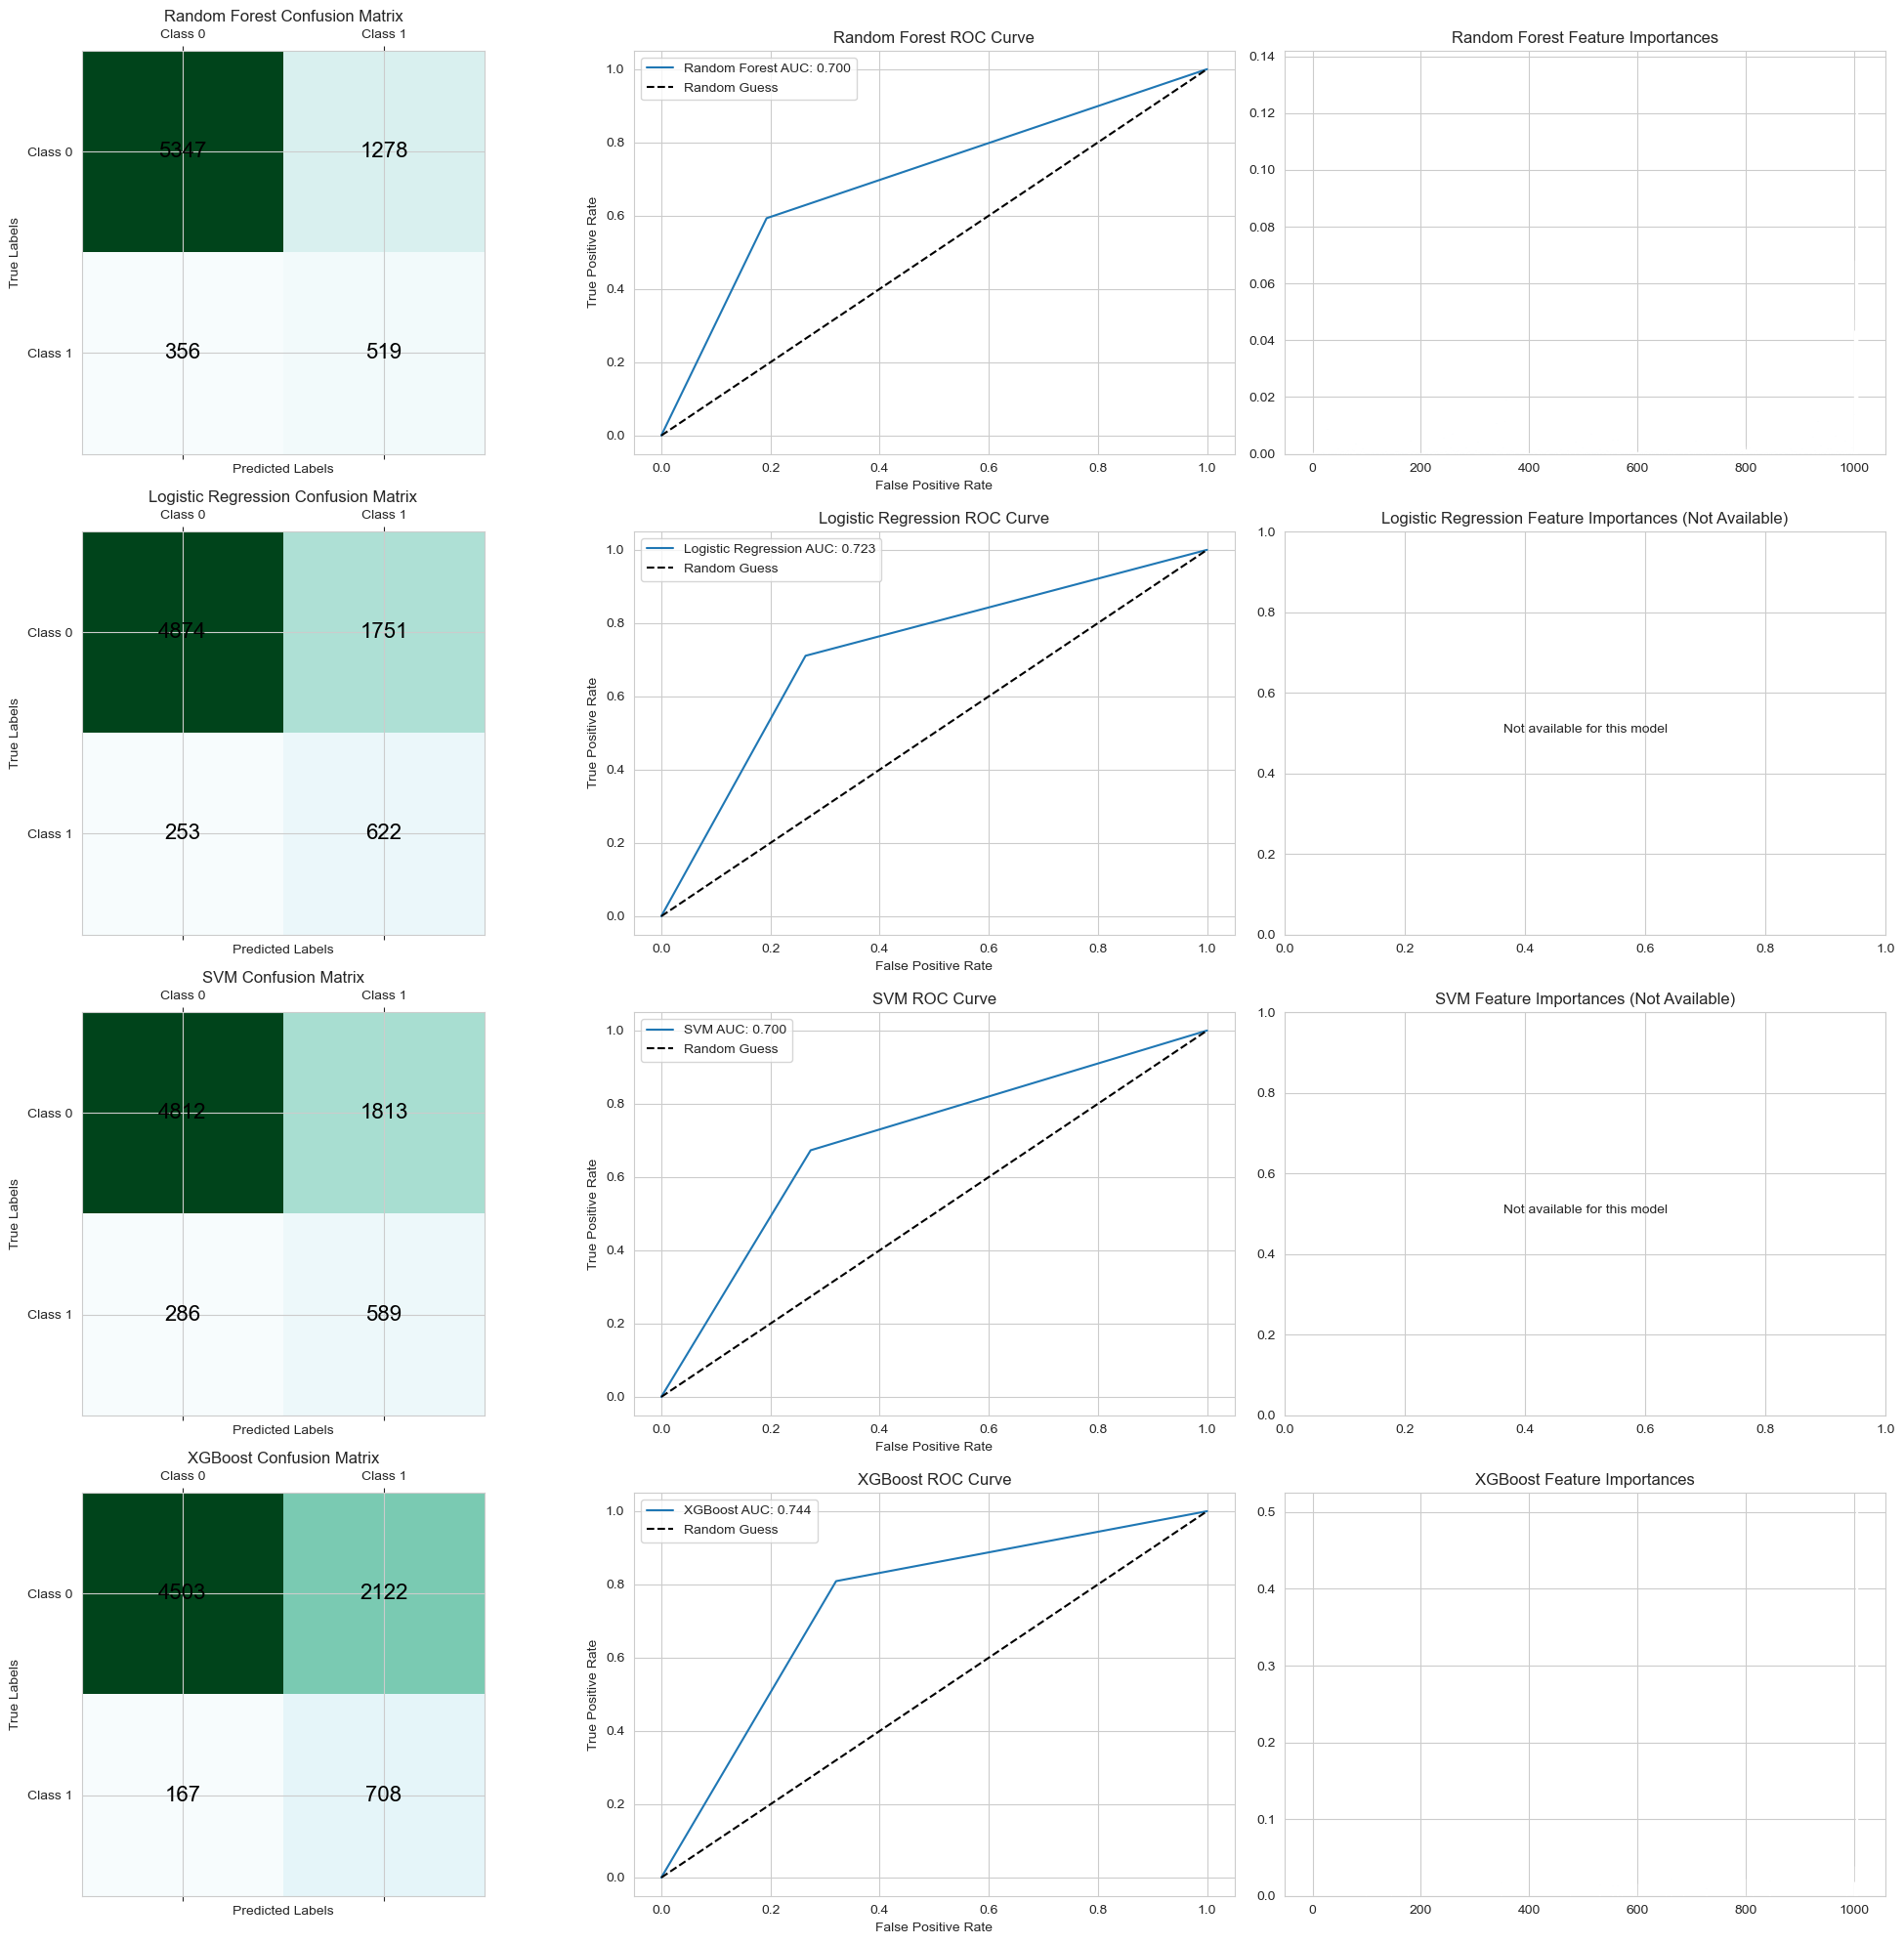

In [160]:
def evaluate_models(models, X_test, y_test):
    table_data = []
    fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(20, 20))

    for model_name, model in models.items():
        # Predictions
        y_pred = model.predict(X_test)

        # F1-Score
        f1 = f1_score(y_test, y_pred)

        # Area under ROC curve
        roc_auc = auc(roc_curve(y_test, y_pred)[0], roc_curve(y_test, y_pred)[1])

        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Precision
        precision = precision_score(y_test, y_pred, zero_division=1)

        # Recall
        recall = recall_score(y_test, y_pred)

        # TPR and FPR
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        tpr = tpr[1]
        fpr = fpr[1]

        table_data.append([model_name, accuracy, precision, recall, f1, roc_auc, tpr, fpr])

    table_headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC', 'TPR', 'FPR']
    print(tabulate(table_data, table_headers))
    
    for i, (model_name, model) in enumerate(models.items()):
        ax1, ax2, ax3 = axes[i]

        # Predictions
        y_pred = model.predict(X_test)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        ax1.matshow(cm, cmap='BuGn')
        ax1.set_title(f'{model_name} Confusion Matrix')
        ax1.set_xlabel('Predicted Labels')
        ax1.set_ylabel('True Labels')
        class_labels = ['Class 0', 'Class 1']  # adjust this to your class labels
        ax1.set_xticks([0, 1])
        ax1.set_yticks([0, 1])
        ax1.set_xticklabels(class_labels)
        ax1.set_yticklabels(class_labels)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax1.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=16)

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        ax2.plot(fpr, tpr, label=f'{model_name} AUC: {auc(fpr, tpr):.3f}')
        ax2.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        ax2.set_title(f'{model_name} ROC Curve')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.legend()
        ax2.grid(True)

        # Feature Importances
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            ax3.bar(range(len(importances)), importances)
            ax3.set_title(f'{model_name} Feature Importances')
            ax3.grid(True)
        else:
            ax3.set_title(f'{model_name} Feature Importances (Not Available)')
            ax3.text(0.5, 0.5, 'Not available for this model', ha='center')

    plt.tight_layout()
    plt.show()

# Defining the models to compare
tuned_models = {
    "Random Forest": rf_best_model,
    "Logistic Regression": lr_best_model,
    "SVM": svm_best_model,
    "XGBoost": xgb_best_model
}

base_models = {
    "Random Forest": rf_classifier,
    "Logistic Regression": lr_classifier,
    "SVM": svm_classifier,
    "XGBoost": xgb_classifier
}

# Evaluation and comparison of models
print("Comparing Metrics and ROC Curves for Base Models")
print("===================================================")
evaluate_models(base_models, X_test, y_test)
print("Comparing Metrics and ROC Curves for Tuned Models")
print("===================================================")
evaluate_models(tuned_models, X_test, y_test)

Plotting Metrics Comparisons

Plotting Metrics for Base Models


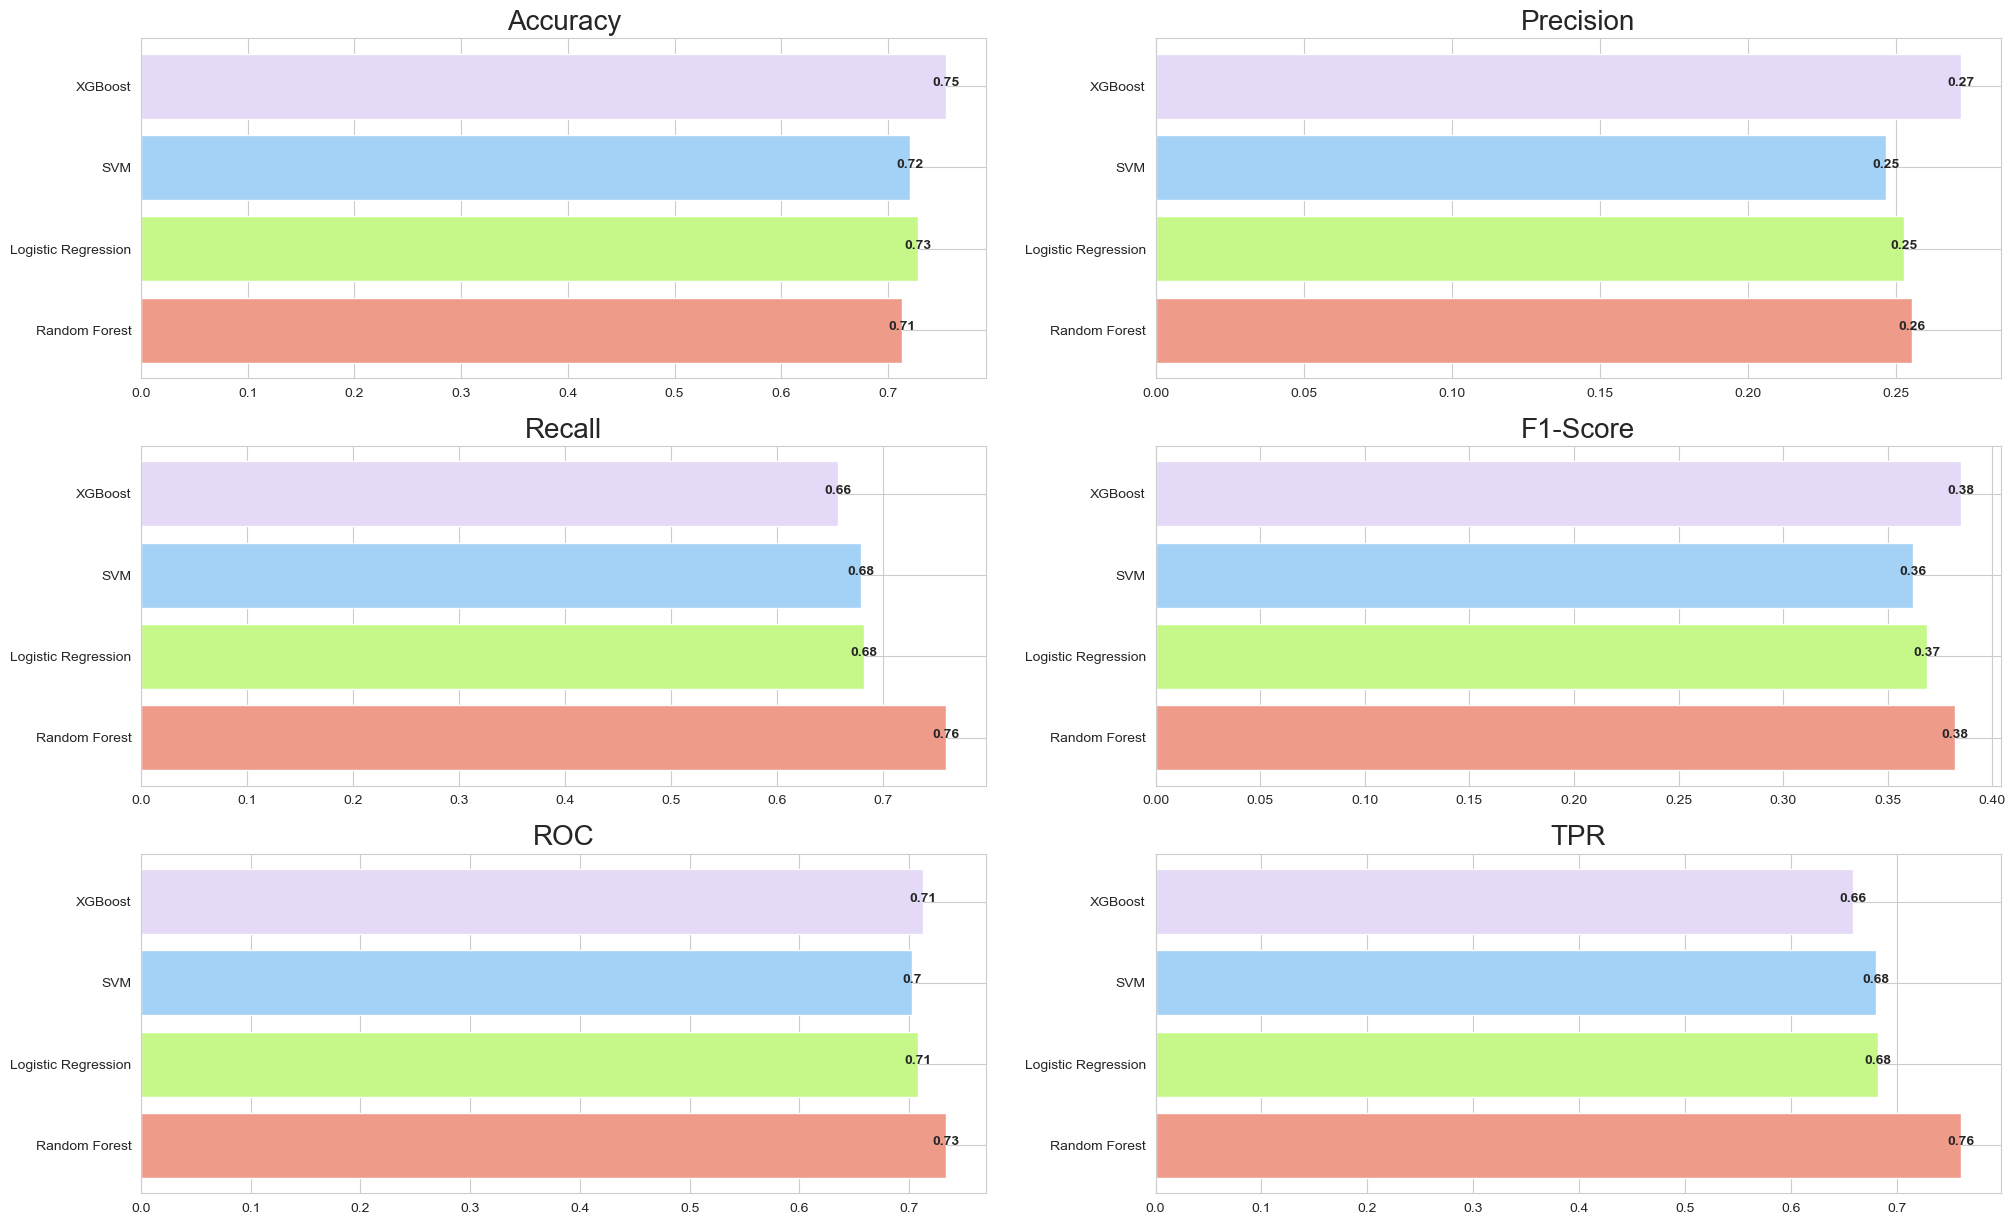

Plotting Metrics for Tuned Models


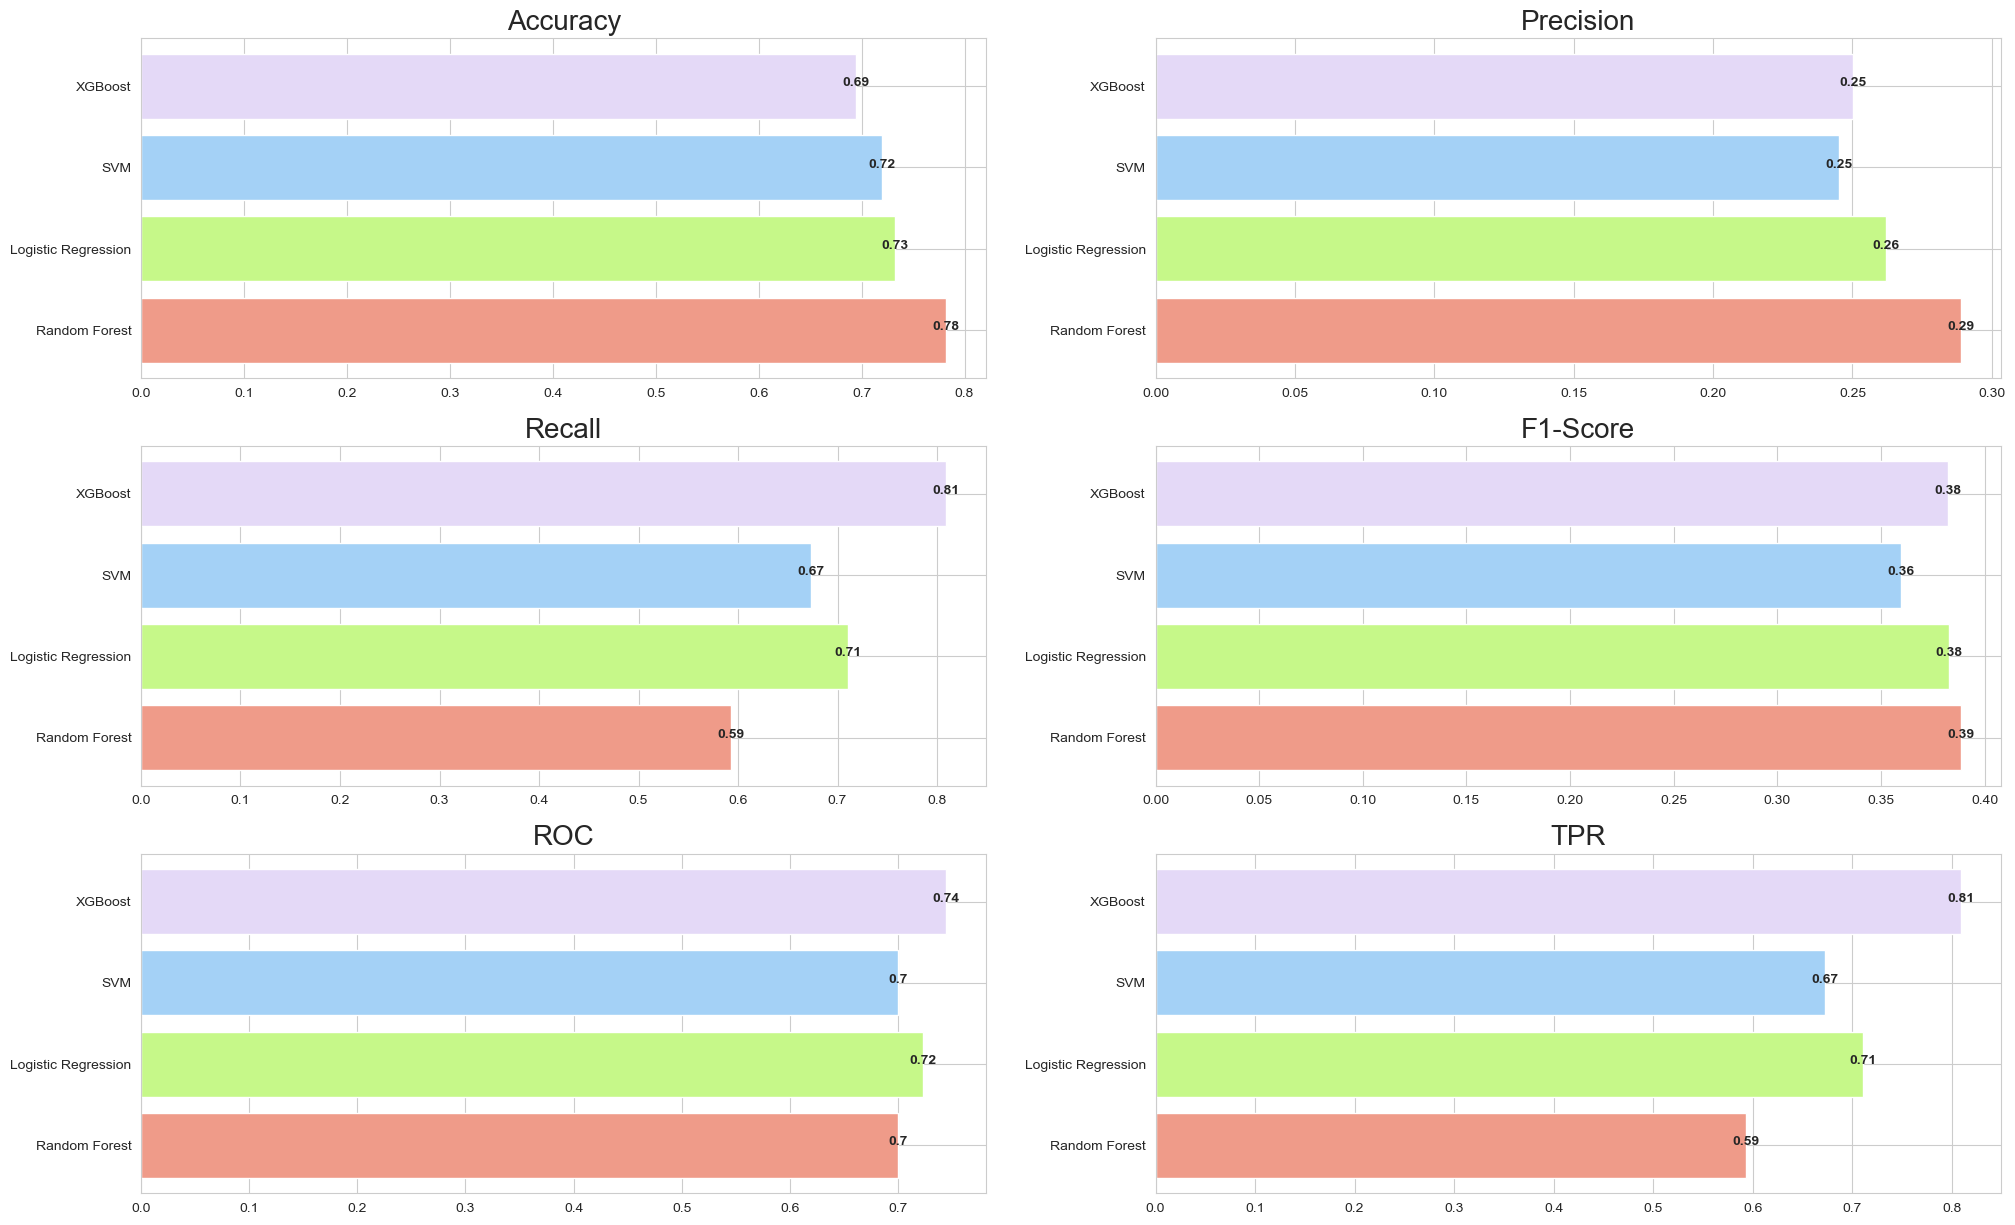

In [161]:
def evaluate_models(models, X_test, y_test):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 15))

    # Initialize lists to store metric values
    model_names = list(models.keys())
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    aucs = []
    tprs = []

    # Loop through each model
    for model_name, model in models.items():
        # Predictions
        y_pred = model.predict(X_test)

        # F1-Score
        f1 = f1_score(y_test, y_pred)

        # Area under ROC curve
        roc_auc = auc(roc_curve(y_test, y_pred)[0], roc_curve(y_test, y_pred)[1])
        aucs.append(roc_auc)

        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        # Precision
        precision = precision_score(y_test, y_pred, zero_division=1)
        precisions.append(precision)

        # Recall
        recall = recall_score(y_test, y_pred)
        recalls.append(recall)

        # F1-Score
        f1_scores.append(f1)

        # TPR, FPR
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        tpr = tpr[1]
        fpr = fpr[1]

        tprs.append(tpr)

    # Plot histograms for each metric
    colors = ['#EF9B89', '#C6F889', '#A4D1F6', '#E4D9F7','#F8F6CB']  # Assign a color to each model
    for i, model_name in enumerate(model_names):
        axes[0][0].barh(model_name, accuracies[i], color=colors[i])
        axes[0][0].text(accuracies[i], model_name, round(accuracies[i],2), ha='center', fontweight='bold')
        axes[0][1].barh(model_name, precisions[i], color=colors[i])
        axes[0][1].text(precisions[i], model_name, round(precisions[i],2), ha='center', fontweight='bold')
        axes[1][0].barh(model_name, recalls[i], color=colors[i])
        axes[1][0].text(recalls[i], model_name, round(recalls[i],2), ha='center', fontweight='bold')
        axes[1][1].barh(model_name, f1_scores[i], color=colors[i])
        axes[1][1].text(f1_scores[i], model_name, round(f1_scores[i],2), ha='center', fontweight='bold')
        axes[2][0].barh(model_name, aucs[i], color=colors[i])
        axes[2][0].text(aucs[i], model_name, round(aucs[i],2), ha='center', fontweight='bold')
        axes[2][1].barh(model_name, tprs[i], color=colors[i])
        axes[2][1].text(tprs[i], model_name, round(tprs[i],2), ha='center', fontweight='bold')

    axes[0][0].set_title('Accuracy', fontsize=20)
    axes[0][1].set_title('Precision', fontsize=20)
    axes[1][0].set_title('Recall', fontsize=20)
    axes[1][1].set_title('F1-Score', fontsize=20)
    axes[2][0].set_title('ROC', fontsize=20)
    axes[2][1].set_title('TPR', fontsize=20)

# Defining the models to compare
tuned_models = {
    "Random Forest": rf_best_model,
    "Logistic Regression": lr_best_model,
    "SVM": svm_best_model,
    "XGBoost": xgb_best_model
}

base_models = {
    "Random Forest": rf_classifier,
    "Logistic Regression": lr_classifier,
    "SVM": svm_classifier,
    "XGBoost": xgb_classifier
}

# Evaluation and comparison of models
print("Plotting Metrics for Base Models")
print("===================================================")
evaluate_models(base_models, X_test, y_test)
plt.show()
print("Plotting Metrics for Tuned Models")
print("===================================================")
evaluate_models(tuned_models, X_test, y_test)
plt.show()

<font color='green'> By sacrificing accuracy, XGBoost is able to outperform other models when it comes to Recall and TPR. It is able to accurately predict 81% of the true positives. This is a good achievement seeing as how these current models are not the best fit for this use case. The trade-off between Accuracy/Precision as compared to Recall and ROC here is justified as our end goal was able to identify as many helpful reviews as possible. Sure with the current model, there is a bit of noise as well as it may be introducing some false positives. </font>

Plotting change in ROC curves

ROC Comparisons for Base Models


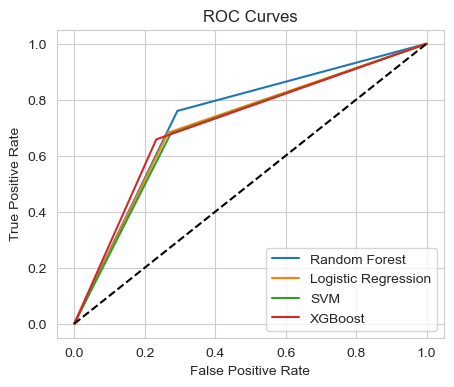

ROC Comparisons for Tuned Models


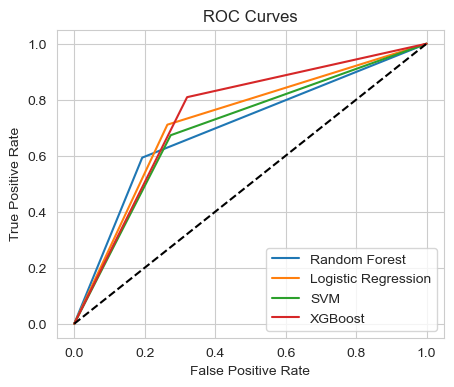

In [162]:
def evaluate_models(models, X_test, y_test):

    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred)

    # Plot ROC curves
    plt.figure(figsize=(5, 4))
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label=model_name)

    plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

# Defining the models to compare
tuned_models = {
    "Random Forest": rf_best_model,
    "Logistic Regression": lr_best_model,
    "SVM": svm_best_model,
    "XGBoost": xgb_best_model
}

base_models = {
    "Random Forest": rf_classifier,
    "Logistic Regression": lr_classifier,
    "SVM": svm_classifier,
    "XGBoost": xgb_classifier
}

# Evaluation and comparison of models
print("ROC Comparisons for Base Models")
print("===================================================")
evaluate_models(base_models, X_test, y_test)
print("ROC Comparisons for Tuned Models")
print("===================================================")
evaluate_models(tuned_models, X_test, y_test)

<font color='green'> Looking at the ROC curves, XGBoost is the best performing model as its accurately able to identify the highest percentage of True Positives</font>

### <font color='blue'>Feature importance</font>

In [163]:
# Function to plot feature importance (top 20 as default)
def plot_top_n_feature_importance(importance, names, model_name, top_n=20):
    feature_importance = pd.DataFrame({'feature': names, 'importance': importance})
    feature_importance.sort_values(by='importance', ascending=False, inplace=True)
    top_features = feature_importance.head(top_n)
    plt.figure(figsize=(6, 6))
    plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Features - {model_name}')
    plt.show()

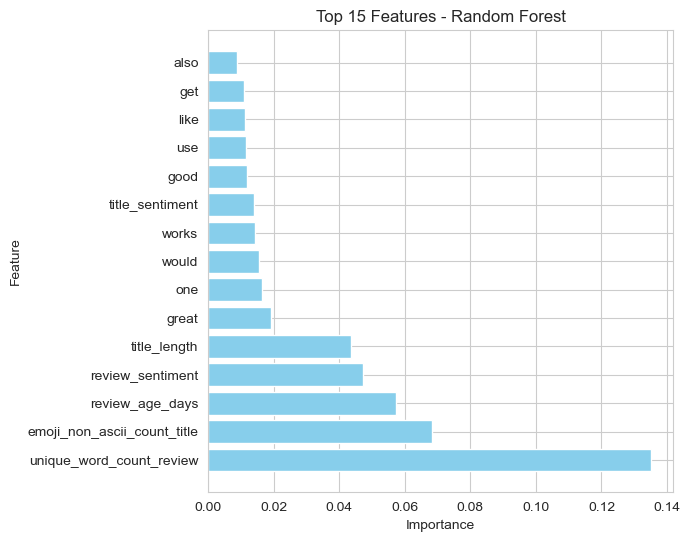

In [164]:
# Random Forest Feature Importance
rf_feature_importance = rf_best_model.feature_importances_
plot_top_n_feature_importance(rf_feature_importance, X_train.columns, 'Random Forest', 15)

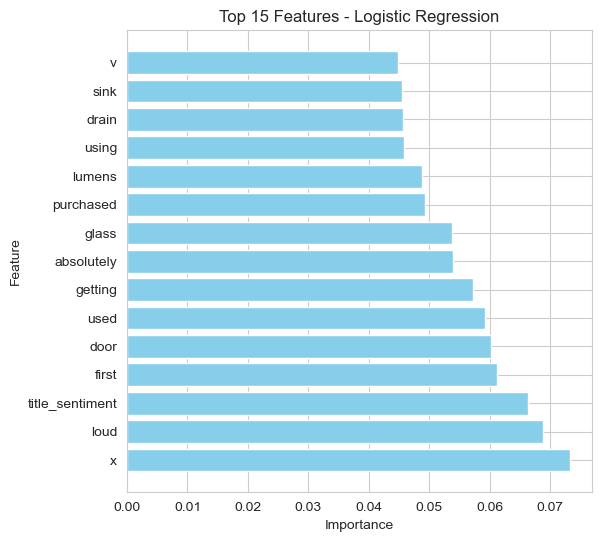

In [165]:
# Logistic Regression Coefficients (for positive and negative impact)
lr_feature_importance = lr_best_model.coef_[0]
plot_top_n_feature_importance(lr_feature_importance, X_train.columns, 'Logistic Regression', 15)

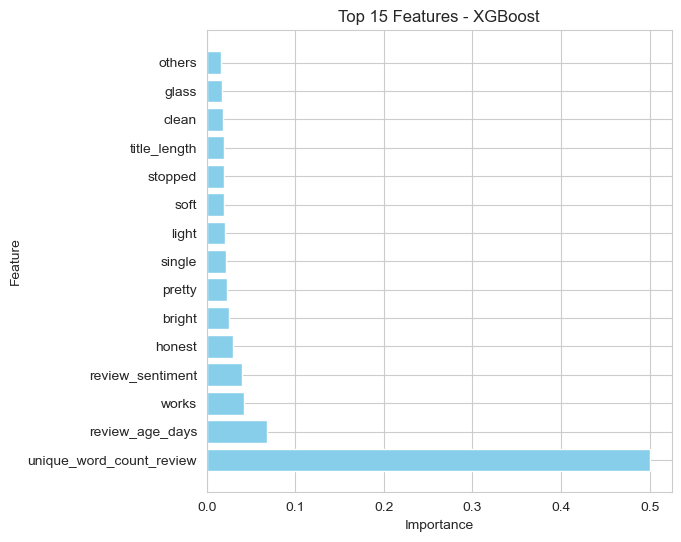

In [166]:
# XGBoost Feature Importance
xgb_feature_importance = xgb_best_model.feature_importances_
plot_top_n_feature_importance(xgb_feature_importance, X_train.columns, 'XGBoost',15)

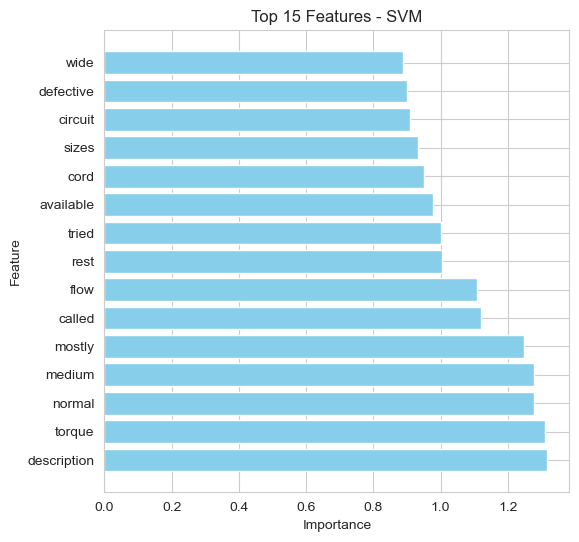

In [167]:
# SVM Feature Importance
svm_feature_importance = svm_best_model.coef_[0]
plot_top_n_feature_importance(svm_feature_importance, X_train.columns, 'SVM',15)

In [168]:
# Specifying the tree based classifier instance to get the feature importance values
#feature_importances = rf_classifier.feature_importances_
feature_importances = xgb_best_model.feature_importances_

# Obtaining feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Dictionary to map feature names to their importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sorting the dictionary by importance (descending order)
sorted_feature_importance_desc = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Printing the top N important terms along with their relative importance
top_n = 20
for term, importance in sorted_feature_importance_desc[:top_n]:
    print(f"Review term: {term}, Importance: {importance}")

Review term: works, Importance: 0.042327020317316055
Review term: honest, Importance: 0.029120324179530144
Review term: bright, Importance: 0.025181973353028297
Review term: pretty, Importance: 0.02228705771267414
Review term: single, Importance: 0.02219977043569088
Review term: light, Importance: 0.02037094533443451
Review term: soft, Importance: 0.019846679642796516
Review term: stopped, Importance: 0.01974436827003956
Review term: clean, Importance: 0.017809385433793068
Review term: glass, Importance: 0.017059478908777237
Review term: others, Importance: 0.015584568493068218
Review term: cool, Importance: 0.01536677684634924
Review term: purchase, Importance: 0.015339403413236141
Review term: poor, Importance: 0.015088412910699844
Review term: metal, Importance: 0.015068748965859413
Review term: much, Importance: 0.014025401324033737
Review term: need, Importance: 0.013646407052874565
Review term: opener, Importance: 0.013238777406513691
Review term: replacing, Importance: 0.0098471

In [169]:
# For XGBoost base model
xgb_explainer_base = shap.TreeExplainer(xgb_classifier)
# For XGBoost tuned model
xgb_explainer_tuned = shap.TreeExplainer(xgb_best_model)

In [170]:
# For XGBoost base model
xgb_shap_base_values = xgb_explainer_base(X_test)

# For XGBoost tuned model
xgb_shap_tuned_values = xgb_explainer_tuned(X_test)

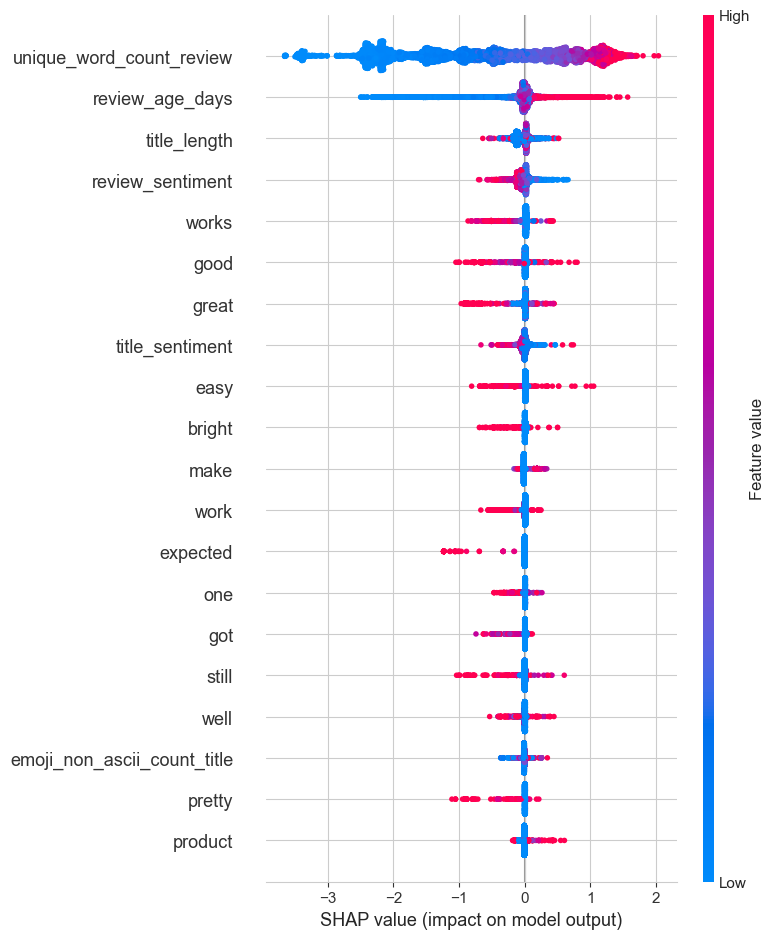

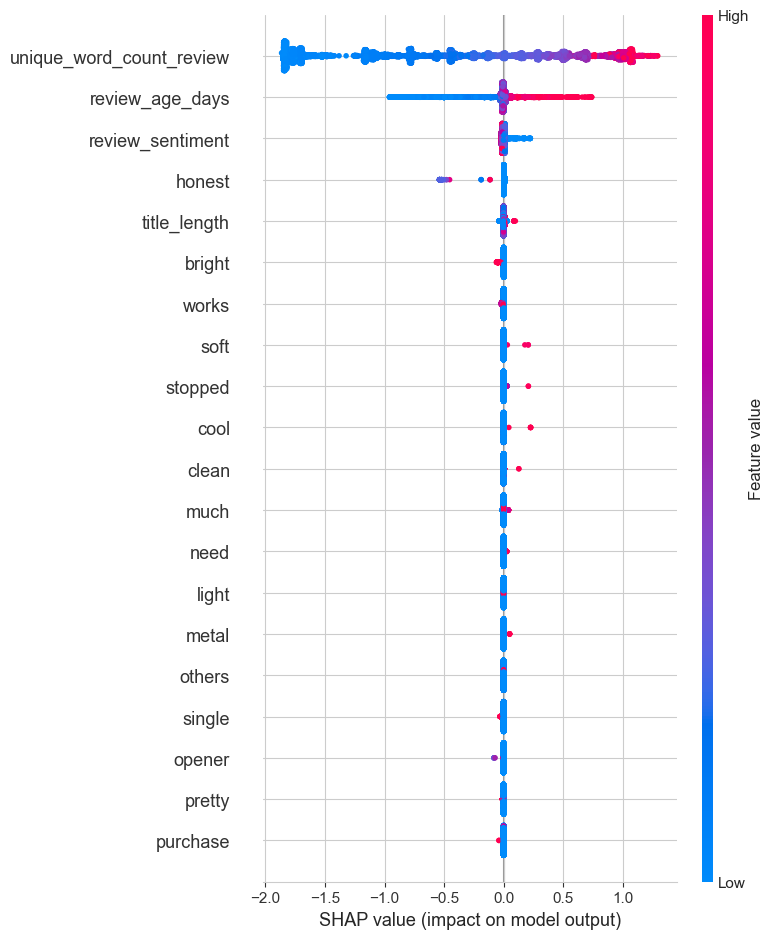

In [171]:
# summary_plot will generate summary plots for each model, showing the distribution of SHAP values for each feature 
# Features are sorted by their importance, with the most important features at the top 
# The color of each point indicates the value of the feature (red for high values, blue for low values) 
# The position of the point on the x-axis indicates the impact of that feature on the model's output

# Plot for XGBoost base model
shap.summary_plot(xgb_shap_base_values, X_test, feature_names=X_train.columns)

# Plot for XGBoost tuned model
shap.summary_plot(xgb_shap_tuned_values, X_test, feature_names=X_train.columns)

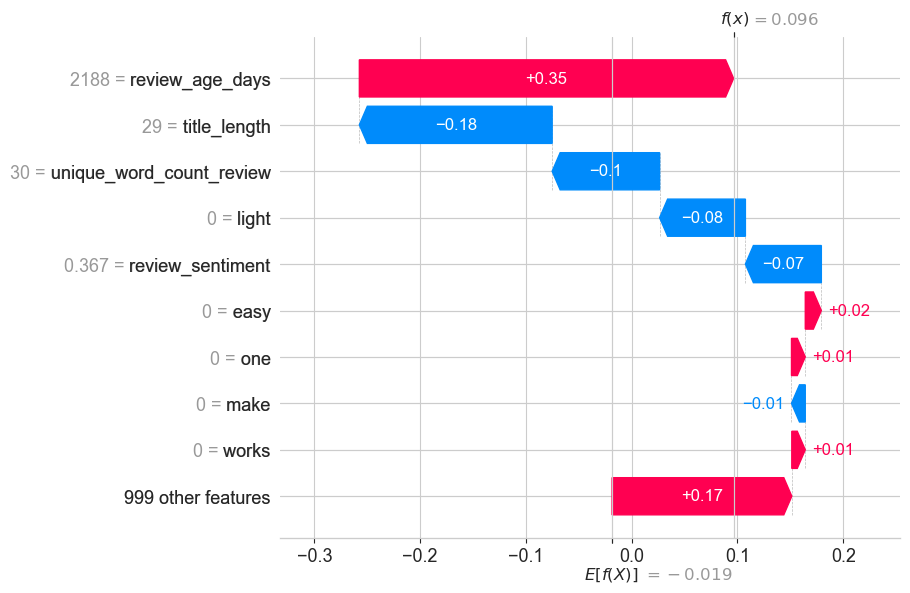

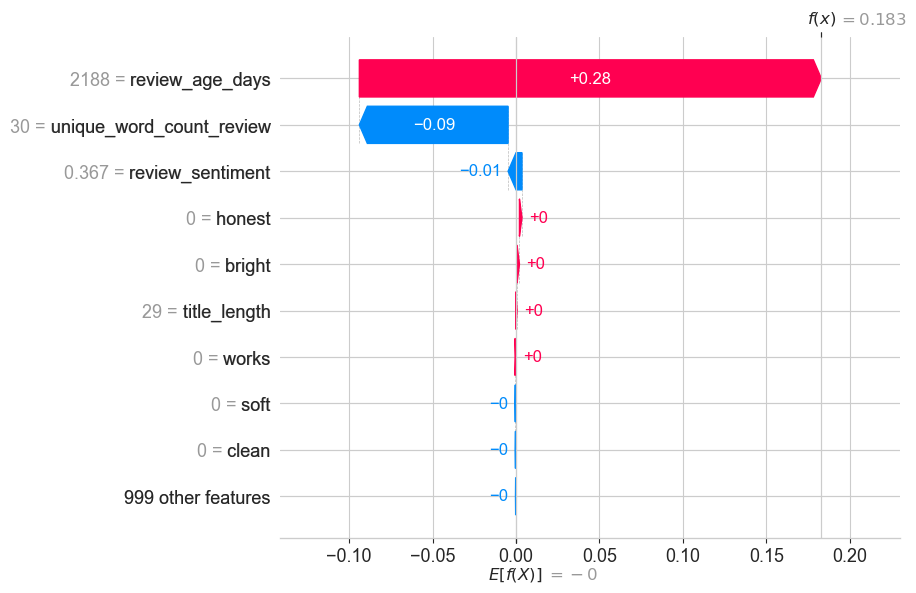

In [172]:
# Visualizing the first prediction's explanation using a waterfall plot
# The chart shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output 
# Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

# XGBoost base model waterfall plot
shap.plots.waterfall(xgb_shap_base_values[0])

# XGBoost tuned model waterfall plot
shap.plots.waterfall(xgb_shap_tuned_values[0])

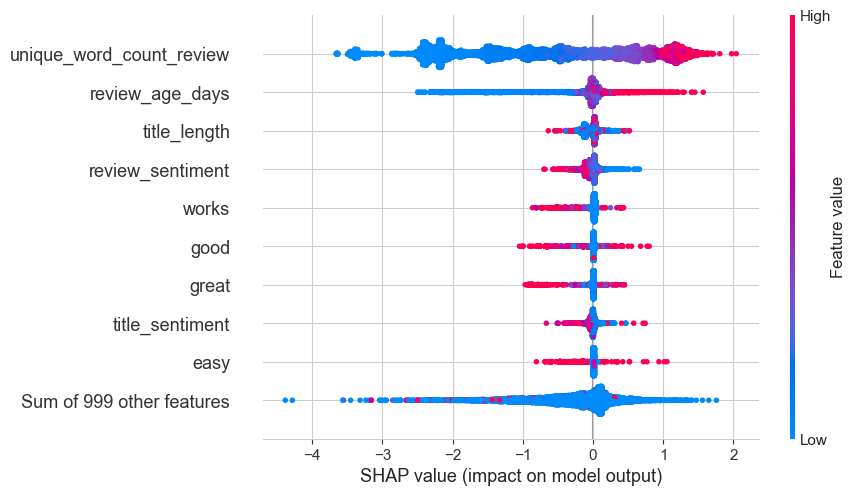

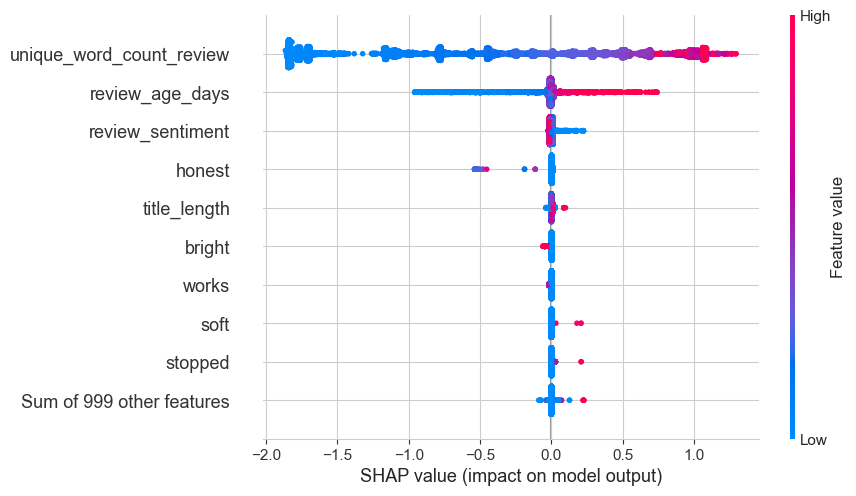

In [173]:
# Summarizing the effects of all the features
# The plot below sorts features by the sum of SHAP value magnitudes over all samples 
# It uses SHAP values to show the distribution of the impacts each feature has on the model output 
# The color represents the feature value (red high, blue low) 
# Greater concentration of red for a feature will indicate that the feature positively affects helpfulness

shap.plots.beeswarm(xgb_shap_base_values)

shap.plots.beeswarm(xgb_shap_tuned_values)

#### <font color='green'> Conclusion: Using sample weights we were able to mitigate the bias towards majority class by assigning balanced weights to each class. This helped our model improve the overall ROC scores helping us to achieve better True positive rates. Even with tuned models we were able to get a high percentage of true positives, however, the trade off was accuracy and precision. So even though were were able to tune the models to a certain degree of accuracy, the overall results are still unsatisfactory for a real world business scenario. Further NLP techniques are required to optimize the feature extraction and relevance. </font>

************ End **************